In [102]:
import torch
import torchvision
import numpy as np
import pandas as pd

In [103]:
random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [104]:
def split_indices(n, val_pct):
    n_val = int(val_pct*n)
    idx = np.random.permutation(n)
    return idx[n_val:], idx[:n_val]

In [105]:
import torchvision.transforms as transforms
from torchvision import datasets

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)
dataset_test = datasets.MNIST(root='./data', train=False, transform=mnist_transform, download=True)

print(dataset[0])

train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# training set and data loader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
# validation set and data loader
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
# test dataloader
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [106]:
from torch import nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # Output : 6x6x10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# output : 6x6x20
        self.dropout2d = nn.Dropout2d()
        self.dropout = nn.Dropout(p=0.2) # default p=0.5
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
        self.pooling = nn.MaxPool2d(2,2)
        self.act = nn.ReLU()
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.conv1(x)
        #print(x.size()) # torch.Size([128, 10, 24, 24])
        x = self.pooling(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.dropout2d(x)
        #print(x.size()) # torch.Size([128, 20, 8, 8])
        x = self.pooling(x)
        x = self.act(x)
        #print(x.size()) # torch.Size([128, 20, 4, 4])
        x = self.flatten(x)
        #print(x.size()) # torch.Size([128, 320])
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x) # Return value between 0 or 1

In [107]:
# Latent data is the noise. We want to generate real data (1, 28, 28) and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 7*7*64) # (n, 256, 7, 7)
        self.conv1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # (n, 64, 16, 16)
        self.conv2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # (n, 16, 34, 34)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=7) #(n, 1, 28, 28)
        self.act = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.fc(x)
        x = self.act(x)
        x = x.view(-1, 64, 7, 7)
        
        # Upsample
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.conv3(x)
        
        # Downsample
        return x
        

In [108]:
LATENT_DIM = 100

class GAN(nn.Module):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.generator = Generator(latent_dim=latent_dim)
        self.discriminator = Discriminator()

        # random noise
        self.validation_z = torch.randn(6, LATENT_DIM)
        
    def forward(self, z):
        return self.generator(z)

In [109]:
import matplotlib.pyplot as plt

def plot_imgs(imgs_g):
    fig = plt.figure()
    for i in range(imgs_g.size(0)):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(imgs_g.cpu().detach()[i,0,:,:], cmap='gray_r', interpolation='none')
        plt.title("Generated Data")
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
    plt.show()

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Epoch [1/100] | D Loss: 0.6932 | G Loss: 0.6931


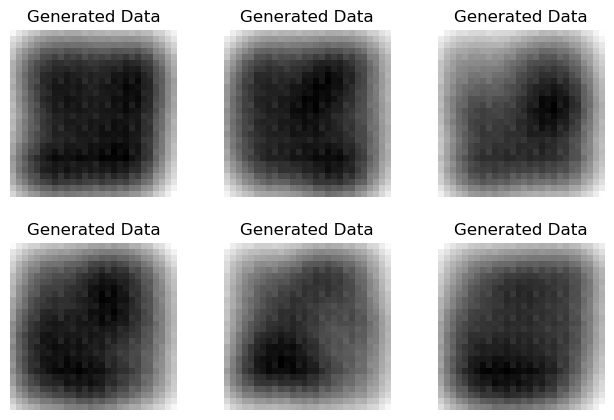

  0%|▎                                                                                 | 1/300 [00:07<38:36,  7.75s/it]

Epoch [2/100] | D Loss: 0.6928 | G Loss: 0.6931


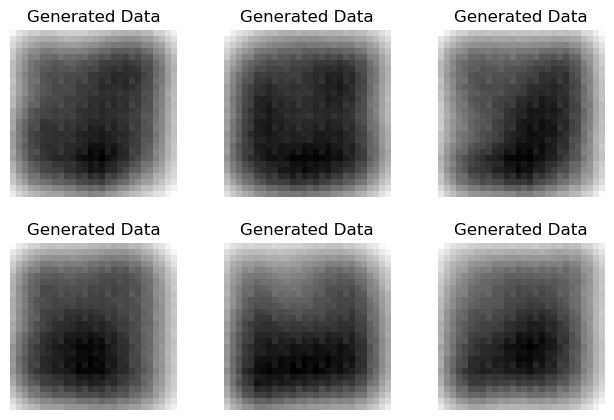

  1%|▌                                                                                 | 2/300 [00:14<35:26,  7.14s/it]

Epoch [3/100] | D Loss: 0.6920 | G Loss: 0.6913


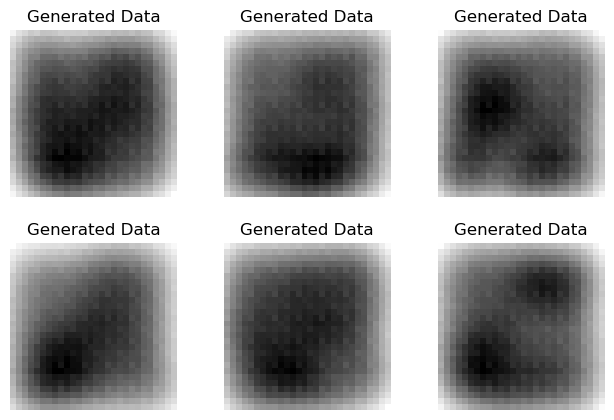

  1%|▊                                                                                 | 3/300 [00:22<37:30,  7.58s/it]

Epoch [4/100] | D Loss: 0.5533 | G Loss: 0.6913


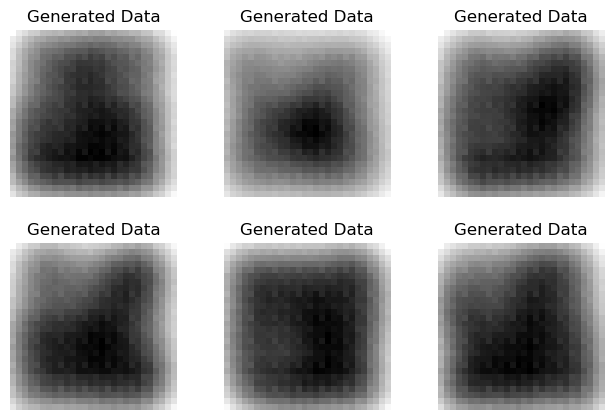

  1%|█                                                                                 | 4/300 [00:29<35:52,  7.27s/it]

Epoch [5/100] | D Loss: 0.5533 | G Loss: 0.6930


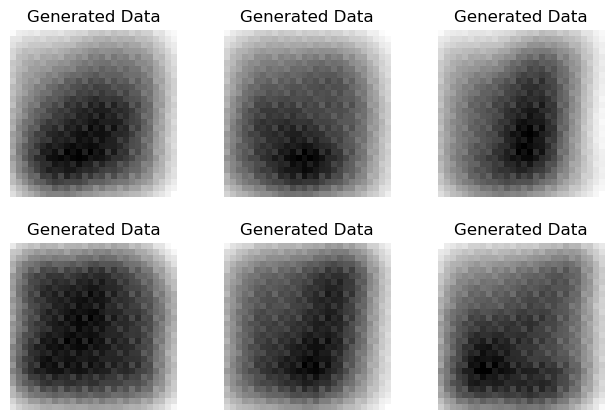

  2%|█▎                                                                                | 5/300 [00:37<36:59,  7.52s/it]

Epoch [6/100] | D Loss: 0.5534 | G Loss: 0.6930


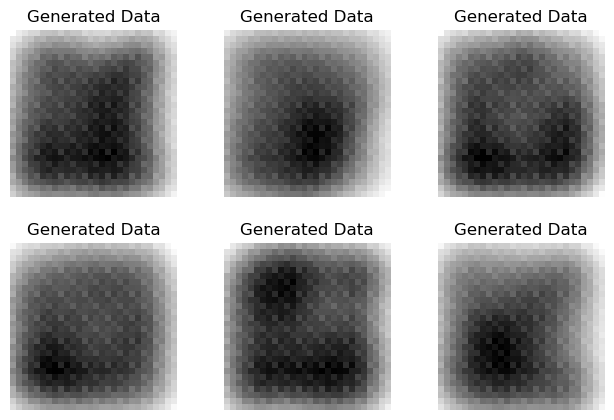

  2%|█▋                                                                                | 6/300 [00:43<35:24,  7.23s/it]

Epoch [7/100] | D Loss: 0.5533 | G Loss: 0.6929


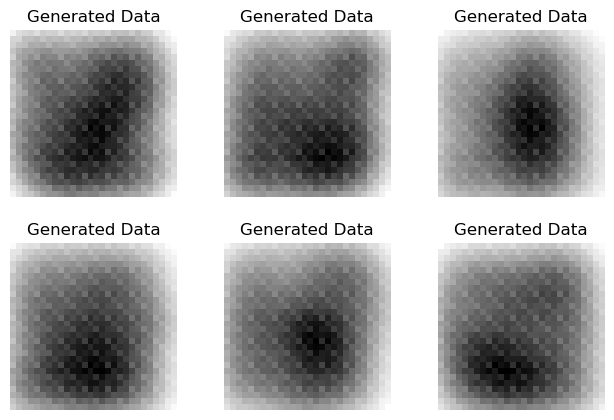

  2%|█▉                                                                                | 7/300 [00:51<36:03,  7.39s/it]

Epoch [8/100] | D Loss: 0.5542 | G Loss: 0.6929


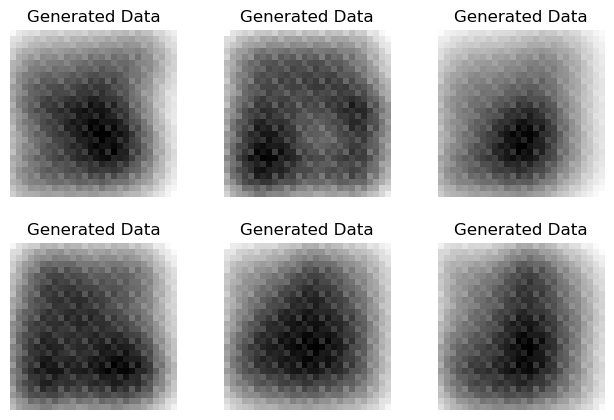

  3%|██▏                                                                               | 8/300 [00:58<35:05,  7.21s/it]

Epoch [9/100] | D Loss: 0.5532 | G Loss: 0.6931


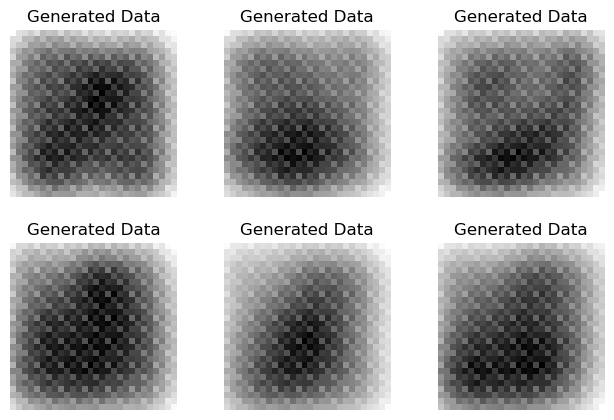

  3%|██▍                                                                               | 9/300 [01:06<35:47,  7.38s/it]

Epoch [10/100] | D Loss: 0.5542 | G Loss: 0.6931


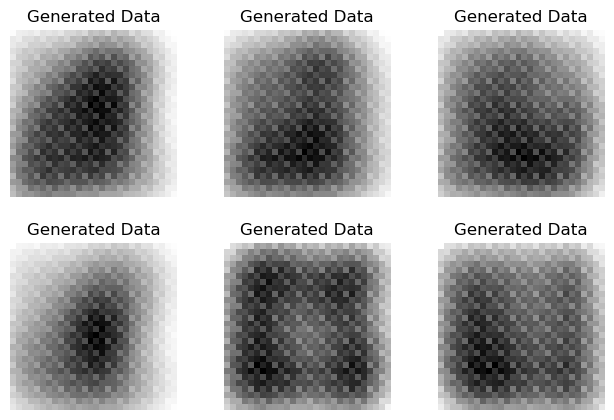

  3%|██▋                                                                              | 10/300 [01:12<34:33,  7.15s/it]

Epoch [11/100] | D Loss: 0.5760 | G Loss: 0.6926


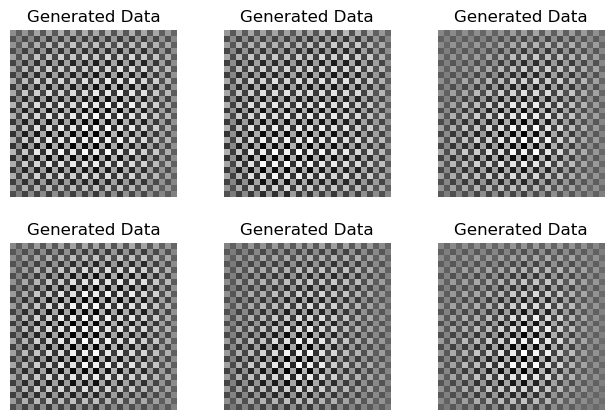

  4%|██▉                                                                              | 11/300 [01:20<35:17,  7.33s/it]

Epoch [12/100] | D Loss: 0.5534 | G Loss: 0.6926


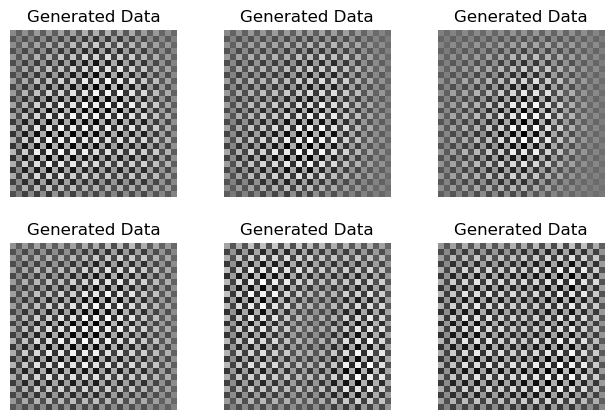

  4%|███▏                                                                             | 12/300 [01:27<34:35,  7.21s/it]

Epoch [13/100] | D Loss: 0.5532 | G Loss: 0.6931


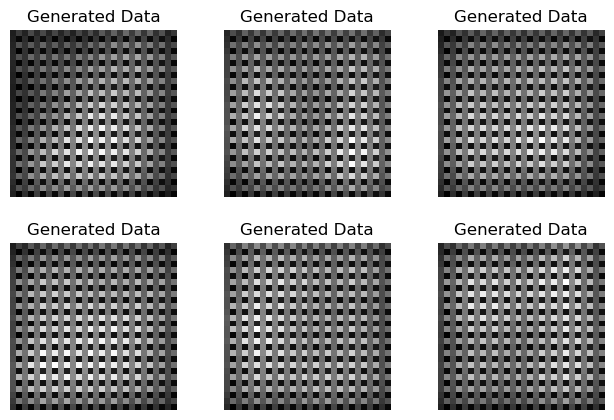

  4%|███▌                                                                             | 13/300 [01:35<35:17,  7.38s/it]

Epoch [14/100] | D Loss: 0.5542 | G Loss: 0.6931


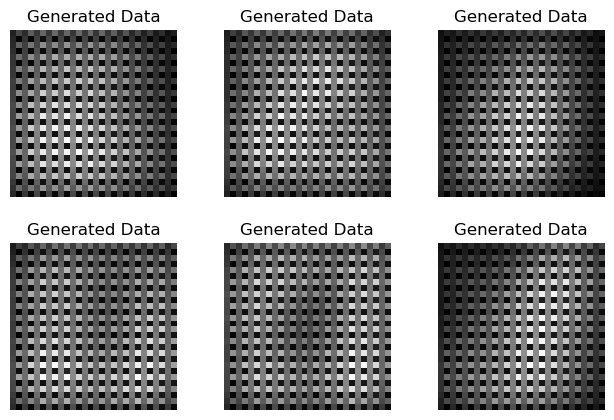

  5%|███▊                                                                             | 14/300 [01:42<34:13,  7.18s/it]

Epoch [15/100] | D Loss: 0.5532 | G Loss: 0.6931


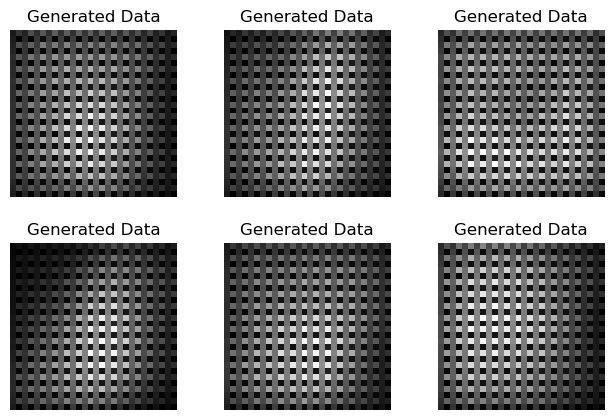

  5%|████                                                                             | 15/300 [01:50<35:22,  7.45s/it]

Epoch [16/100] | D Loss: 0.5532 | G Loss: 0.6931


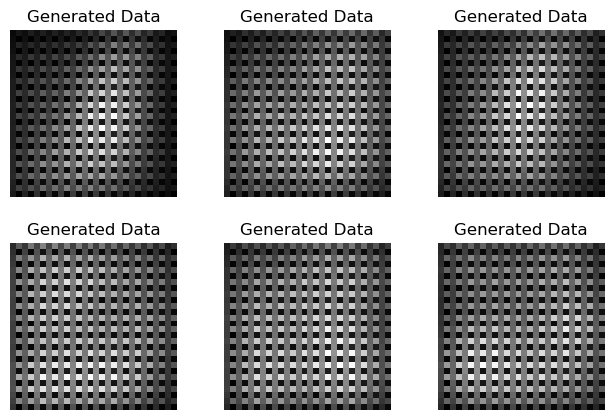

  5%|████▎                                                                            | 16/300 [01:57<34:28,  7.28s/it]

Epoch [17/100] | D Loss: 0.5532 | G Loss: 0.6931


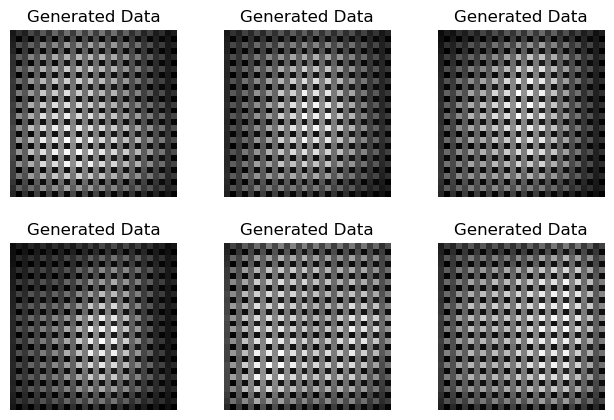

  6%|████▌                                                                            | 17/300 [02:05<35:22,  7.50s/it]

Epoch [18/100] | D Loss: 0.5533 | G Loss: 0.6931


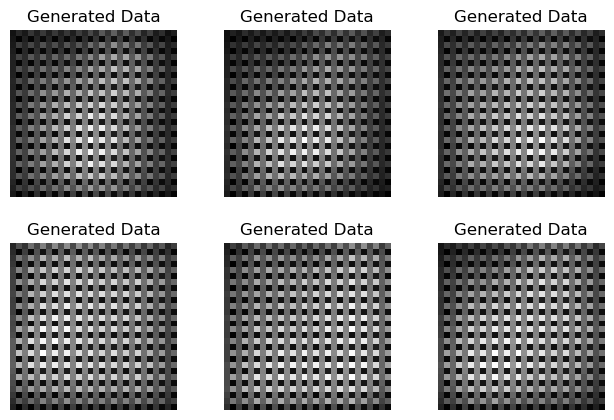

  6%|████▊                                                                            | 18/300 [02:11<34:10,  7.27s/it]

Epoch [19/100] | D Loss: 0.5539 | G Loss: 0.6931


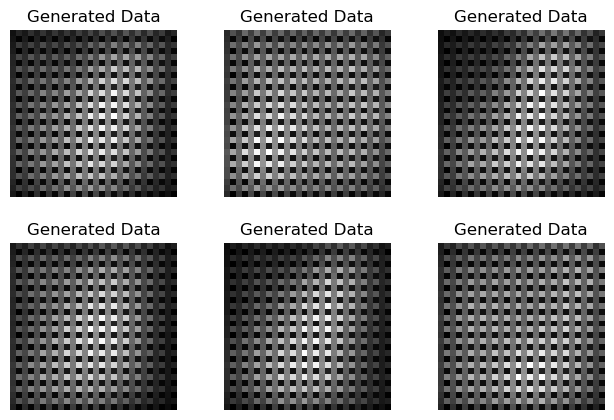

  6%|█████▏                                                                           | 19/300 [02:19<34:48,  7.43s/it]

Epoch [20/100] | D Loss: 0.5532 | G Loss: 0.6931


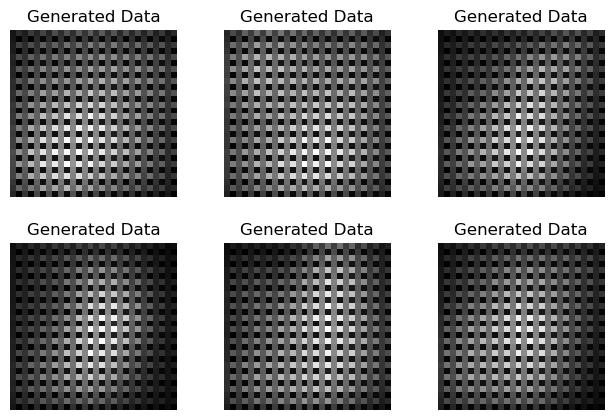

  7%|█████▍                                                                           | 20/300 [02:26<33:46,  7.24s/it]

Epoch [21/100] | D Loss: 0.5539 | G Loss: 0.6931


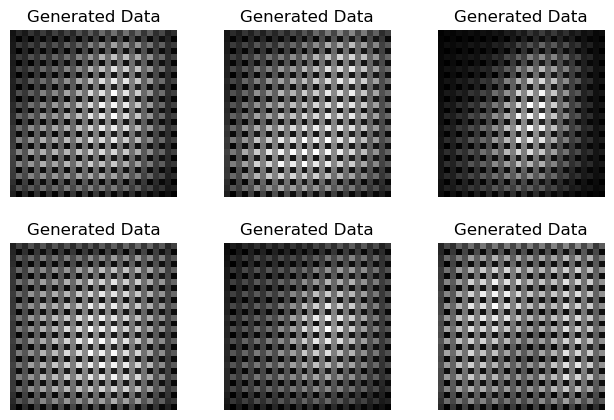

  7%|█████▋                                                                           | 21/300 [02:34<34:46,  7.48s/it]

Epoch [22/100] | D Loss: 0.5532 | G Loss: 0.6931


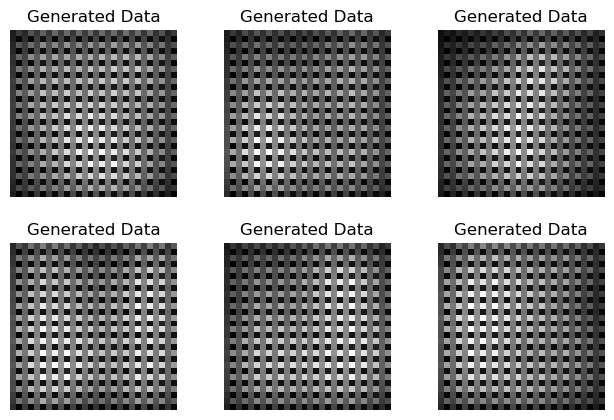

  7%|█████▉                                                                           | 22/300 [02:41<33:43,  7.28s/it]

Epoch [23/100] | D Loss: 0.5532 | G Loss: 0.6922


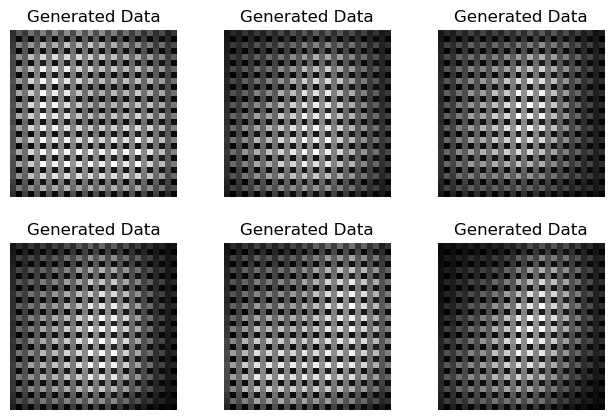

  8%|██████▏                                                                          | 23/300 [02:49<34:22,  7.45s/it]

Epoch [24/100] | D Loss: 0.5537 | G Loss: 0.6922


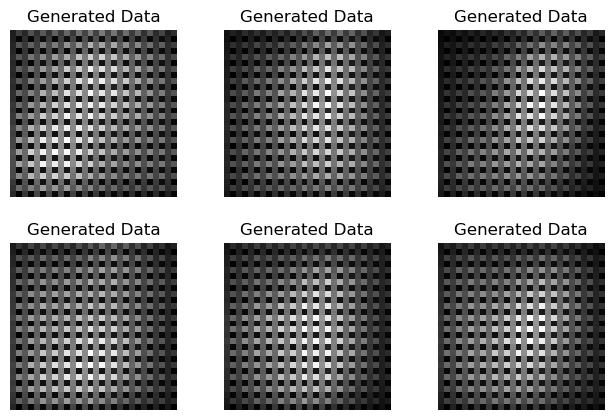

  8%|██████▍                                                                          | 24/300 [02:55<33:26,  7.27s/it]

Epoch [25/100] | D Loss: 0.5532 | G Loss: 0.6931


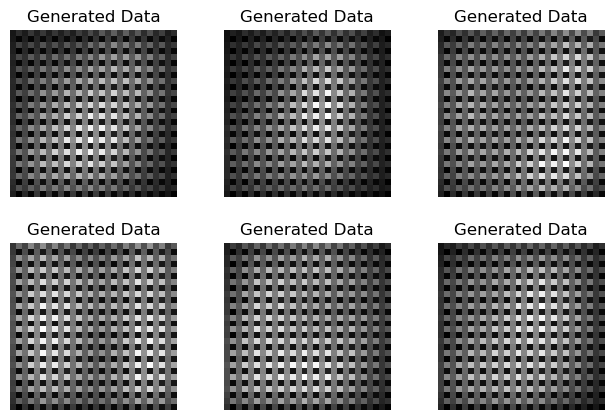

  8%|██████▊                                                                          | 25/300 [03:03<34:07,  7.45s/it]

Epoch [26/100] | D Loss: 0.5532 | G Loss: 0.6931


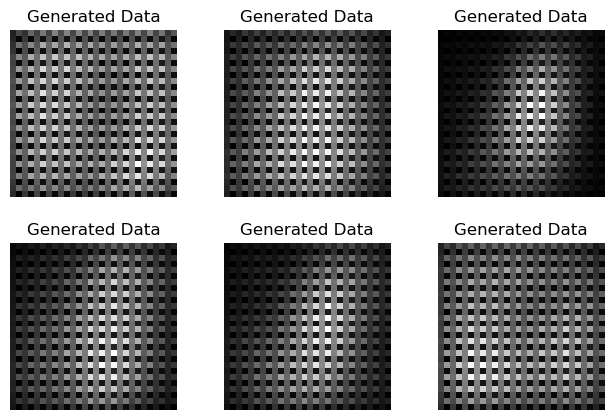

  9%|███████                                                                          | 26/300 [03:10<33:29,  7.33s/it]

Epoch [27/100] | D Loss: 0.5536 | G Loss: 0.6921


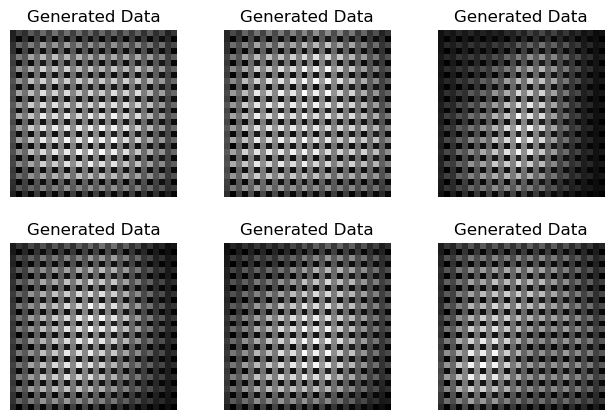

  9%|███████▎                                                                         | 27/300 [03:18<34:02,  7.48s/it]

Epoch [28/100] | D Loss: 0.5532 | G Loss: 0.6921


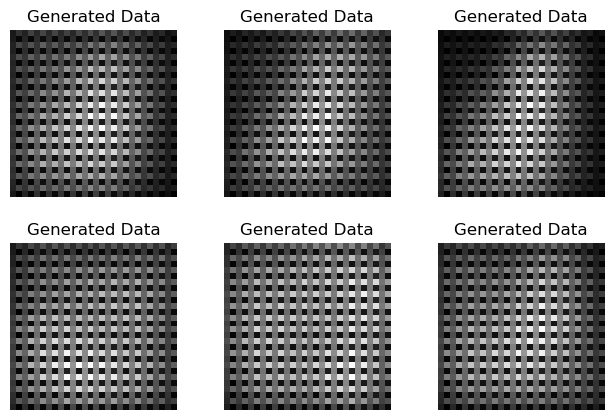

  9%|███████▌                                                                         | 28/300 [03:25<33:02,  7.29s/it]

Epoch [29/100] | D Loss: 0.5537 | G Loss: 0.6931


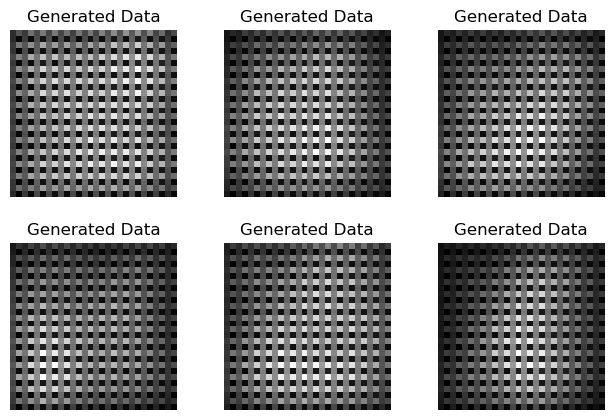

 10%|███████▊                                                                         | 29/300 [03:33<33:52,  7.50s/it]

Epoch [30/100] | D Loss: 0.5532 | G Loss: 0.6931


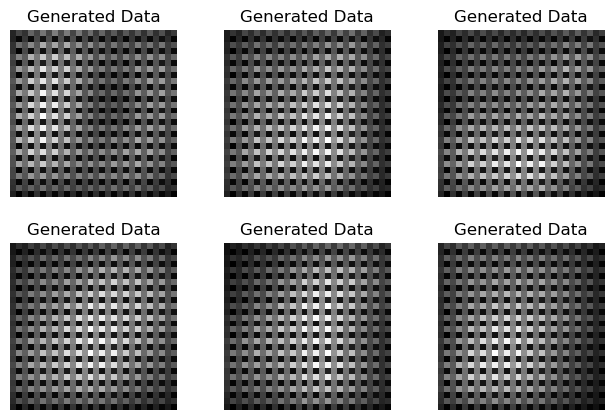

 10%|████████                                                                         | 30/300 [03:40<32:58,  7.33s/it]

Epoch [31/100] | D Loss: 0.5532 | G Loss: 0.6931


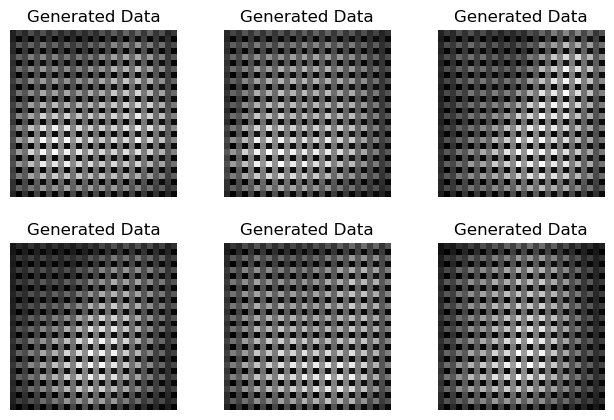

 10%|████████▎                                                                        | 31/300 [03:48<33:56,  7.57s/it]

Epoch [32/100] | D Loss: 0.5532 | G Loss: 0.6931


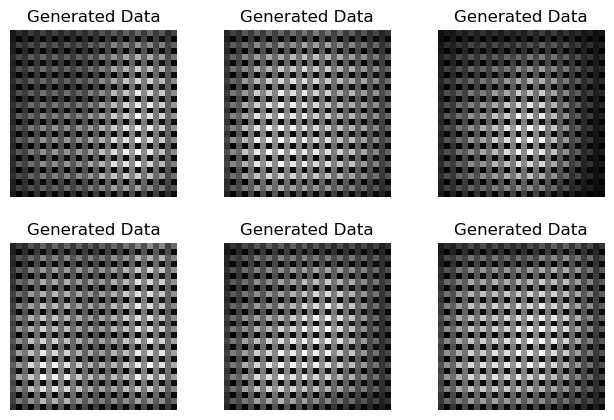

 11%|████████▋                                                                        | 32/300 [03:55<32:50,  7.35s/it]

Epoch [33/100] | D Loss: 0.5532 | G Loss: 0.6926


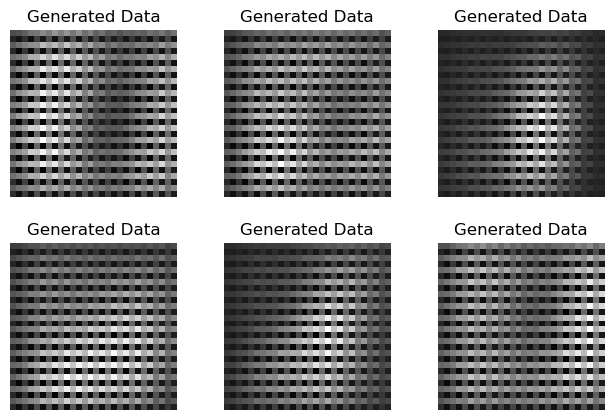

 11%|████████▉                                                                        | 33/300 [04:03<33:27,  7.52s/it]

Epoch [34/100] | D Loss: 0.5532 | G Loss: 0.6926


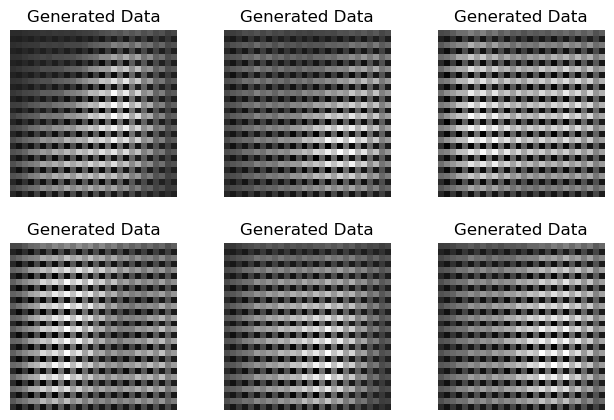

 11%|█████████▏                                                                       | 34/300 [04:10<32:30,  7.33s/it]

Epoch [35/100] | D Loss: 0.5532 | G Loss: 0.6931


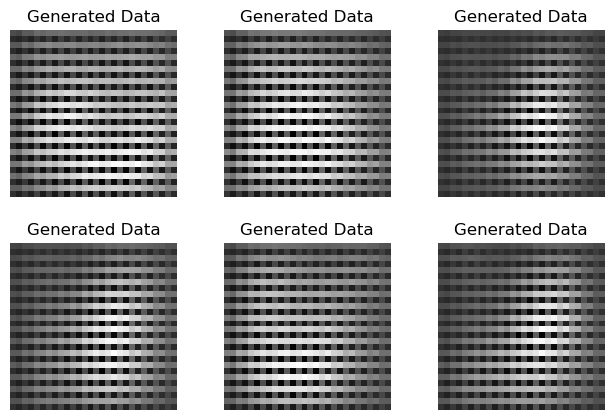

 12%|█████████▍                                                                       | 35/300 [04:18<33:28,  7.58s/it]

Epoch [36/100] | D Loss: 0.5532 | G Loss: 0.6931


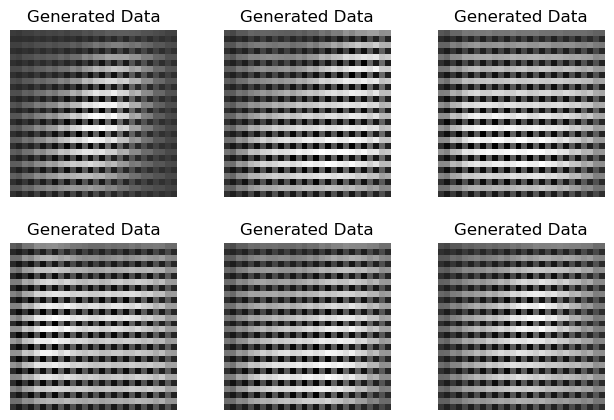

 12%|█████████▋                                                                       | 36/300 [04:25<32:21,  7.36s/it]

Epoch [37/100] | D Loss: 0.5532 | G Loss: 0.6931


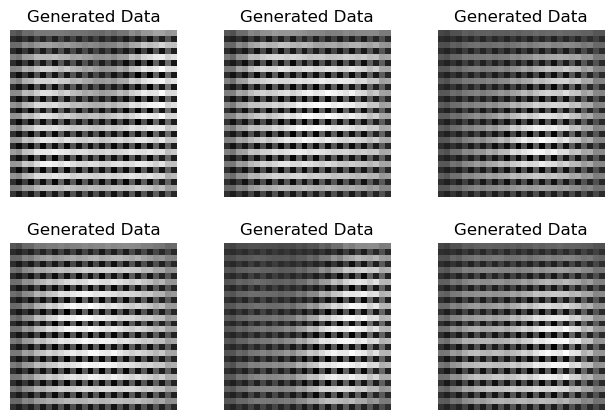

 12%|█████████▉                                                                       | 37/300 [04:33<32:58,  7.52s/it]

Epoch [38/100] | D Loss: 0.5532 | G Loss: 0.6931


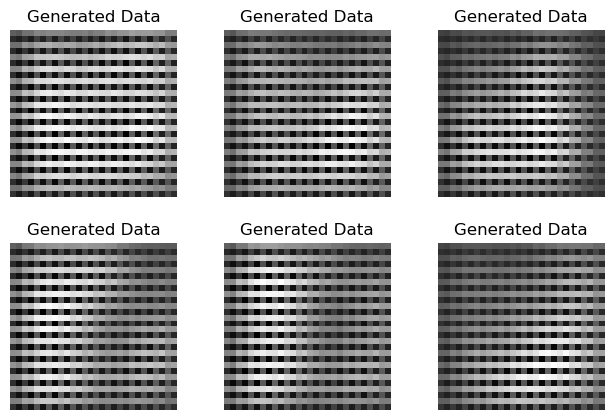

 13%|██████████▎                                                                      | 38/300 [04:39<31:55,  7.31s/it]

Epoch [39/100] | D Loss: 0.5532 | G Loss: 0.6931


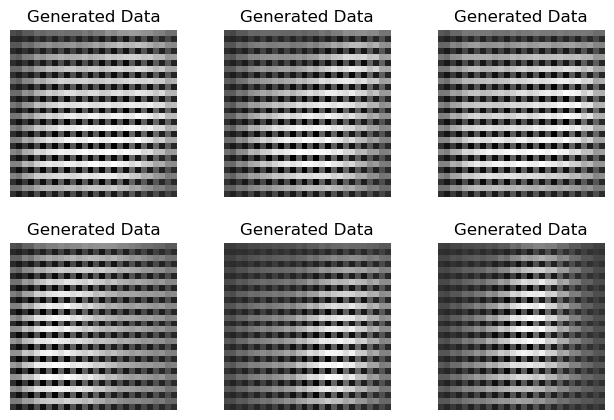

 13%|██████████▌                                                                      | 39/300 [04:47<32:36,  7.50s/it]

Epoch [40/100] | D Loss: 0.5532 | G Loss: 0.6931


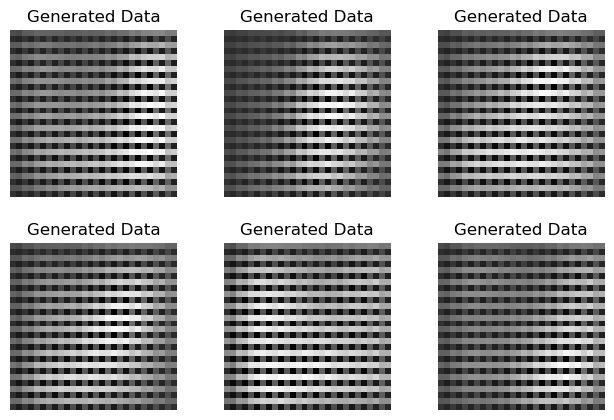

 13%|██████████▊                                                                      | 40/300 [04:55<32:01,  7.39s/it]

Epoch [41/100] | D Loss: 0.5532 | G Loss: 0.6931


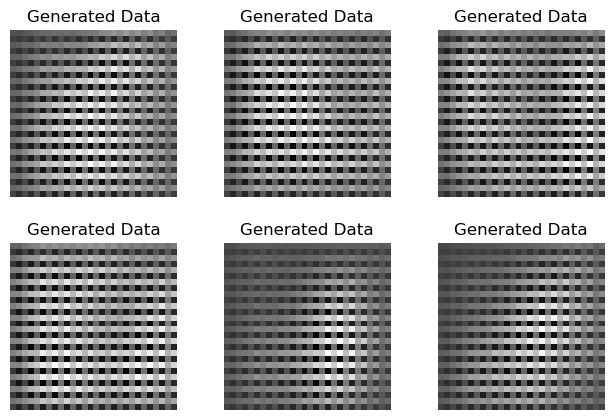

 14%|███████████                                                                      | 41/300 [05:02<32:34,  7.55s/it]

Epoch [42/100] | D Loss: 0.5533 | G Loss: 0.6931


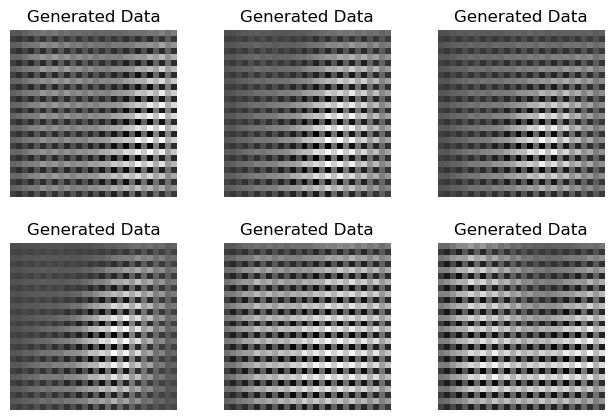

 14%|███████████▎                                                                     | 42/300 [05:09<31:37,  7.36s/it]

Epoch [43/100] | D Loss: 0.5532 | G Loss: 0.6931


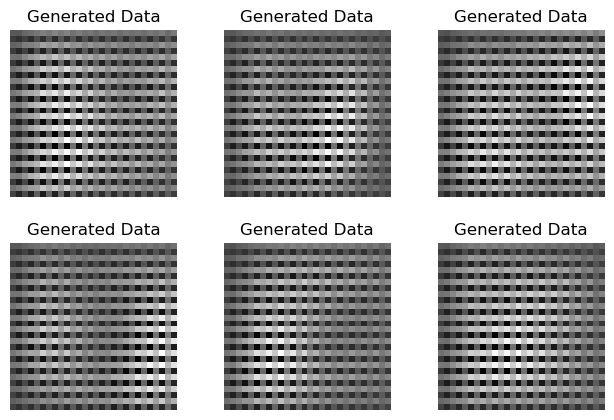

 14%|███████████▌                                                                     | 43/300 [05:17<32:15,  7.53s/it]

Epoch [44/100] | D Loss: 0.5534 | G Loss: 0.6931


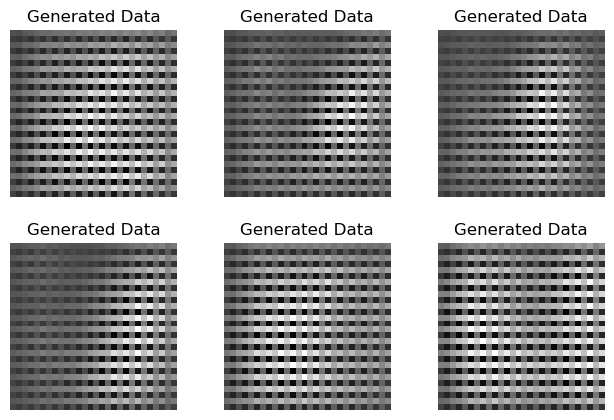

 15%|███████████▉                                                                     | 44/300 [05:24<31:20,  7.34s/it]

Epoch [45/100] | D Loss: 0.5534 | G Loss: 0.6931


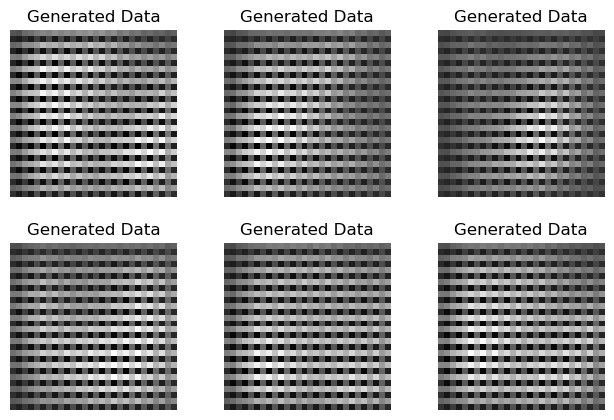

 15%|████████████▏                                                                    | 45/300 [05:32<32:18,  7.60s/it]

Epoch [46/100] | D Loss: 0.5532 | G Loss: 0.6931


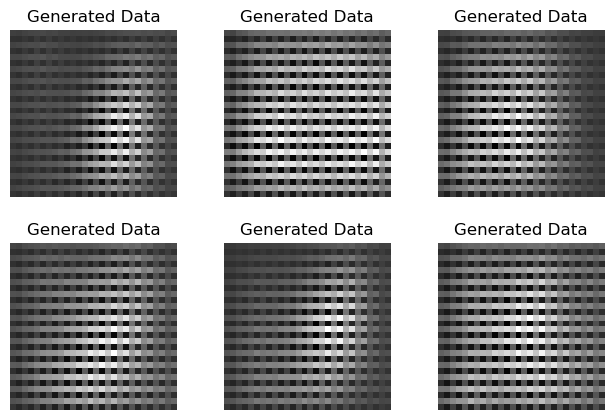

 15%|████████████▍                                                                    | 46/300 [05:39<31:16,  7.39s/it]

Epoch [47/100] | D Loss: 0.5569 | G Loss: 0.6931


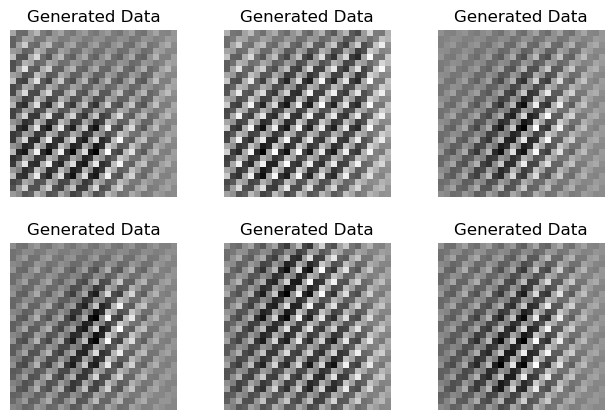

 16%|████████████▋                                                                    | 47/300 [05:47<31:50,  7.55s/it]

Epoch [48/100] | D Loss: 0.5540 | G Loss: 0.6931


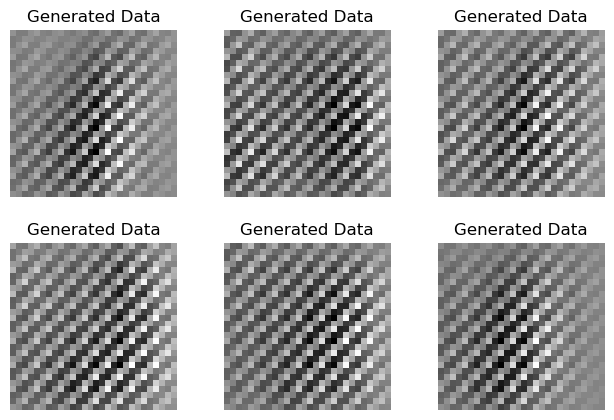

 16%|████████████▉                                                                    | 48/300 [05:54<30:59,  7.38s/it]

Epoch [49/100] | D Loss: 0.5573 | G Loss: 0.6931


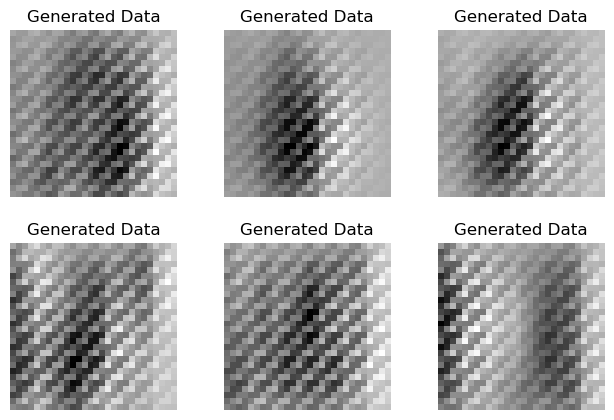

 16%|█████████████▏                                                                   | 49/300 [06:03<32:18,  7.72s/it]

Epoch [50/100] | D Loss: 0.5532 | G Loss: 0.6931


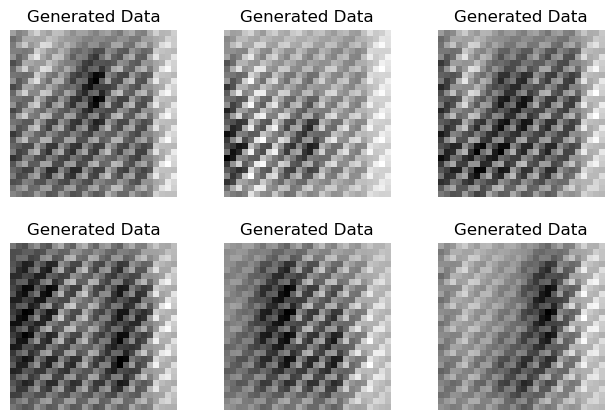

 17%|█████████████▌                                                                   | 50/300 [06:10<31:20,  7.52s/it]

Epoch [51/100] | D Loss: 0.5578 | G Loss: 0.6899


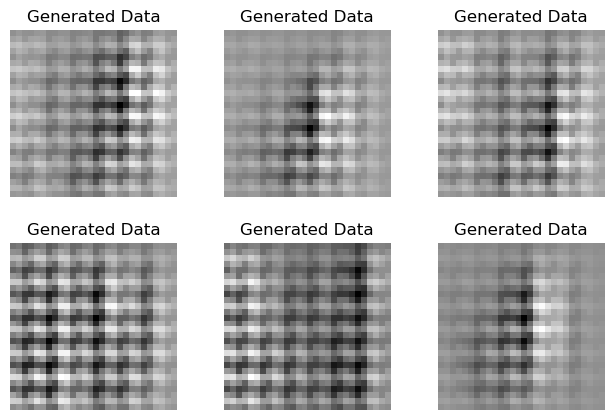

 17%|█████████████▊                                                                   | 51/300 [06:18<31:58,  7.71s/it]

Epoch [52/100] | D Loss: 0.5533 | G Loss: 0.6899


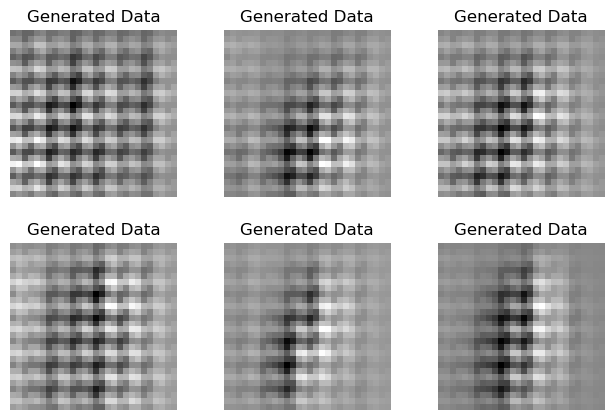

 17%|██████████████                                                                   | 52/300 [06:25<31:05,  7.52s/it]

Epoch [53/100] | D Loss: 0.5534 | G Loss: 0.6925


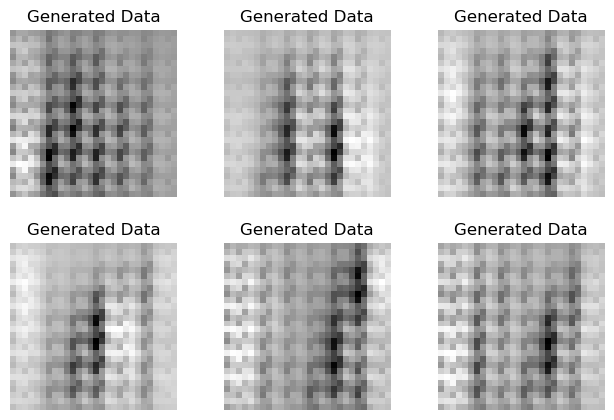

 18%|██████████████▎                                                                  | 53/300 [06:33<31:44,  7.71s/it]

Epoch [54/100] | D Loss: 0.5533 | G Loss: 0.6925


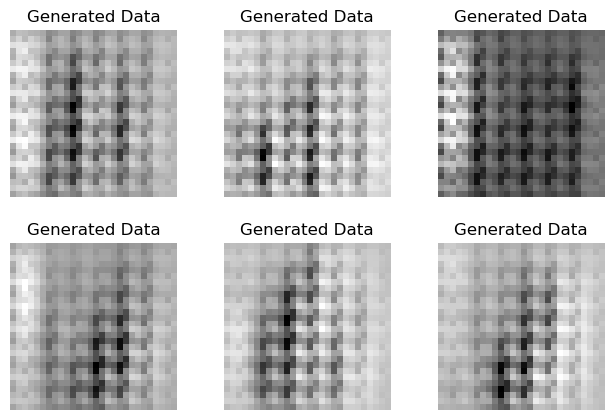

 18%|██████████████▌                                                                  | 54/300 [06:41<31:10,  7.60s/it]

Epoch [55/100] | D Loss: 0.6502 | G Loss: 0.6499


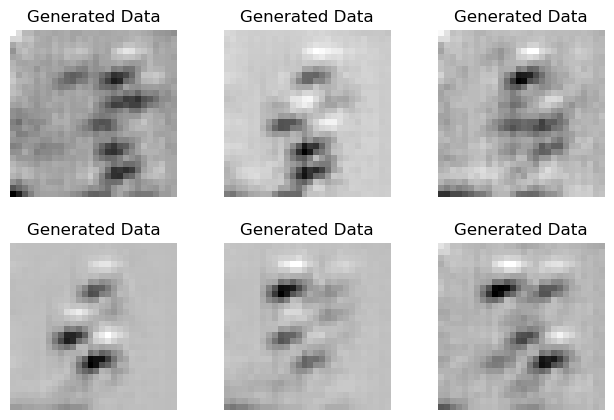

 18%|██████████████▊                                                                  | 55/300 [06:49<31:36,  7.74s/it]

Epoch [56/100] | D Loss: 0.5586 | G Loss: 0.6499


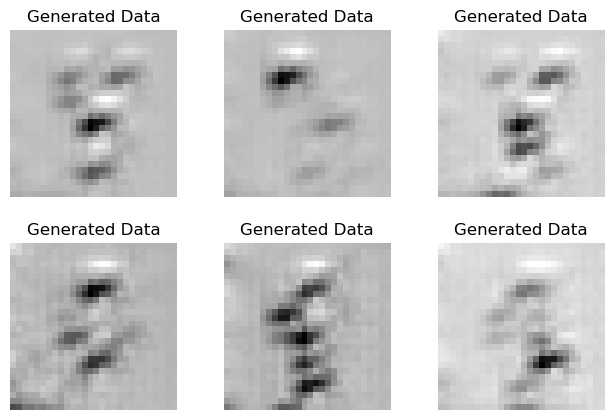

 19%|███████████████                                                                  | 56/300 [06:55<30:28,  7.50s/it]

Epoch [57/100] | D Loss: 0.5850 | G Loss: 0.6729


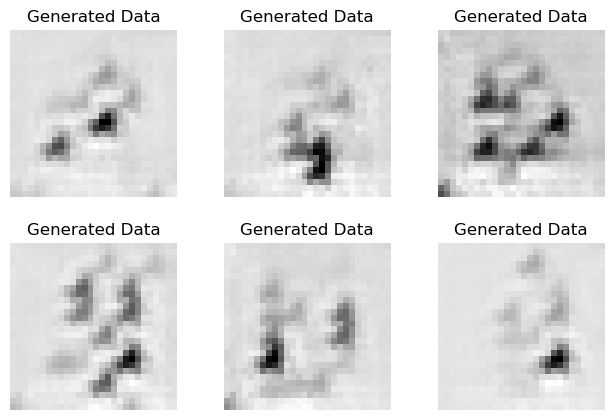

 19%|███████████████▍                                                                 | 57/300 [07:03<30:56,  7.64s/it]

Epoch [58/100] | D Loss: 0.5590 | G Loss: 0.6729


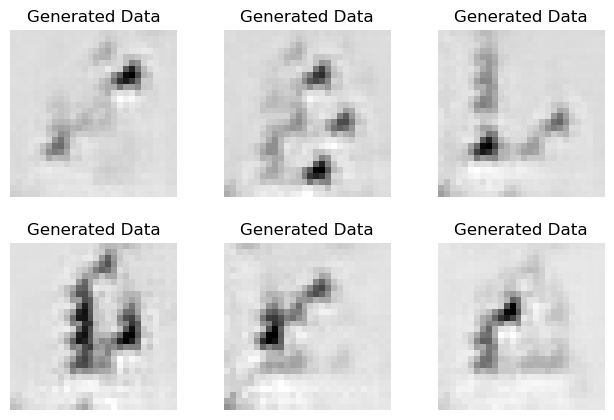

 19%|███████████████▋                                                                 | 58/300 [07:10<30:02,  7.45s/it]

Epoch [59/100] | D Loss: 0.5861 | G Loss: 0.6745


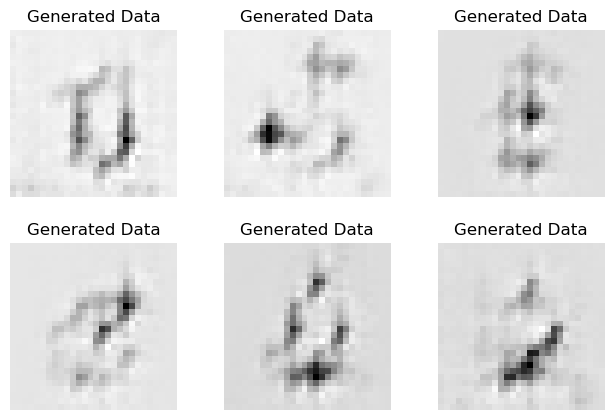

 20%|███████████████▉                                                                 | 59/300 [07:19<31:32,  7.85s/it]

Epoch [60/100] | D Loss: 0.5618 | G Loss: 0.6745


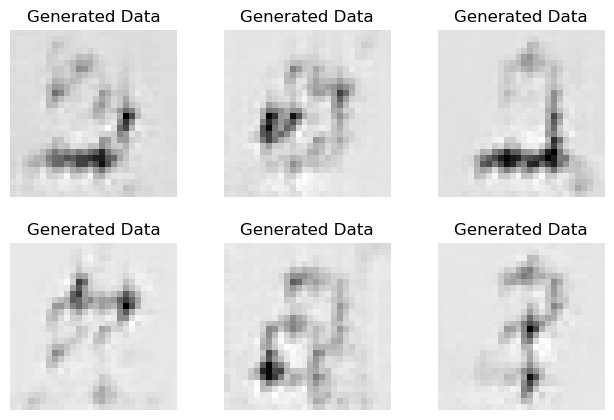

 20%|████████████████▏                                                                | 60/300 [07:26<30:32,  7.63s/it]

Epoch [61/100] | D Loss: 0.5699 | G Loss: 0.6786


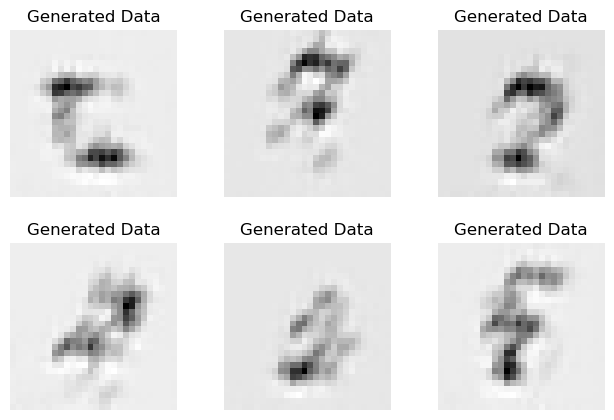

 20%|████████████████▍                                                                | 61/300 [07:34<30:50,  7.74s/it]

Epoch [62/100] | D Loss: 0.5586 | G Loss: 0.6786


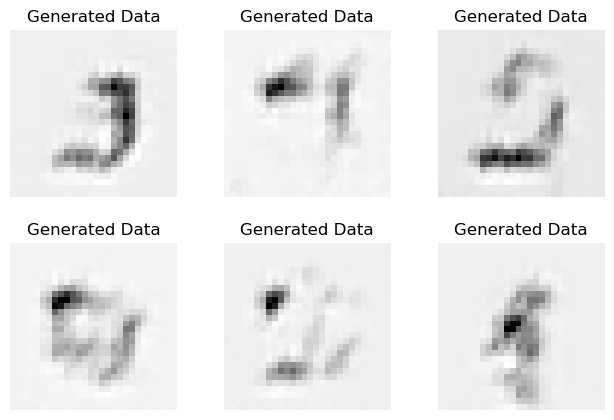

 21%|████████████████▋                                                                | 62/300 [07:41<29:57,  7.55s/it]

Epoch [63/100] | D Loss: 0.5648 | G Loss: 0.6814


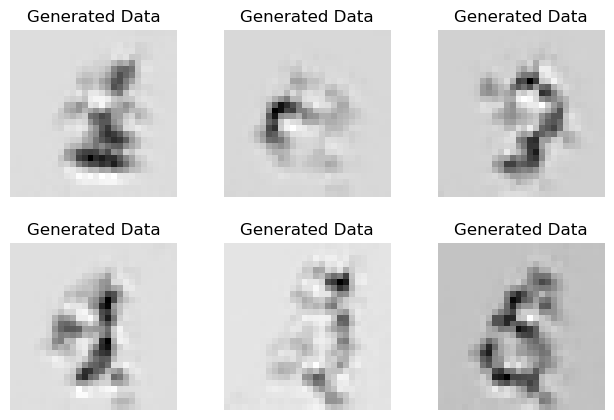

 21%|█████████████████                                                                | 63/300 [07:50<30:41,  7.77s/it]

Epoch [64/100] | D Loss: 0.5569 | G Loss: 0.6814


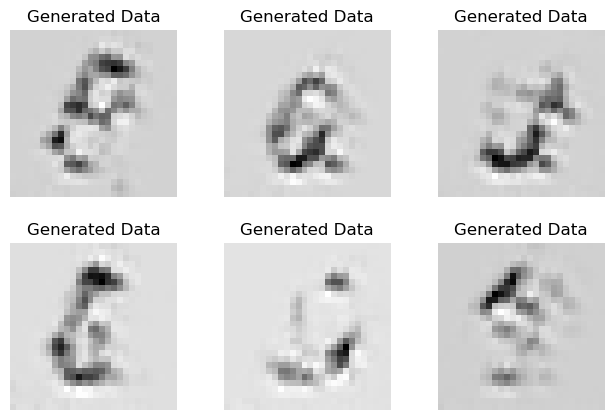

 21%|█████████████████▎                                                               | 64/300 [07:57<29:37,  7.53s/it]

Epoch [65/100] | D Loss: 0.5607 | G Loss: 0.6863


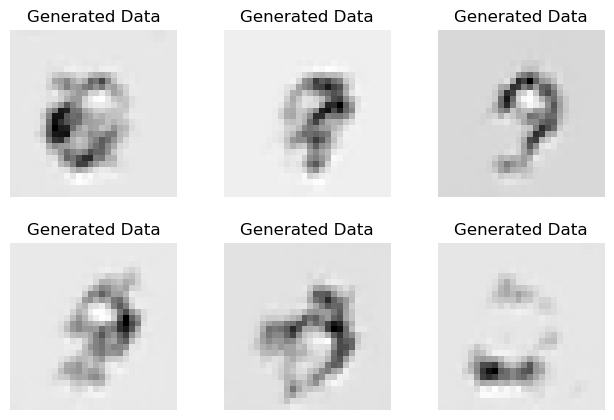

 22%|█████████████████▌                                                               | 65/300 [08:05<30:01,  7.67s/it]

Epoch [66/100] | D Loss: 0.5582 | G Loss: 0.6863


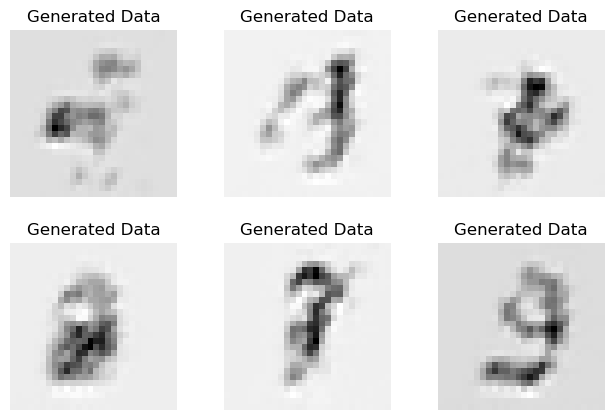

 22%|█████████████████▊                                                               | 66/300 [08:12<29:09,  7.48s/it]

Epoch [67/100] | D Loss: 0.5626 | G Loss: 0.6829


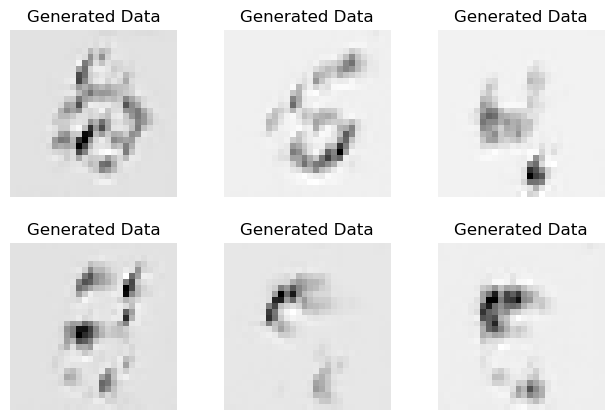

 22%|██████████████████                                                               | 67/300 [08:20<29:37,  7.63s/it]

Epoch [68/100] | D Loss: 0.5604 | G Loss: 0.6829


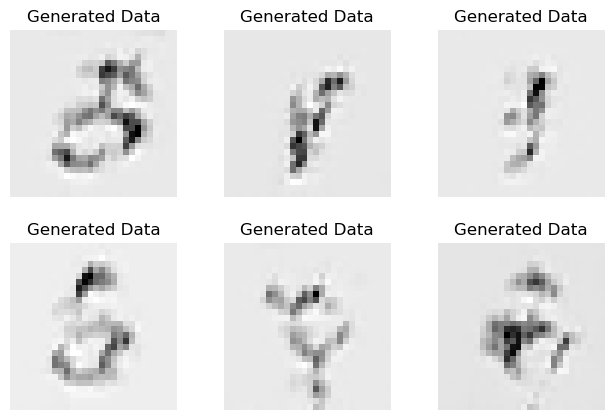

 23%|██████████████████▎                                                              | 68/300 [08:27<29:08,  7.53s/it]

Epoch [69/100] | D Loss: 0.5599 | G Loss: 0.6923


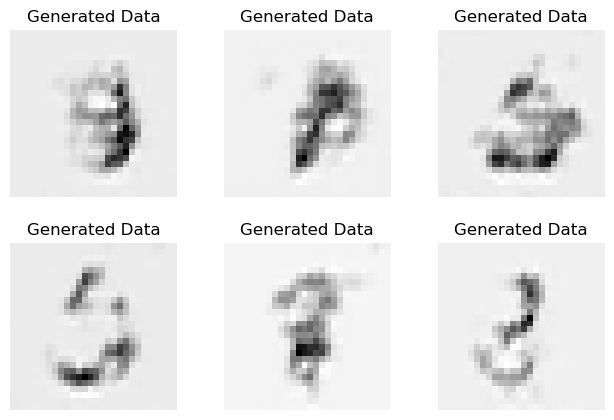

 23%|██████████████████▋                                                              | 69/300 [08:35<29:34,  7.68s/it]

Epoch [70/100] | D Loss: 0.5590 | G Loss: 0.6923


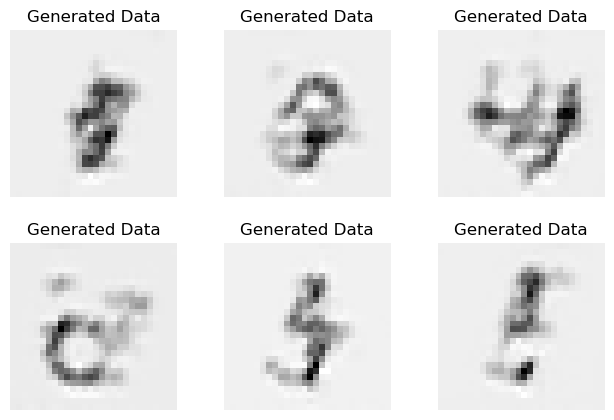

 23%|██████████████████▉                                                              | 70/300 [08:42<28:42,  7.49s/it]

Epoch [71/100] | D Loss: 0.5566 | G Loss: 0.6916


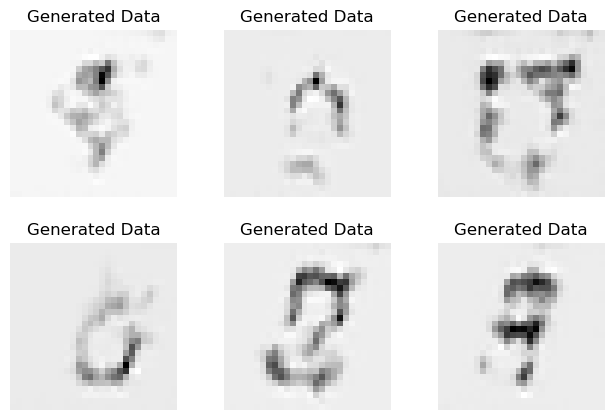

 24%|███████████████████▏                                                             | 71/300 [08:50<29:07,  7.63s/it]

Epoch [72/100] | D Loss: 0.5575 | G Loss: 0.6916


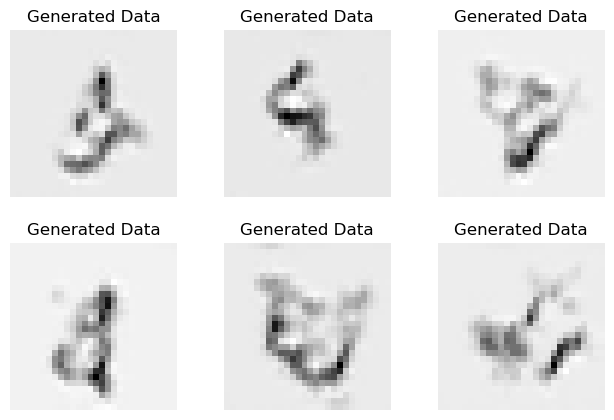

 24%|███████████████████▍                                                             | 72/300 [08:57<28:13,  7.43s/it]

Epoch [73/100] | D Loss: 0.5645 | G Loss: 0.6881


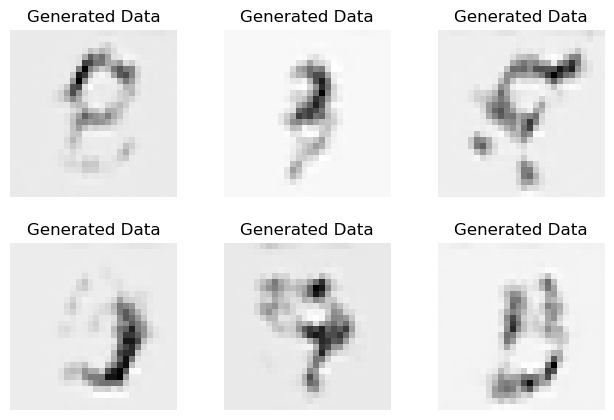

 24%|███████████████████▋                                                             | 73/300 [09:06<29:30,  7.80s/it]

Epoch [74/100] | D Loss: 0.5601 | G Loss: 0.6881


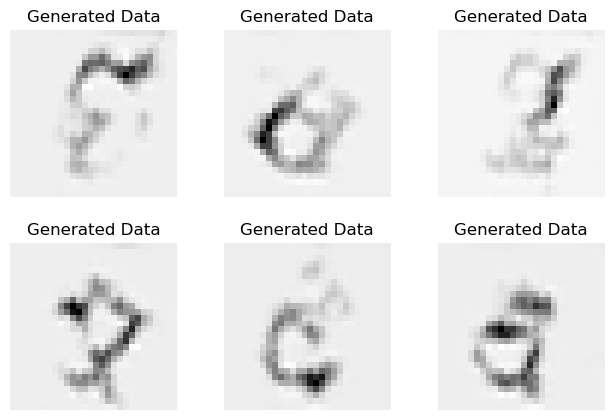

 25%|███████████████████▉                                                             | 74/300 [09:14<29:42,  7.89s/it]

Epoch [75/100] | D Loss: 0.5565 | G Loss: 0.6860


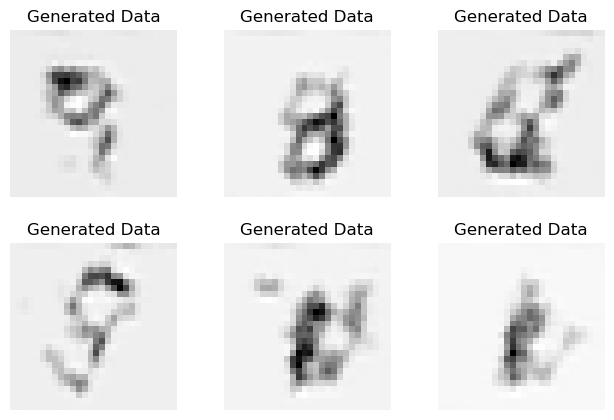

 25%|████████████████████▎                                                            | 75/300 [09:23<31:19,  8.35s/it]

Epoch [76/100] | D Loss: 0.5607 | G Loss: 0.6860


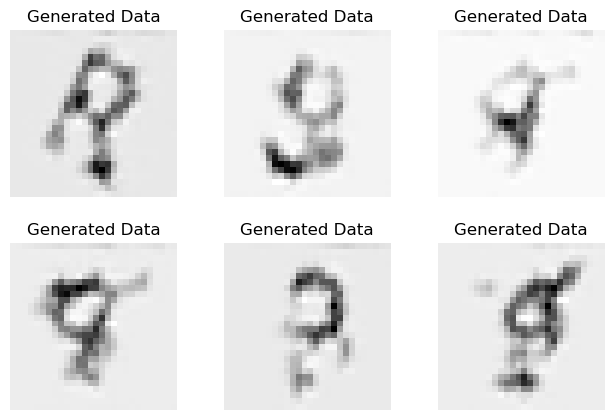

 25%|████████████████████▌                                                            | 76/300 [09:31<30:43,  8.23s/it]

Epoch [77/100] | D Loss: 0.5592 | G Loss: 0.6909


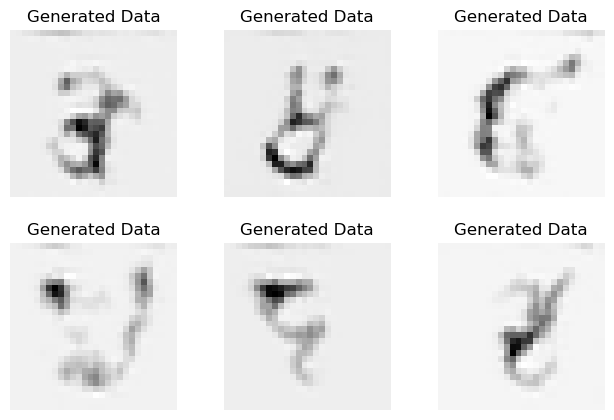

 26%|████████████████████▊                                                            | 77/300 [09:41<32:39,  8.79s/it]

Epoch [78/100] | D Loss: 0.5552 | G Loss: 0.6909


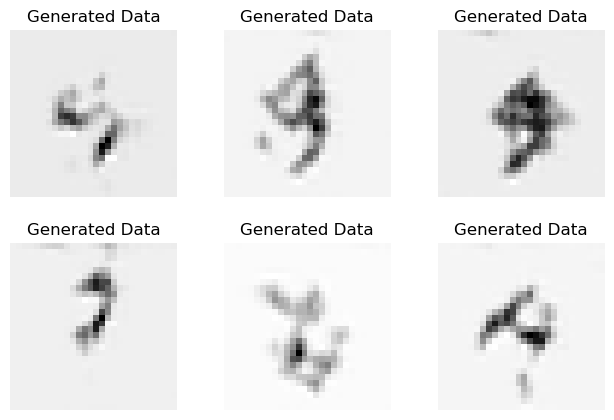

 26%|█████████████████████                                                            | 78/300 [09:49<31:05,  8.40s/it]

Epoch [79/100] | D Loss: 0.5577 | G Loss: 0.6899


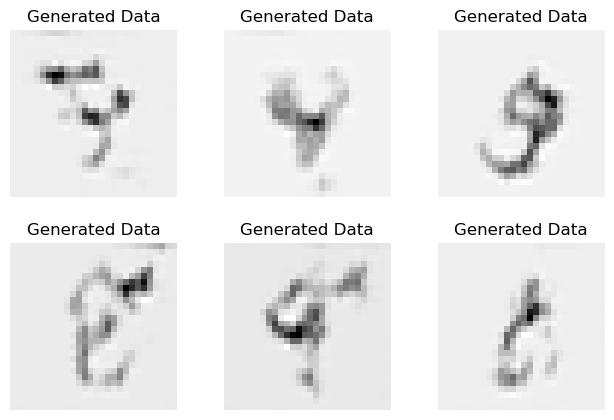

 26%|█████████████████████▎                                                           | 79/300 [09:58<31:20,  8.51s/it]

Epoch [80/100] | D Loss: 0.5571 | G Loss: 0.6899


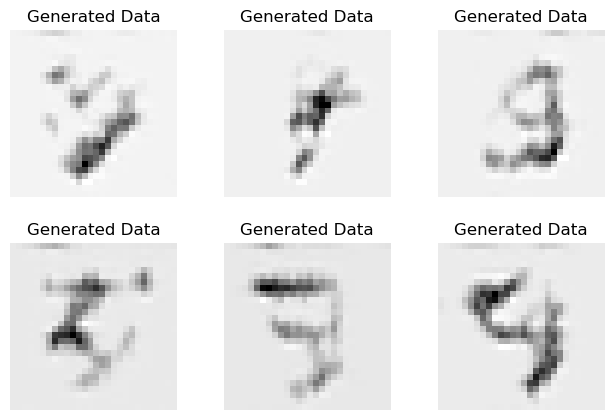

 27%|█████████████████████▌                                                           | 80/300 [10:05<30:07,  8.22s/it]

Epoch [81/100] | D Loss: 0.5613 | G Loss: 0.6910


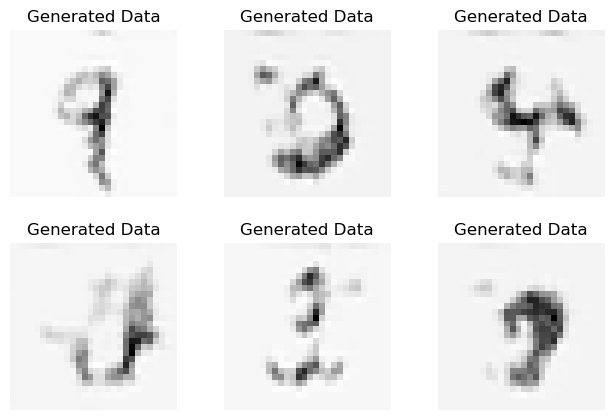

 27%|█████████████████████▊                                                           | 81/300 [10:14<30:16,  8.29s/it]

Epoch [82/100] | D Loss: 0.5570 | G Loss: 0.6910


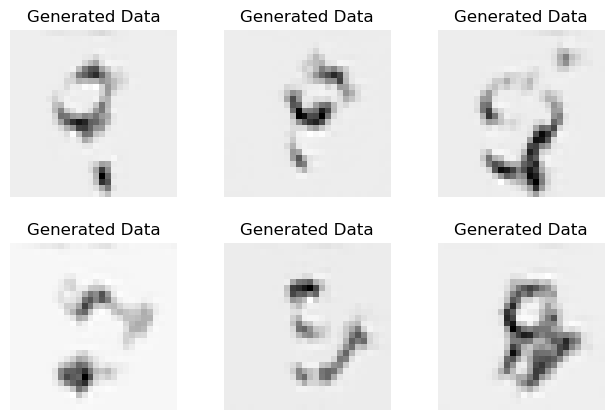

 27%|██████████████████████▏                                                          | 82/300 [10:21<29:06,  8.01s/it]

Epoch [83/100] | D Loss: 0.5589 | G Loss: 0.6875


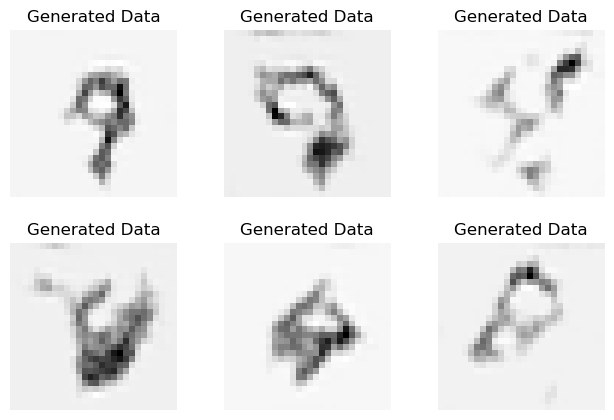

 28%|██████████████████████▍                                                          | 83/300 [10:29<29:07,  8.05s/it]

Epoch [84/100] | D Loss: 0.5553 | G Loss: 0.6875


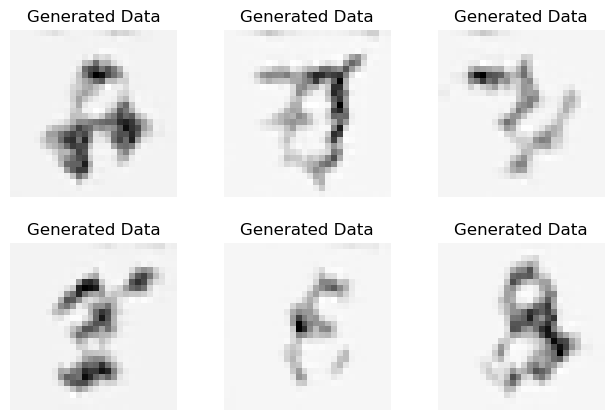

 28%|██████████████████████▋                                                          | 84/300 [10:36<27:55,  7.76s/it]

Epoch [85/100] | D Loss: 0.5546 | G Loss: 0.6927


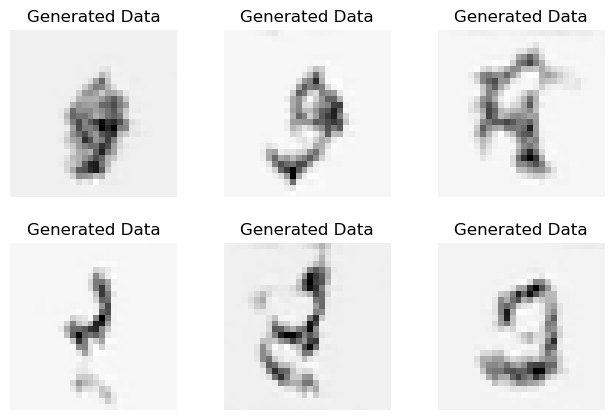

 28%|██████████████████████▉                                                          | 85/300 [10:44<28:11,  7.87s/it]

Epoch [86/100] | D Loss: 0.5570 | G Loss: 0.6927


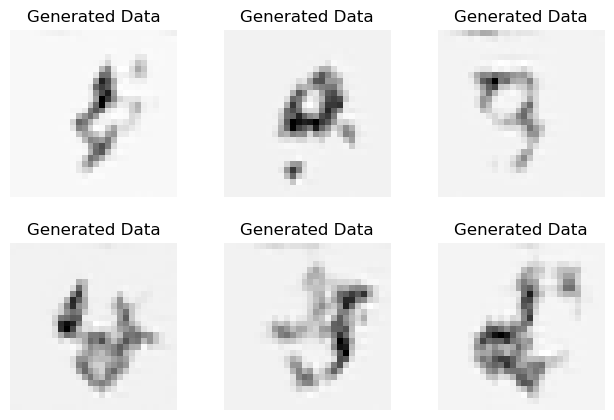

 29%|███████████████████████▏                                                         | 86/300 [10:51<27:09,  7.61s/it]

Epoch [87/100] | D Loss: 0.5582 | G Loss: 0.6931


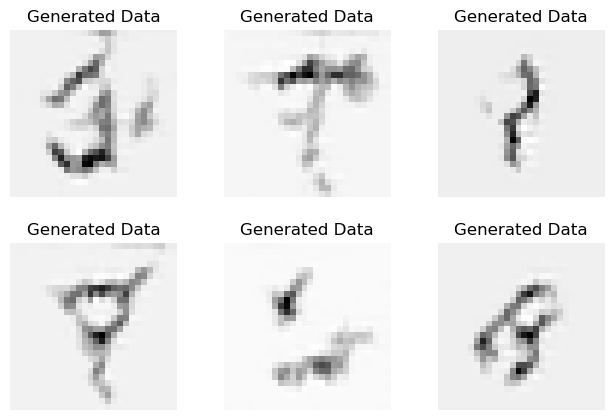

 29%|███████████████████████▍                                                         | 87/300 [11:00<27:49,  7.84s/it]

Epoch [88/100] | D Loss: 0.5570 | G Loss: 0.6931


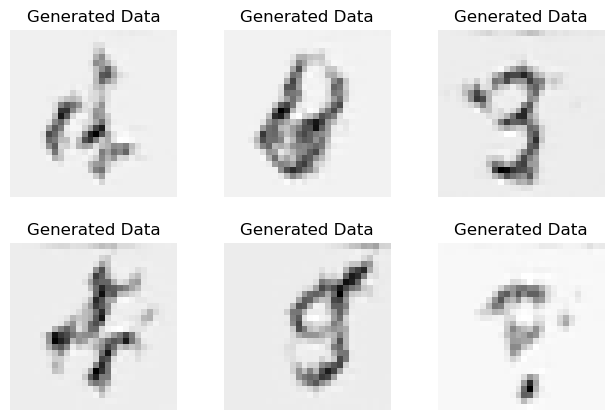

 29%|███████████████████████▊                                                         | 88/300 [11:07<26:53,  7.61s/it]

Epoch [89/100] | D Loss: 0.5585 | G Loss: 0.6909


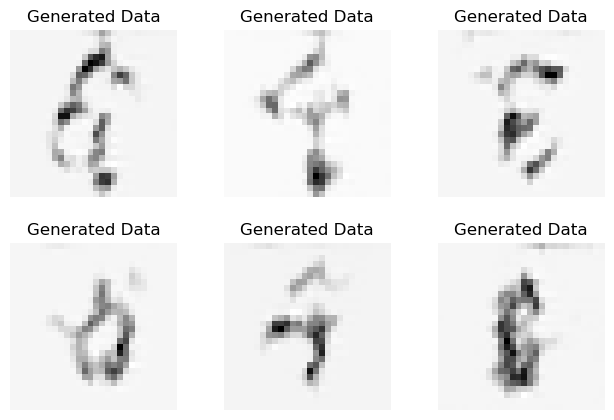

 30%|████████████████████████                                                         | 89/300 [11:15<27:14,  7.75s/it]

Epoch [90/100] | D Loss: 0.5586 | G Loss: 0.6909


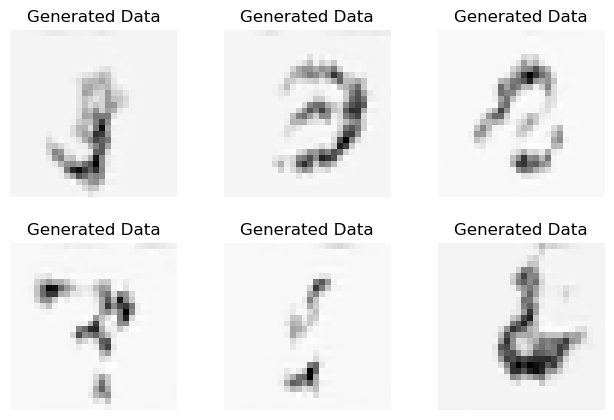

 30%|████████████████████████▎                                                        | 90/300 [11:22<26:25,  7.55s/it]

Epoch [91/100] | D Loss: 0.5596 | G Loss: 0.6926


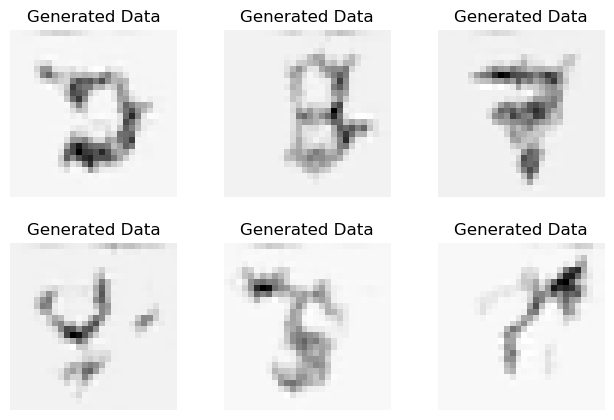

 30%|████████████████████████▌                                                        | 91/300 [11:30<27:13,  7.82s/it]

Epoch [92/100] | D Loss: 0.5537 | G Loss: 0.6926


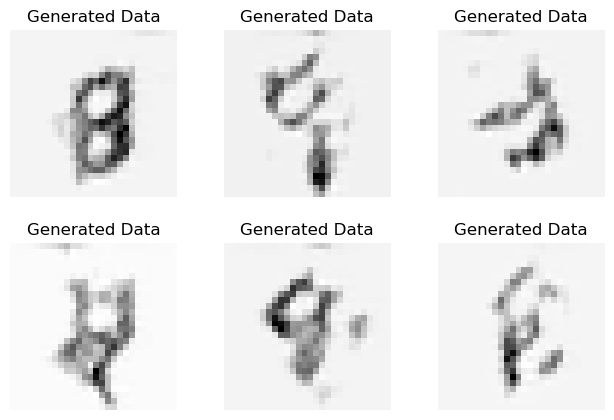

 31%|████████████████████████▊                                                        | 92/300 [11:38<26:31,  7.65s/it]

Epoch [93/100] | D Loss: 0.5574 | G Loss: 0.6910


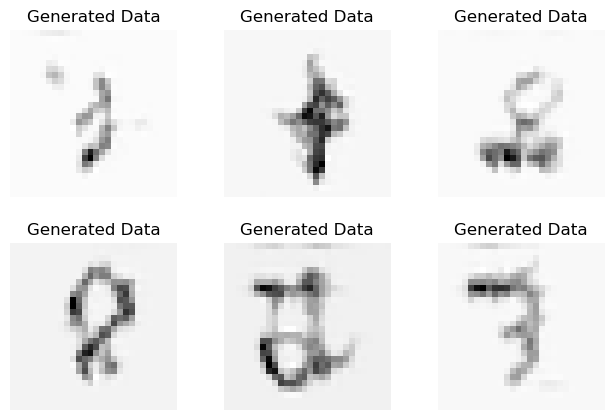

 31%|█████████████████████████                                                        | 93/300 [11:46<27:00,  7.83s/it]

Epoch [94/100] | D Loss: 0.5580 | G Loss: 0.6910


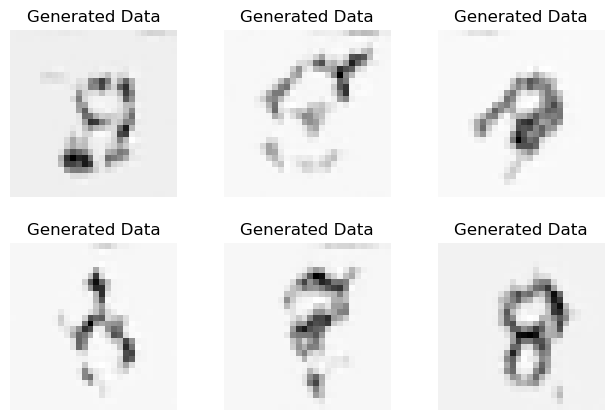

 31%|█████████████████████████▍                                                       | 94/300 [11:53<26:03,  7.59s/it]

Epoch [95/100] | D Loss: 0.5586 | G Loss: 0.6904


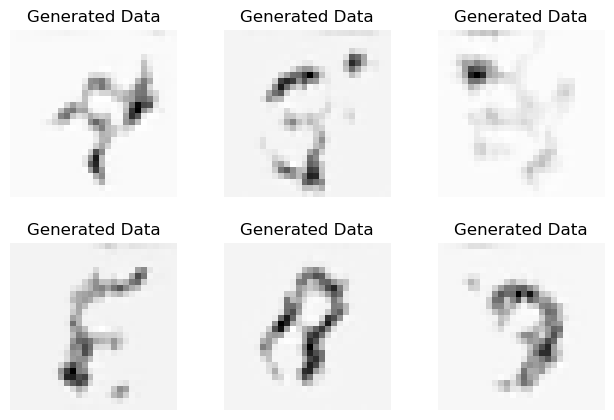

 32%|█████████████████████████▋                                                       | 95/300 [12:01<26:30,  7.76s/it]

Epoch [96/100] | D Loss: 0.5566 | G Loss: 0.6904


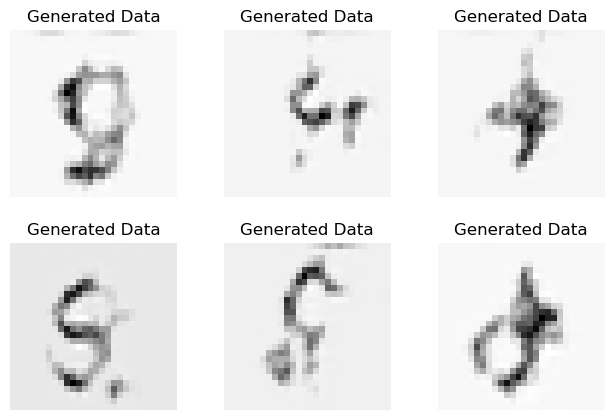

 32%|█████████████████████████▉                                                       | 96/300 [12:08<25:54,  7.62s/it]

Epoch [97/100] | D Loss: 0.5567 | G Loss: 0.6930


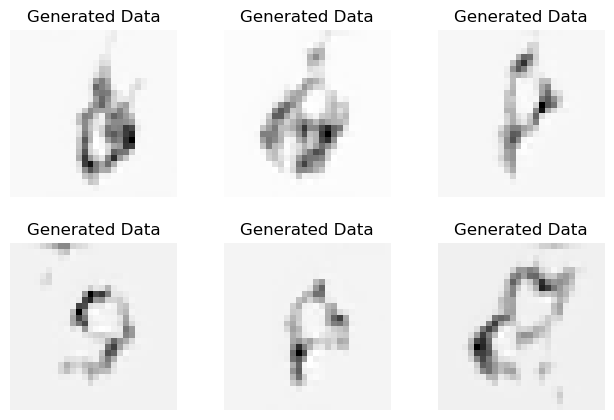

 32%|██████████████████████████▏                                                      | 97/300 [12:16<26:20,  7.79s/it]

Epoch [98/100] | D Loss: 0.5546 | G Loss: 0.6930


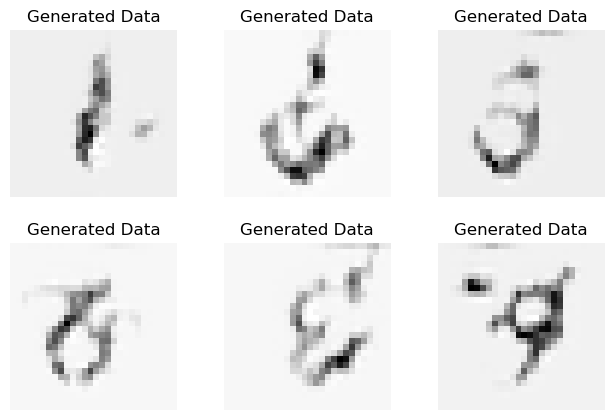

 33%|██████████████████████████▍                                                      | 98/300 [12:24<25:29,  7.57s/it]

Epoch [99/100] | D Loss: 0.5563 | G Loss: 0.6845


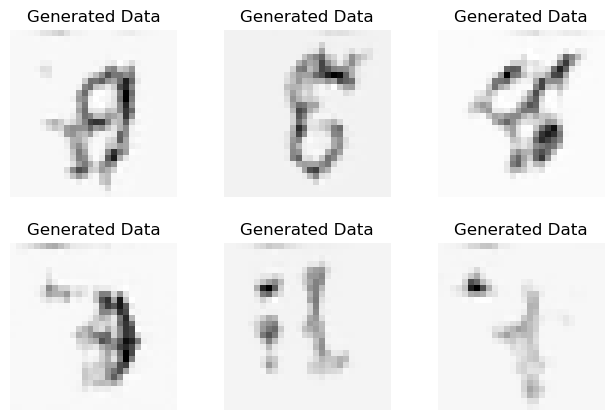

 33%|██████████████████████████▋                                                      | 99/300 [12:32<25:54,  7.73s/it]

Epoch [100/100] | D Loss: 0.5557 | G Loss: 0.6845


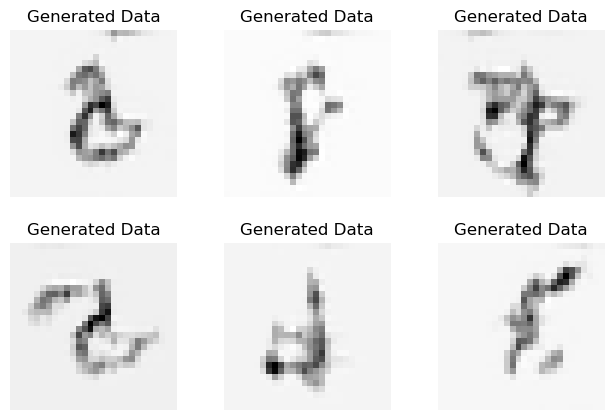

 33%|██████████████████████████▋                                                     | 100/300 [12:39<25:07,  7.54s/it]

Epoch [101/100] | D Loss: 0.5587 | G Loss: 0.6923


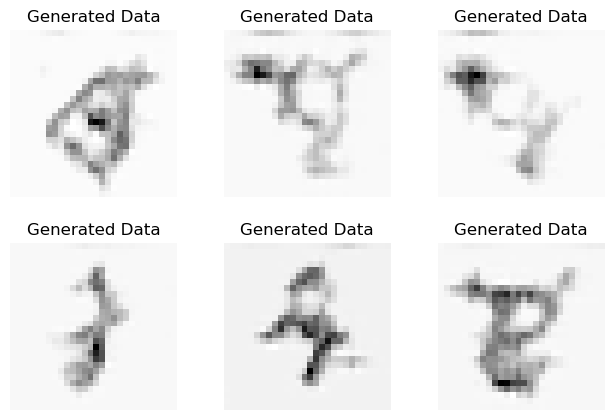

 34%|██████████████████████████▉                                                     | 101/300 [12:47<25:44,  7.76s/it]

Epoch [102/100] | D Loss: 0.5551 | G Loss: 0.6923


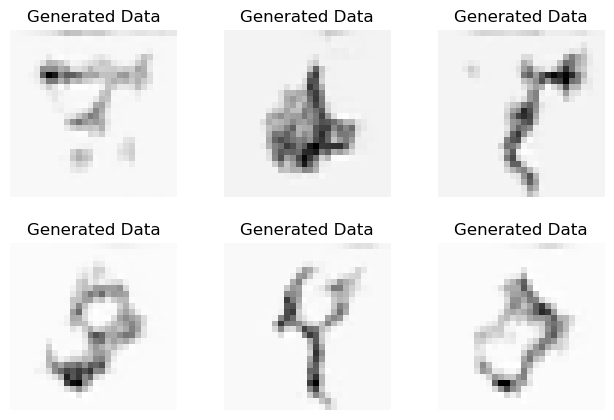

 34%|███████████████████████████▏                                                    | 102/300 [12:54<24:52,  7.54s/it]

Epoch [103/100] | D Loss: 0.5600 | G Loss: 0.6925


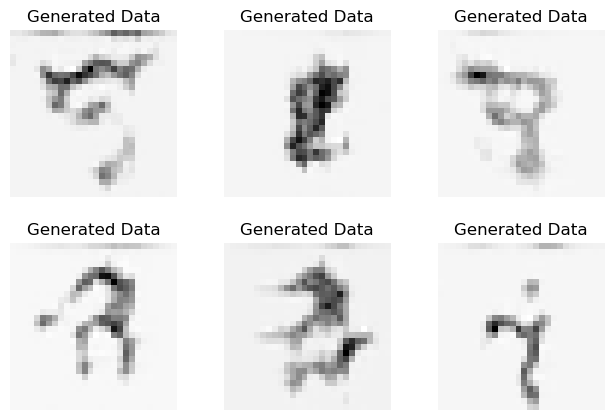

 34%|███████████████████████████▍                                                    | 103/300 [13:02<25:16,  7.70s/it]

Epoch [104/100] | D Loss: 0.5578 | G Loss: 0.6925


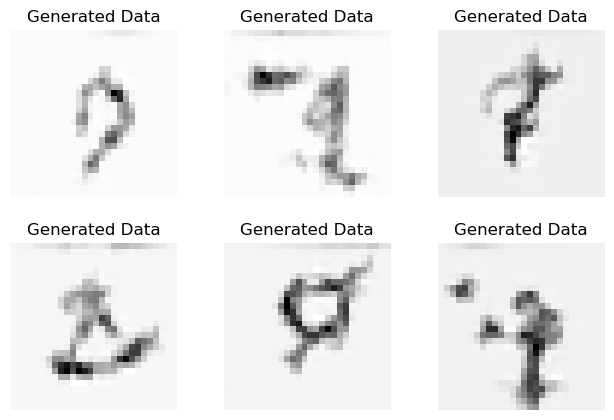

 35%|███████████████████████████▋                                                    | 104/300 [13:09<24:28,  7.49s/it]

Epoch [105/100] | D Loss: 0.5563 | G Loss: 0.6914


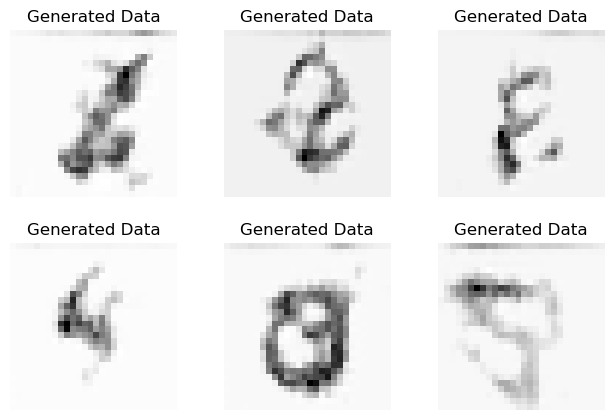

 35%|████████████████████████████                                                    | 105/300 [13:17<25:11,  7.75s/it]

Epoch [106/100] | D Loss: 0.5566 | G Loss: 0.6914


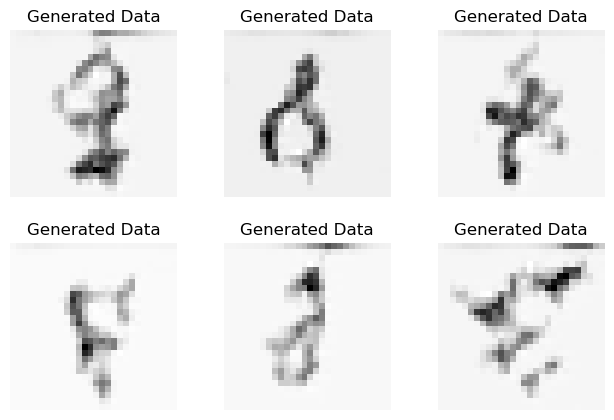

 35%|████████████████████████████▎                                                   | 106/300 [13:24<24:22,  7.54s/it]

Epoch [107/100] | D Loss: 0.5545 | G Loss: 0.6905


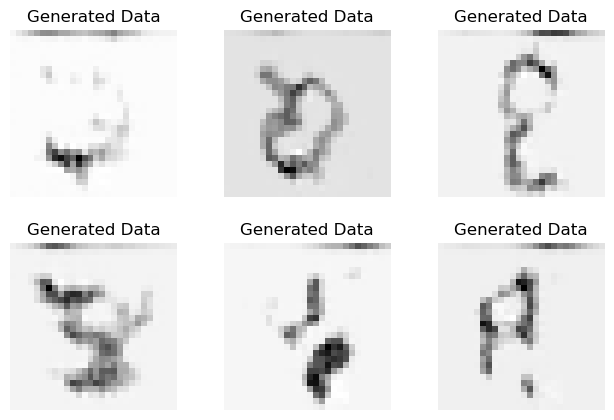

 36%|████████████████████████████▌                                                   | 107/300 [13:33<24:48,  7.71s/it]

Epoch [108/100] | D Loss: 0.5567 | G Loss: 0.6905


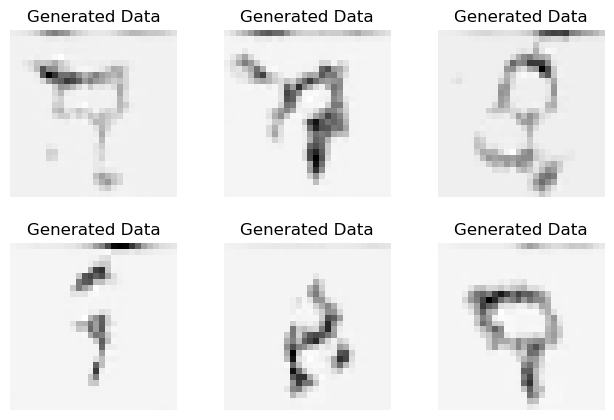

 36%|████████████████████████████▊                                                   | 108/300 [13:40<24:01,  7.51s/it]

Epoch [109/100] | D Loss: 0.5572 | G Loss: 0.6930


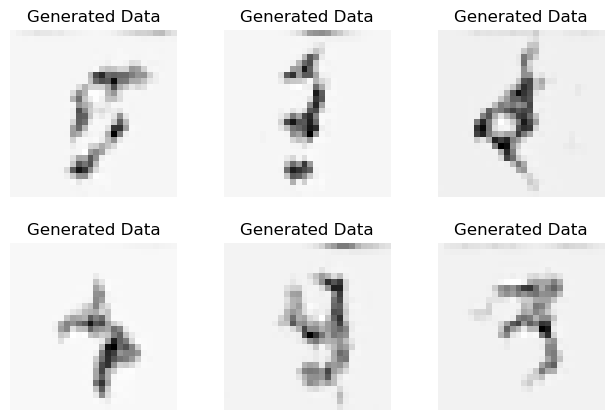

 36%|█████████████████████████████                                                   | 109/300 [13:48<24:37,  7.74s/it]

Epoch [110/100] | D Loss: 0.5592 | G Loss: 0.6930


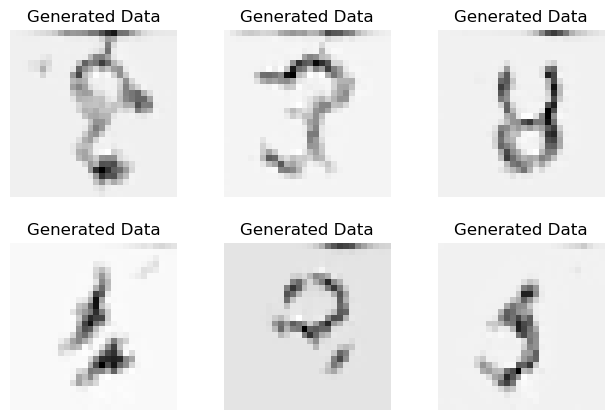

 37%|█████████████████████████████▎                                                  | 110/300 [13:55<24:21,  7.69s/it]

Epoch [111/100] | D Loss: 0.5572 | G Loss: 0.6901


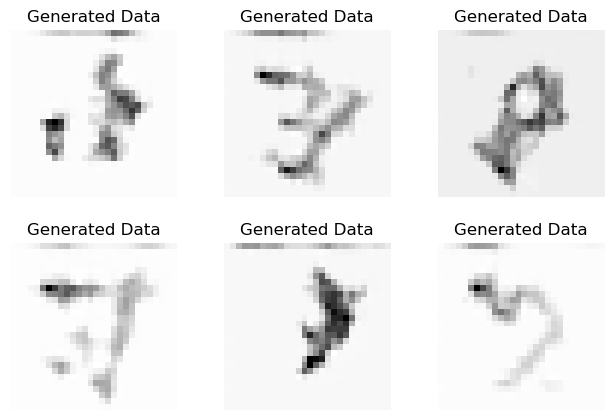

 37%|█████████████████████████████▌                                                  | 111/300 [14:04<24:51,  7.89s/it]

Epoch [112/100] | D Loss: 0.5544 | G Loss: 0.6901


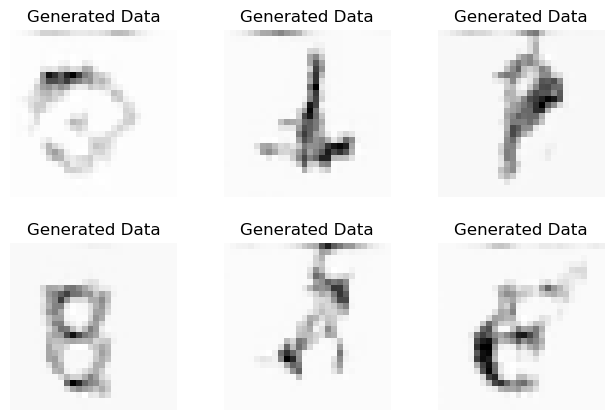

 37%|█████████████████████████████▊                                                  | 112/300 [14:11<23:58,  7.65s/it]

Epoch [113/100] | D Loss: 0.5551 | G Loss: 0.6878


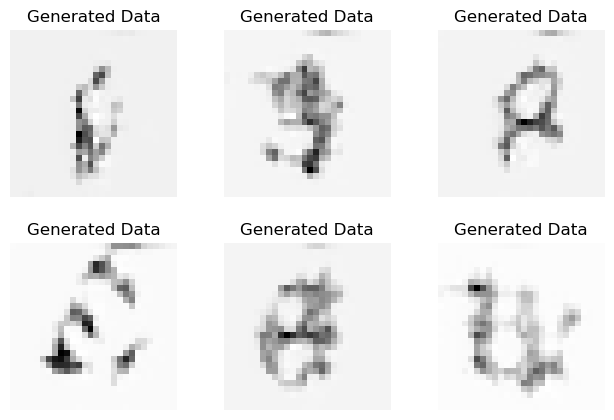

 38%|██████████████████████████████▏                                                 | 113/300 [14:19<24:25,  7.84s/it]

Epoch [114/100] | D Loss: 0.5547 | G Loss: 0.6878


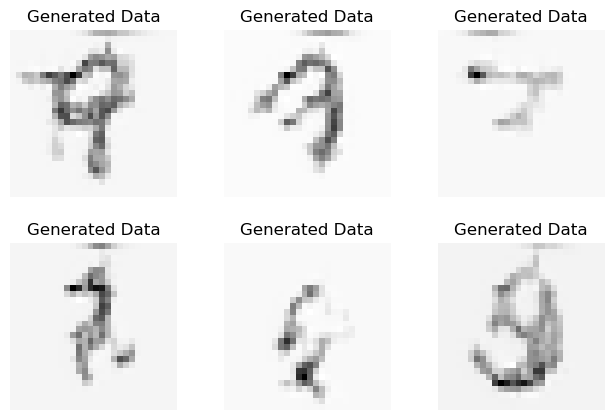

 38%|██████████████████████████████▍                                                 | 114/300 [14:26<23:41,  7.64s/it]

Epoch [115/100] | D Loss: 0.5551 | G Loss: 0.6799


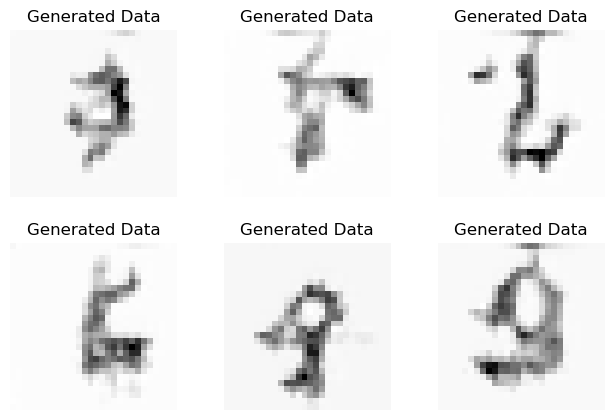

 38%|██████████████████████████████▋                                                 | 115/300 [14:35<24:15,  7.87s/it]

Epoch [116/100] | D Loss: 0.5570 | G Loss: 0.6799


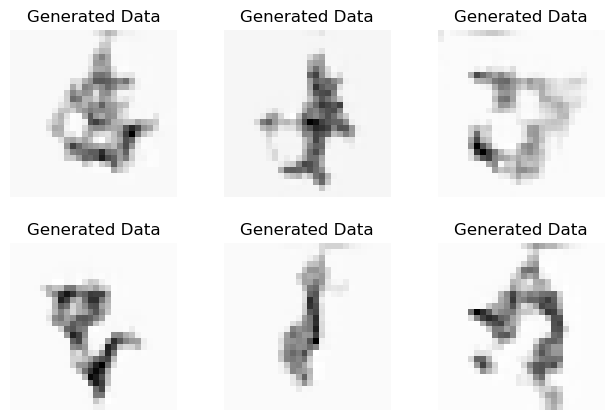

 39%|██████████████████████████████▉                                                 | 116/300 [14:42<23:26,  7.65s/it]

Epoch [117/100] | D Loss: 0.5589 | G Loss: 0.6884


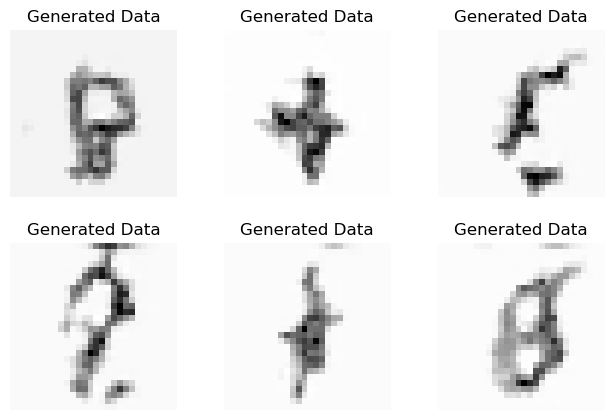

 39%|███████████████████████████████▏                                                | 117/300 [14:50<23:43,  7.78s/it]

Epoch [118/100] | D Loss: 0.5570 | G Loss: 0.6884


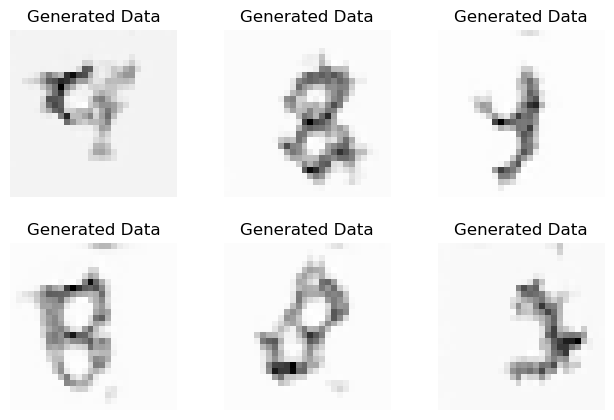

 39%|███████████████████████████████▍                                                | 118/300 [14:57<23:11,  7.65s/it]

Epoch [119/100] | D Loss: 0.5574 | G Loss: 0.6855


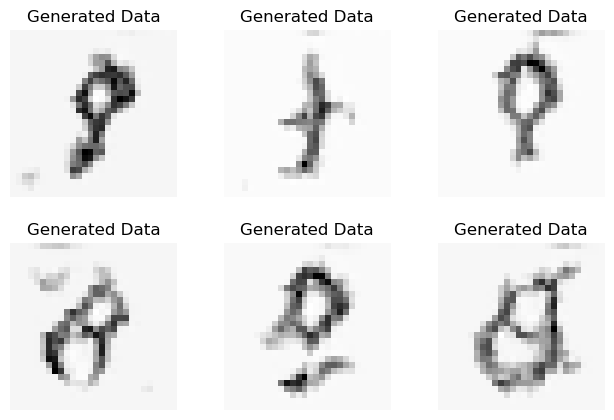

 40%|███████████████████████████████▋                                                | 119/300 [15:06<23:47,  7.88s/it]

Epoch [120/100] | D Loss: 0.5600 | G Loss: 0.6855


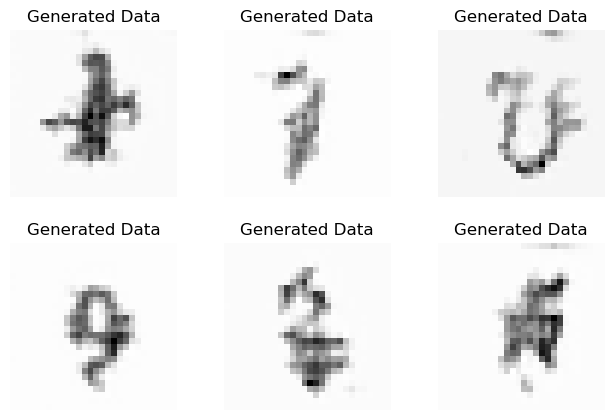

 40%|████████████████████████████████                                                | 120/300 [15:13<22:57,  7.65s/it]

Epoch [121/100] | D Loss: 0.5603 | G Loss: 0.6901


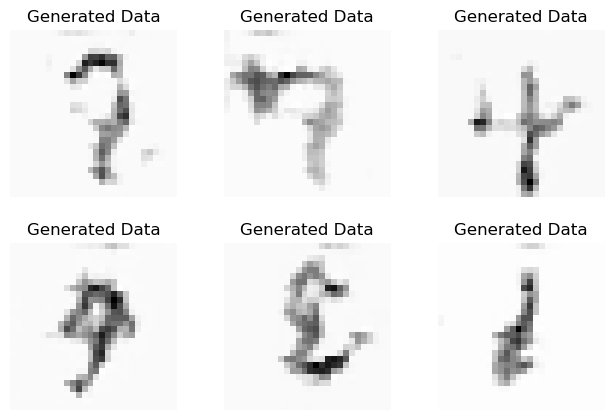

 40%|████████████████████████████████▎                                               | 121/300 [15:21<23:12,  7.78s/it]

Epoch [122/100] | D Loss: 0.5604 | G Loss: 0.6901


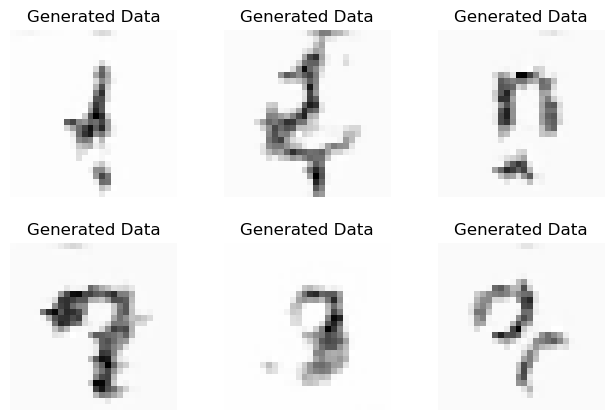

 41%|████████████████████████████████▌                                               | 122/300 [15:28<22:27,  7.57s/it]

Epoch [123/100] | D Loss: 0.5581 | G Loss: 0.6898


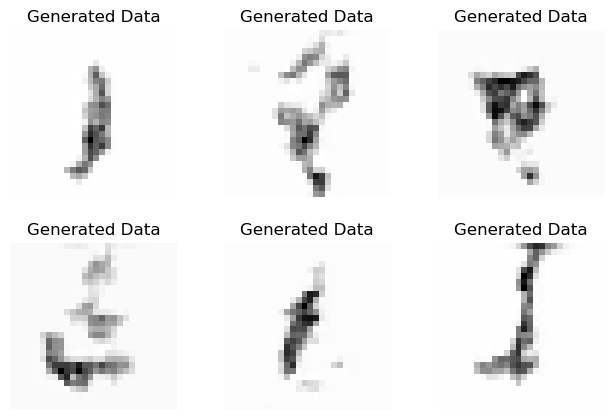

 41%|████████████████████████████████▊                                               | 123/300 [15:36<22:49,  7.74s/it]

Epoch [124/100] | D Loss: 0.5587 | G Loss: 0.6898


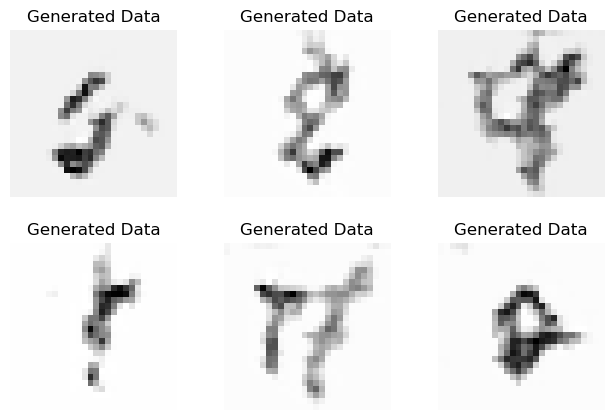

 41%|█████████████████████████████████                                               | 124/300 [15:43<22:17,  7.60s/it]

Epoch [125/100] | D Loss: 0.5569 | G Loss: 0.6891


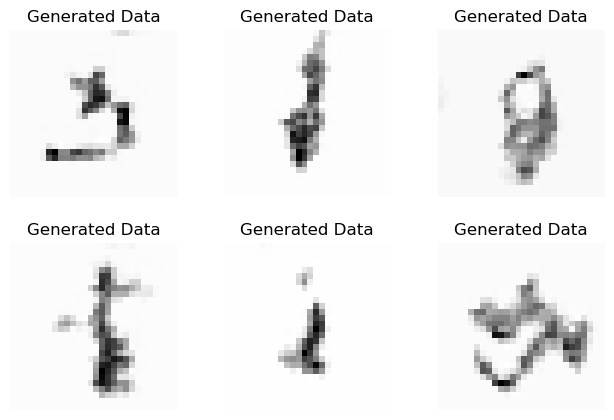

 42%|█████████████████████████████████▎                                              | 125/300 [15:52<22:35,  7.75s/it]

Epoch [126/100] | D Loss: 0.5566 | G Loss: 0.6891


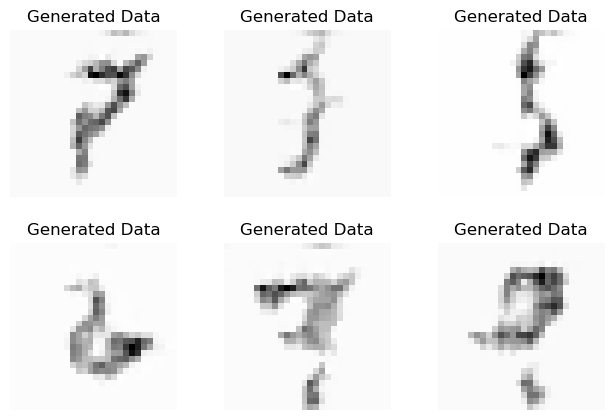

 42%|█████████████████████████████████▌                                              | 126/300 [15:59<21:50,  7.53s/it]

Epoch [127/100] | D Loss: 0.5586 | G Loss: 0.6917


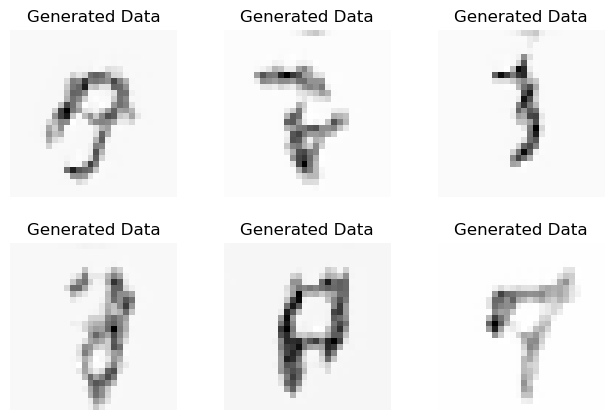

 42%|█████████████████████████████████▊                                              | 127/300 [16:07<22:08,  7.68s/it]

Epoch [128/100] | D Loss: 0.5562 | G Loss: 0.6917


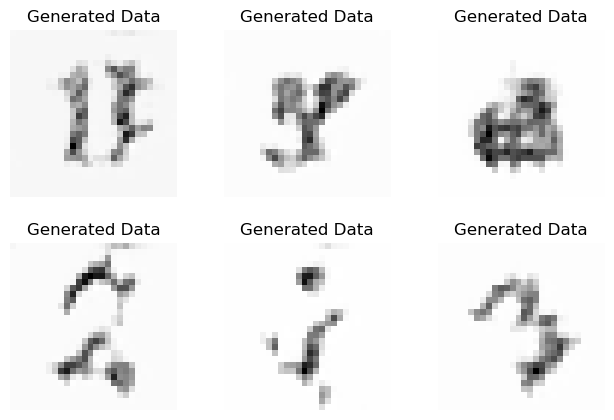

 43%|██████████████████████████████████▏                                             | 128/300 [16:14<21:29,  7.50s/it]

Epoch [129/100] | D Loss: 0.5564 | G Loss: 0.6916


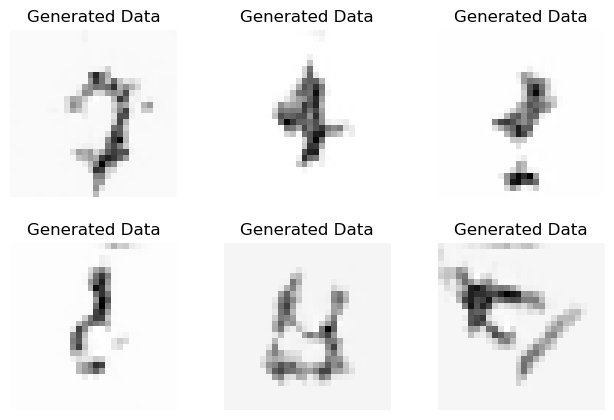

 43%|██████████████████████████████████▍                                             | 129/300 [16:22<22:12,  7.79s/it]

Epoch [130/100] | D Loss: 0.5587 | G Loss: 0.6916


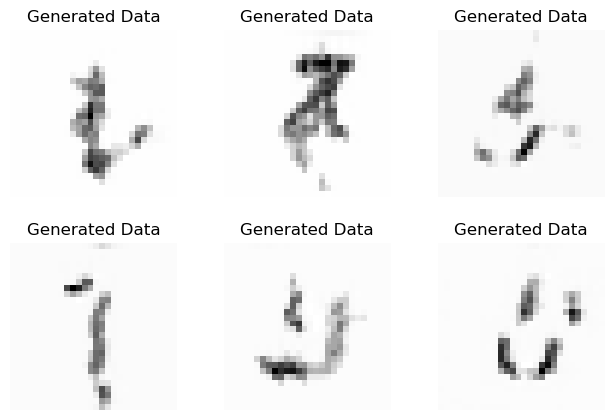

 43%|██████████████████████████████████▋                                             | 130/300 [16:29<21:35,  7.62s/it]

Epoch [131/100] | D Loss: 0.5584 | G Loss: 0.6899


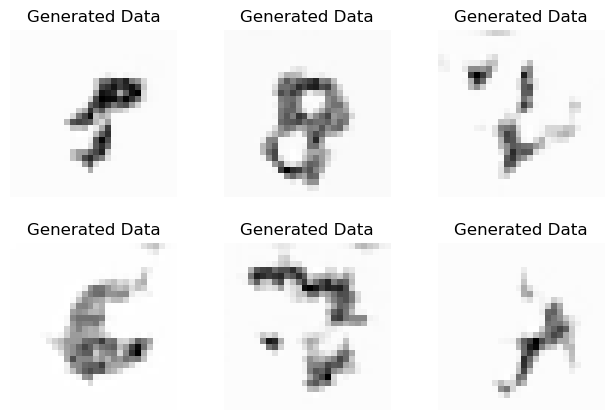

 44%|██████████████████████████████████▉                                             | 131/300 [16:37<21:50,  7.76s/it]

Epoch [132/100] | D Loss: 0.5589 | G Loss: 0.6899


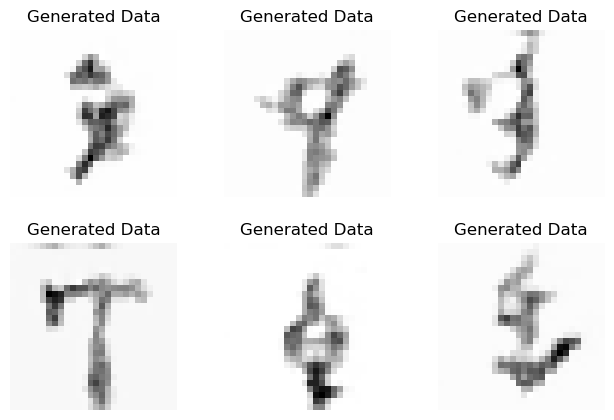

 44%|███████████████████████████████████▏                                            | 132/300 [16:45<21:08,  7.55s/it]

Epoch [133/100] | D Loss: 0.5623 | G Loss: 0.6885


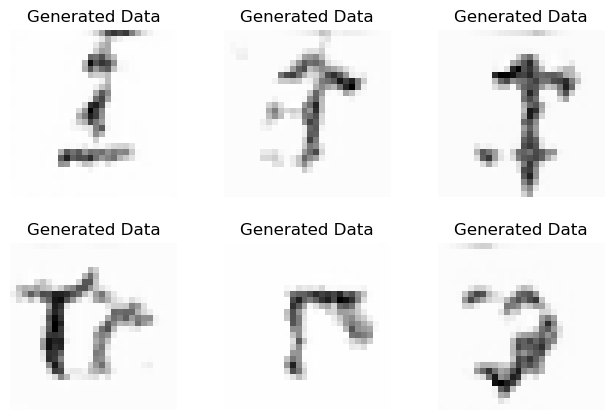

 44%|███████████████████████████████████▍                                            | 133/300 [16:53<21:38,  7.77s/it]

Epoch [134/100] | D Loss: 0.5592 | G Loss: 0.6885


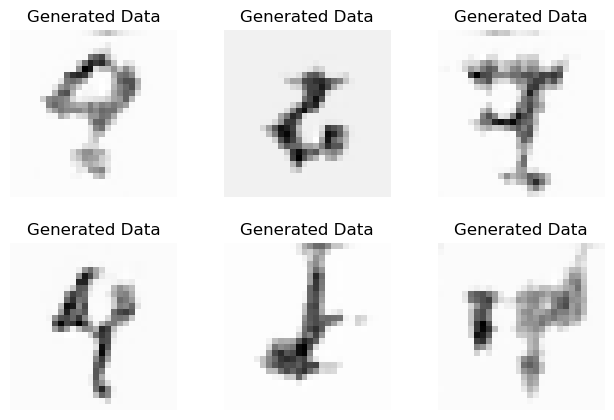

 45%|███████████████████████████████████▋                                            | 134/300 [17:00<20:53,  7.55s/it]

Epoch [135/100] | D Loss: 0.5580 | G Loss: 0.6931


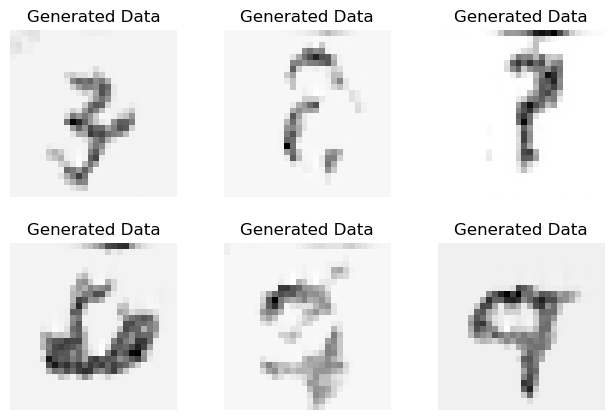

 45%|████████████████████████████████████                                            | 135/300 [17:08<21:08,  7.69s/it]

Epoch [136/100] | D Loss: 0.5576 | G Loss: 0.6931


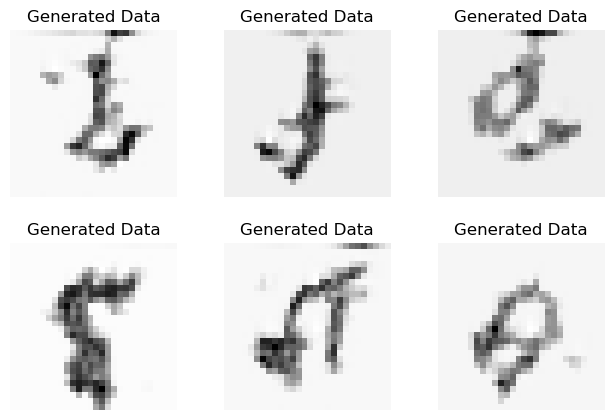

 45%|████████████████████████████████████▎                                           | 136/300 [17:15<20:32,  7.51s/it]

Epoch [137/100] | D Loss: 0.5622 | G Loss: 0.6840


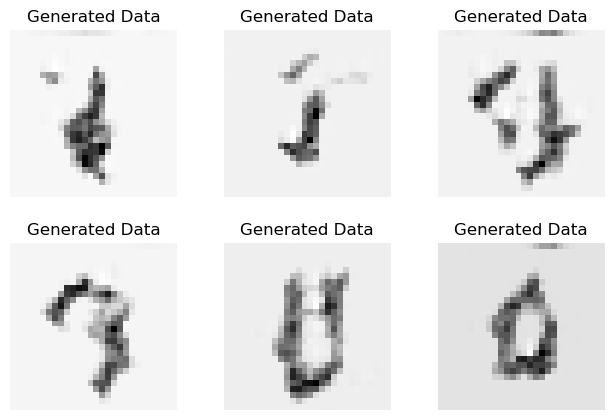

 46%|████████████████████████████████████▌                                           | 137/300 [17:23<20:49,  7.67s/it]

Epoch [138/100] | D Loss: 0.5569 | G Loss: 0.6840


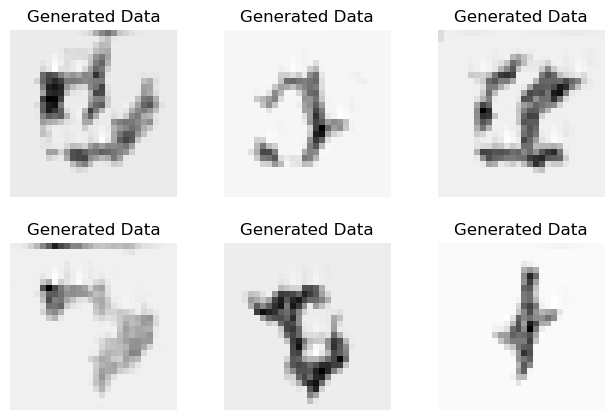

 46%|████████████████████████████████████▊                                           | 138/300 [17:30<20:24,  7.56s/it]

Epoch [139/100] | D Loss: 0.5583 | G Loss: 0.6927


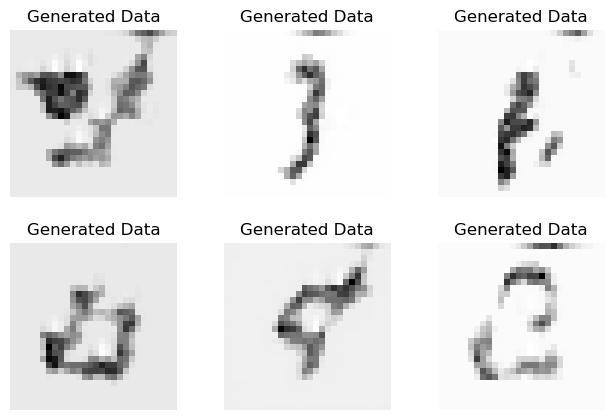

 46%|█████████████████████████████████████                                           | 139/300 [17:38<20:39,  7.70s/it]

Epoch [140/100] | D Loss: 0.5639 | G Loss: 0.6927


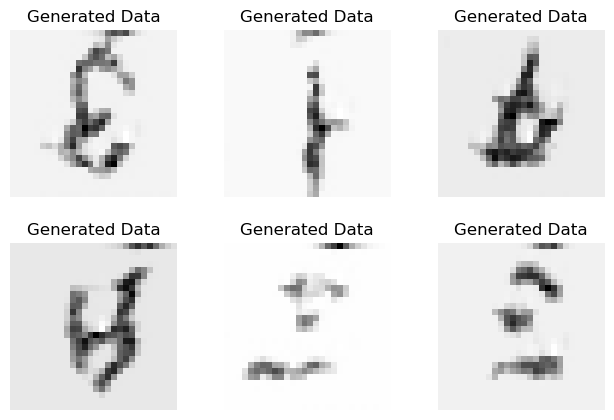

 47%|█████████████████████████████████████▎                                          | 140/300 [17:45<19:59,  7.50s/it]

Epoch [141/100] | D Loss: 0.5573 | G Loss: 0.6861


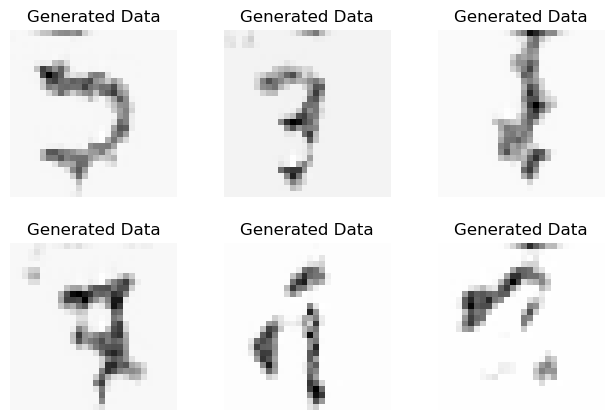

 47%|█████████████████████████████████████▌                                          | 141/300 [17:53<20:21,  7.68s/it]

Epoch [142/100] | D Loss: 0.5568 | G Loss: 0.6861


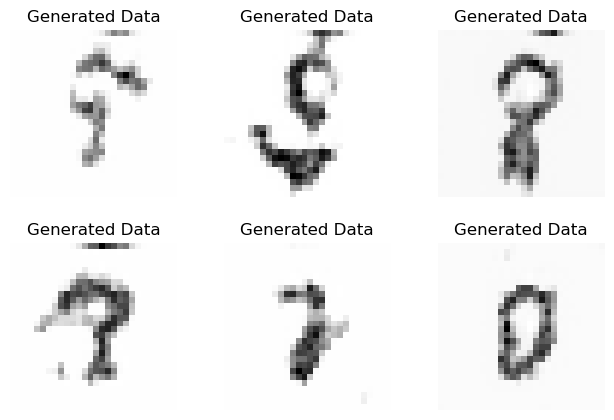

 47%|█████████████████████████████████████▊                                          | 142/300 [18:00<19:41,  7.48s/it]

Epoch [143/100] | D Loss: 0.5617 | G Loss: 0.6873


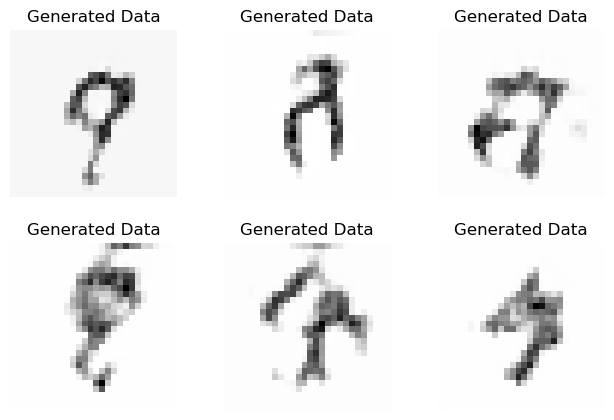

 48%|██████████████████████████████████████▏                                         | 143/300 [18:09<20:17,  7.75s/it]

Epoch [144/100] | D Loss: 0.5565 | G Loss: 0.6873


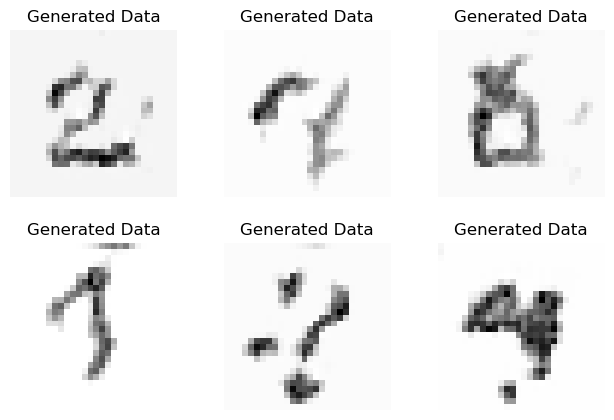

 48%|██████████████████████████████████████▍                                         | 144/300 [18:16<19:40,  7.57s/it]

Epoch [145/100] | D Loss: 0.5727 | G Loss: 0.6876


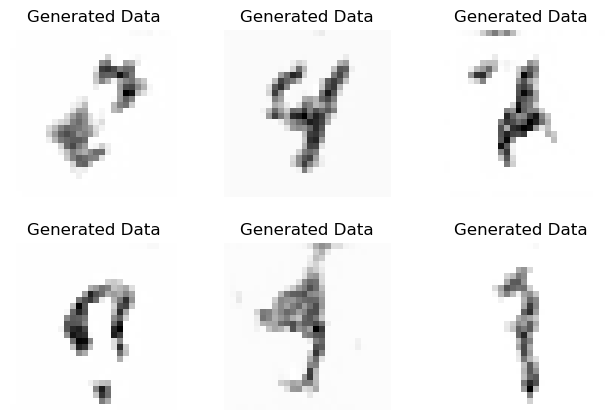

 48%|██████████████████████████████████████▋                                         | 145/300 [18:24<19:58,  7.73s/it]

Epoch [146/100] | D Loss: 0.5665 | G Loss: 0.6876


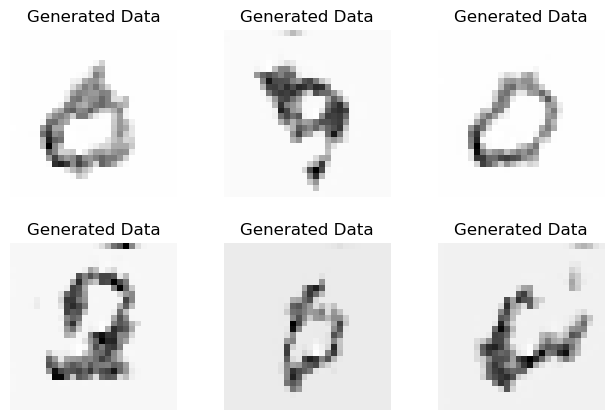

 49%|██████████████████████████████████████▉                                         | 146/300 [18:31<19:18,  7.53s/it]

Epoch [147/100] | D Loss: 0.5583 | G Loss: 0.6820


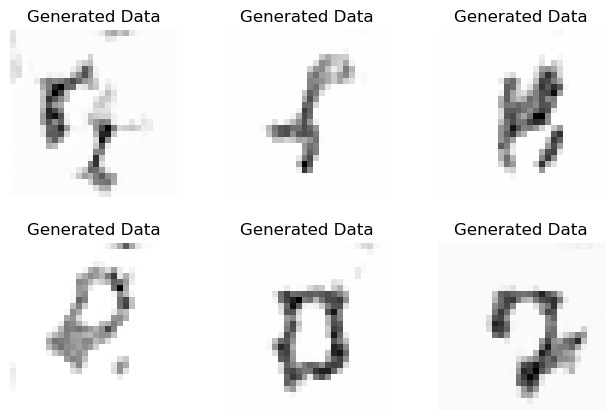

 49%|███████████████████████████████████████▏                                        | 147/300 [18:40<19:49,  7.78s/it]

Epoch [148/100] | D Loss: 0.5555 | G Loss: 0.6820


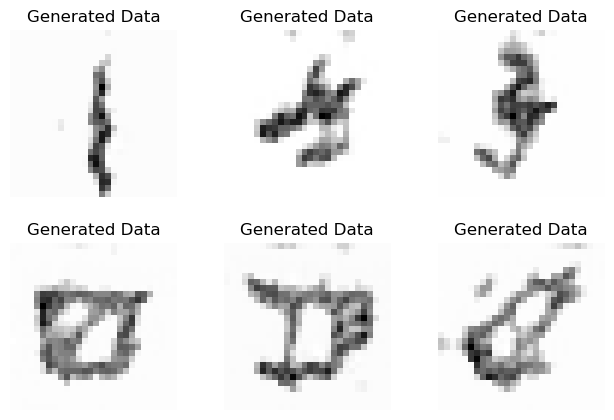

 49%|███████████████████████████████████████▍                                        | 148/300 [18:47<19:08,  7.55s/it]

Epoch [149/100] | D Loss: 0.5644 | G Loss: 0.6845


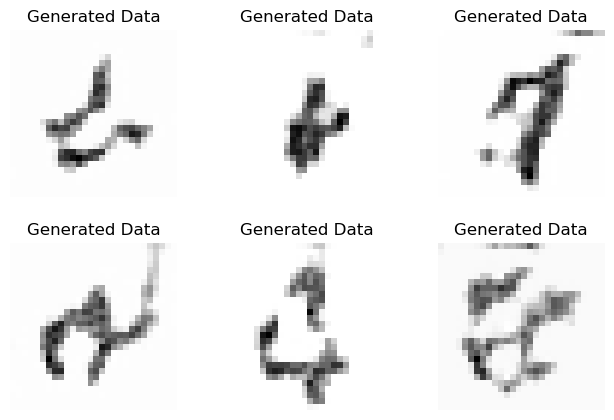

 50%|███████████████████████████████████████▋                                        | 149/300 [18:55<19:23,  7.70s/it]

Epoch [150/100] | D Loss: 0.5637 | G Loss: 0.6845


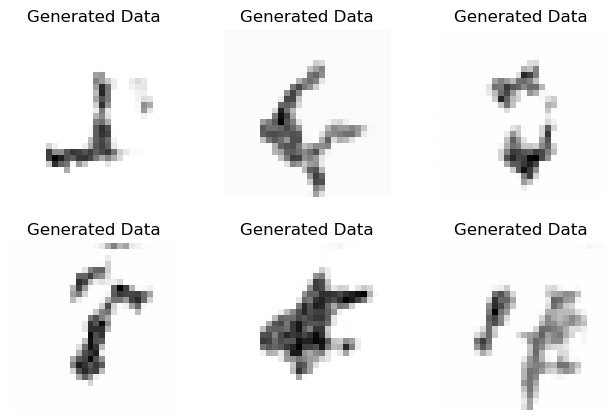

 50%|████████████████████████████████████████                                        | 150/300 [19:02<18:43,  7.49s/it]

Epoch [151/100] | D Loss: 0.5611 | G Loss: 0.6841


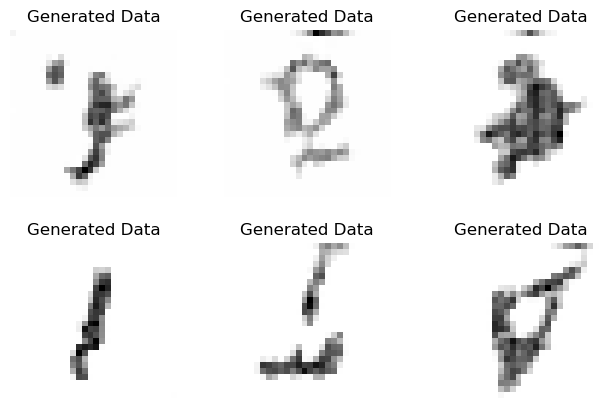

 50%|████████████████████████████████████████▎                                       | 151/300 [19:10<19:02,  7.67s/it]

Epoch [152/100] | D Loss: 0.5641 | G Loss: 0.6841


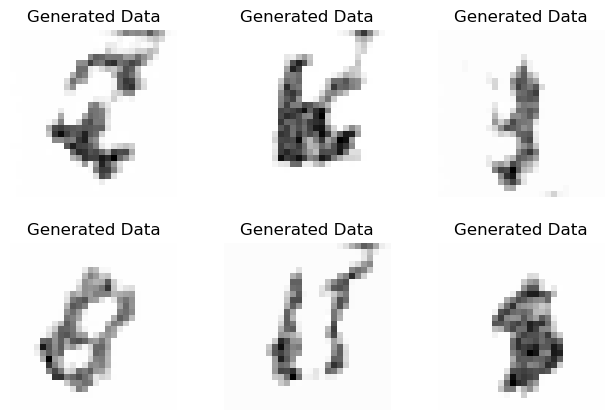

 51%|████████████████████████████████████████▌                                       | 152/300 [19:17<18:42,  7.58s/it]

Epoch [153/100] | D Loss: 0.5543 | G Loss: 0.6808


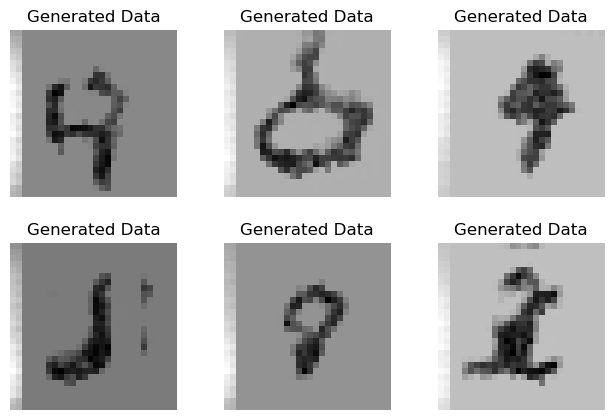

 51%|████████████████████████████████████████▊                                       | 153/300 [19:25<18:56,  7.73s/it]

Epoch [154/100] | D Loss: 0.5560 | G Loss: 0.6808


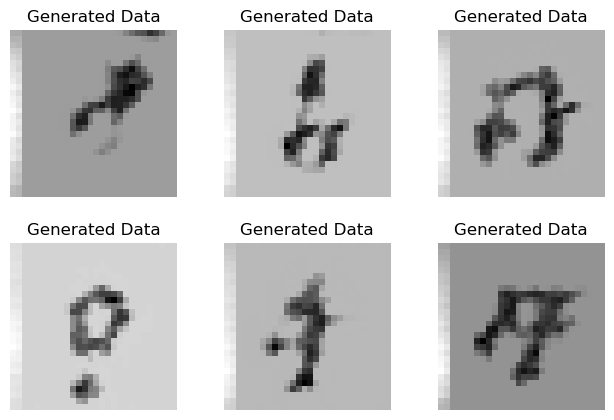

 51%|█████████████████████████████████████████                                       | 154/300 [19:32<18:19,  7.53s/it]

Epoch [155/100] | D Loss: 0.5603 | G Loss: 0.6868


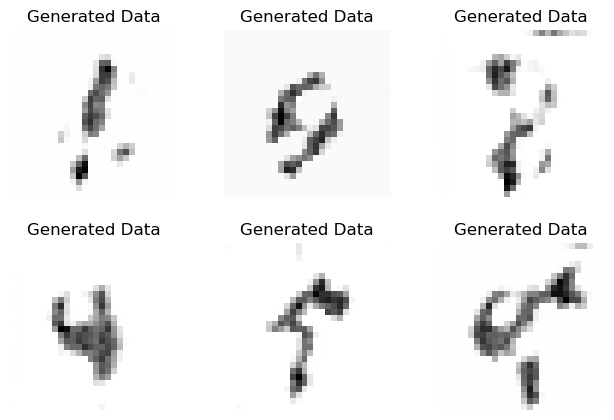

 52%|█████████████████████████████████████████▎                                      | 155/300 [19:40<18:37,  7.71s/it]

Epoch [156/100] | D Loss: 0.5592 | G Loss: 0.6868


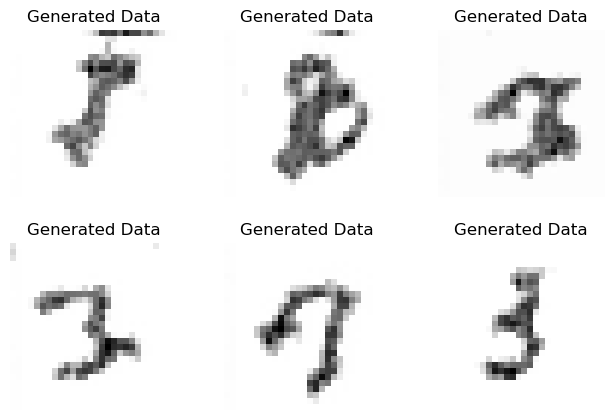

 52%|█████████████████████████████████████████▌                                      | 156/300 [19:47<18:01,  7.51s/it]

Epoch [157/100] | D Loss: 0.5578 | G Loss: 0.6872


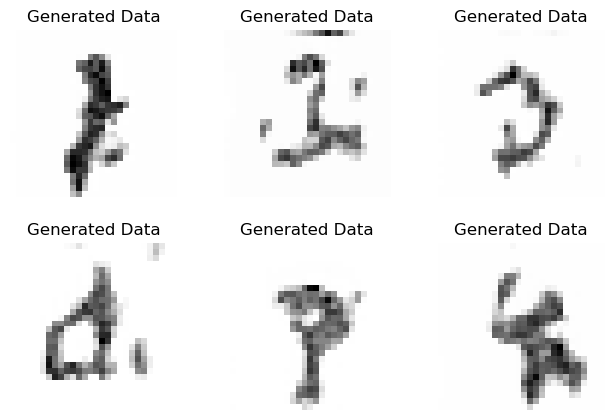

 52%|█████████████████████████████████████████▊                                      | 157/300 [19:56<18:34,  7.79s/it]

Epoch [158/100] | D Loss: 0.5573 | G Loss: 0.6872


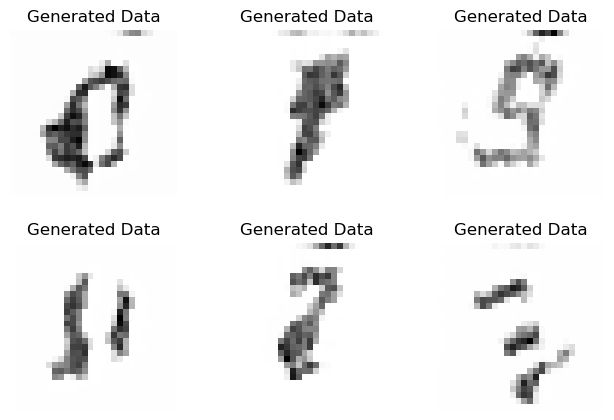

 53%|██████████████████████████████████████████▏                                     | 158/300 [20:03<18:00,  7.61s/it]

Epoch [159/100] | D Loss: 0.5670 | G Loss: 0.6878


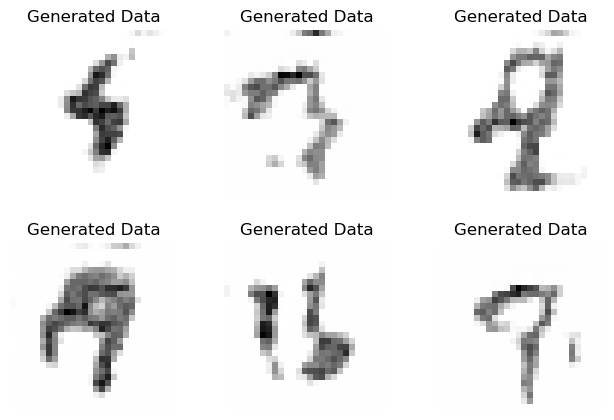

 53%|██████████████████████████████████████████▍                                     | 159/300 [20:11<18:21,  7.81s/it]

Epoch [160/100] | D Loss: 0.5619 | G Loss: 0.6878


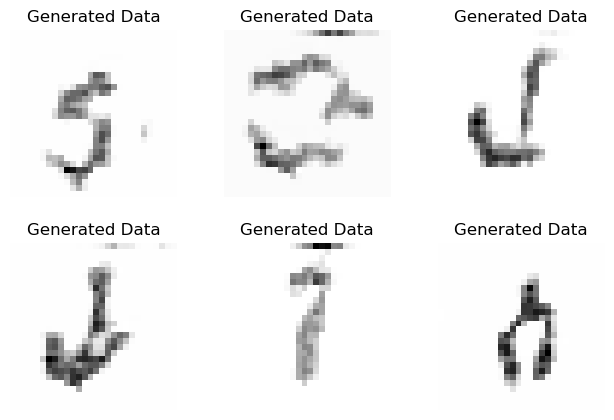

 53%|██████████████████████████████████████████▋                                     | 160/300 [20:19<17:48,  7.63s/it]

Epoch [161/100] | D Loss: 0.5684 | G Loss: 0.6888


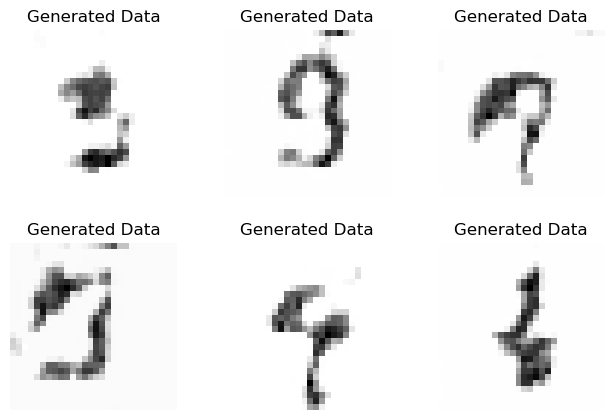

 54%|██████████████████████████████████████████▉                                     | 161/300 [20:27<18:15,  7.88s/it]

Epoch [162/100] | D Loss: 0.5625 | G Loss: 0.6888


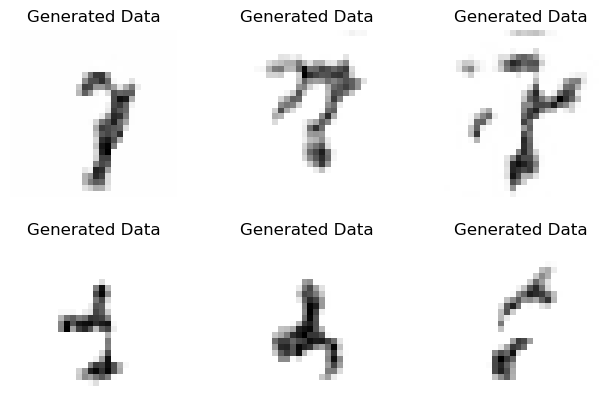

 54%|███████████████████████████████████████████▏                                    | 162/300 [20:34<17:51,  7.76s/it]

Epoch [163/100] | D Loss: 0.5608 | G Loss: 0.6874


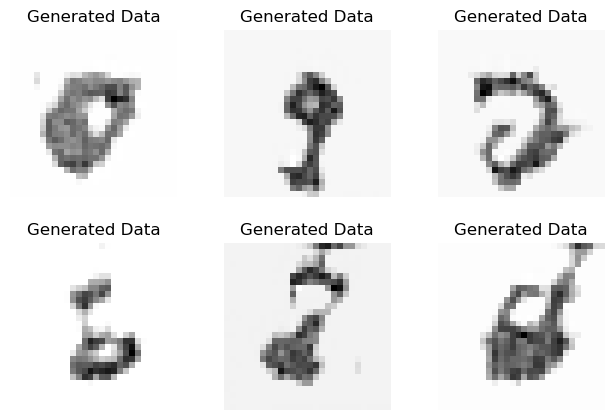

 54%|███████████████████████████████████████████▍                                    | 163/300 [20:43<18:21,  8.04s/it]

Epoch [164/100] | D Loss: 0.5634 | G Loss: 0.6874


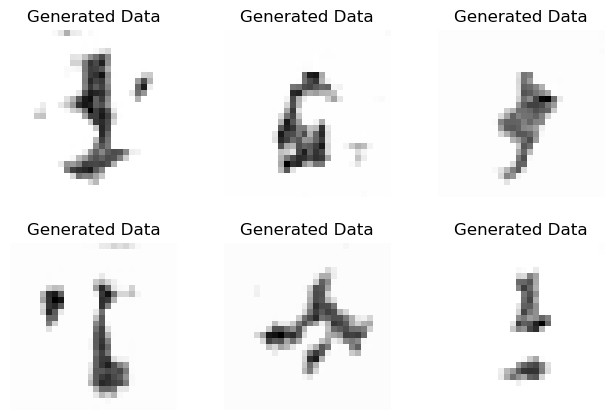

 55%|███████████████████████████████████████████▋                                    | 164/300 [20:51<17:51,  7.88s/it]

Epoch [165/100] | D Loss: 0.5679 | G Loss: 0.6873


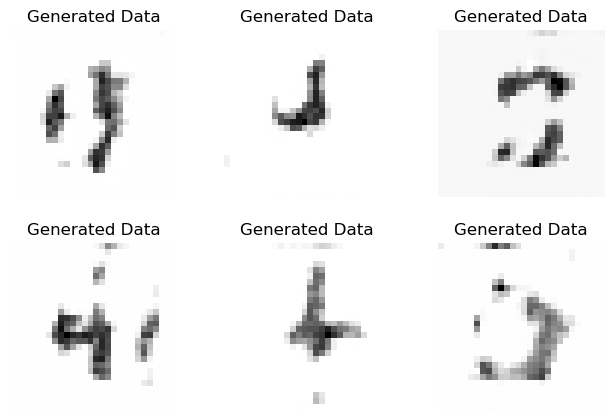

 55%|████████████████████████████████████████████                                    | 165/300 [20:59<18:09,  8.07s/it]

Epoch [166/100] | D Loss: 0.5664 | G Loss: 0.6873


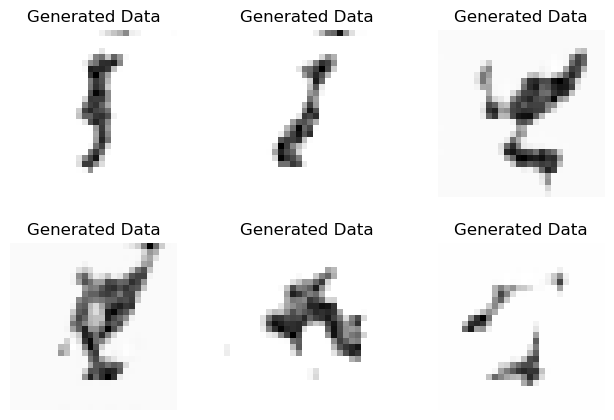

 55%|████████████████████████████████████████████▎                                   | 166/300 [21:07<17:43,  7.93s/it]

Epoch [167/100] | D Loss: 0.5607 | G Loss: 0.6928


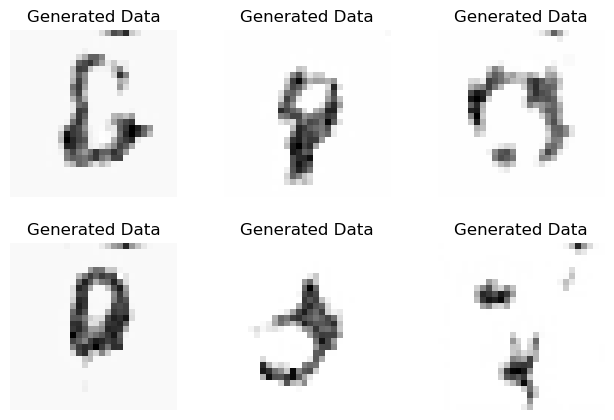

 56%|████████████████████████████████████████████▌                                   | 167/300 [21:15<17:57,  8.10s/it]

Epoch [168/100] | D Loss: 0.5609 | G Loss: 0.6928


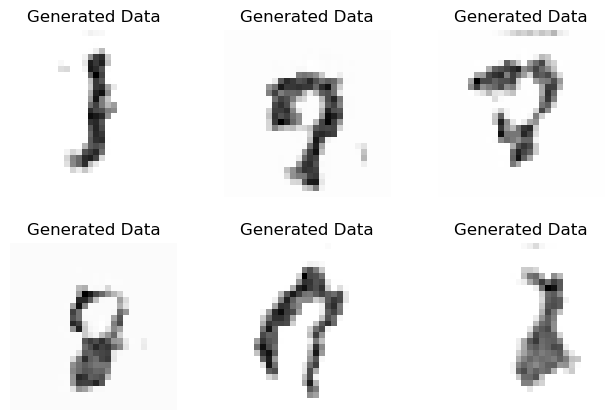

 56%|████████████████████████████████████████████▊                                   | 168/300 [21:23<17:16,  7.85s/it]

Epoch [169/100] | D Loss: 0.5580 | G Loss: 0.6856


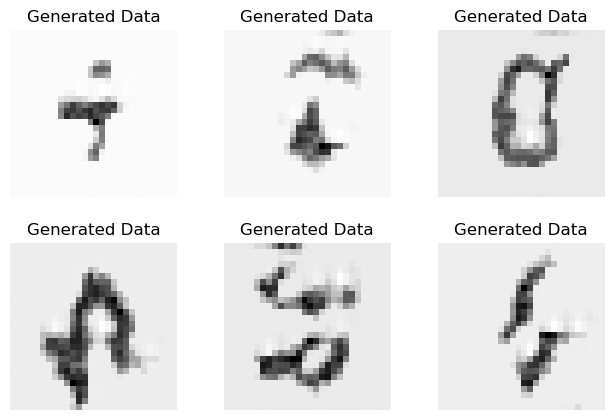

 56%|█████████████████████████████████████████████                                   | 169/300 [21:31<17:31,  8.02s/it]

Epoch [170/100] | D Loss: 0.5590 | G Loss: 0.6856


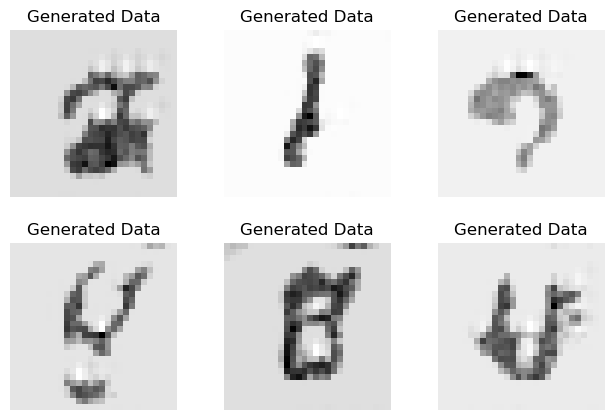

 57%|█████████████████████████████████████████████▎                                  | 170/300 [21:38<16:50,  7.78s/it]

Epoch [171/100] | D Loss: 0.5631 | G Loss: 0.6909


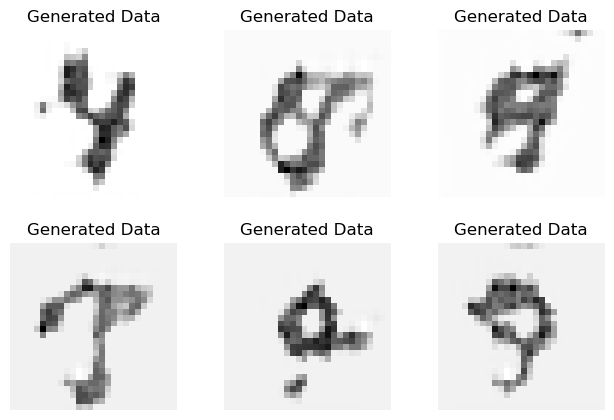

 57%|█████████████████████████████████████████████▌                                  | 171/300 [21:47<17:14,  8.02s/it]

Epoch [172/100] | D Loss: 0.5616 | G Loss: 0.6909


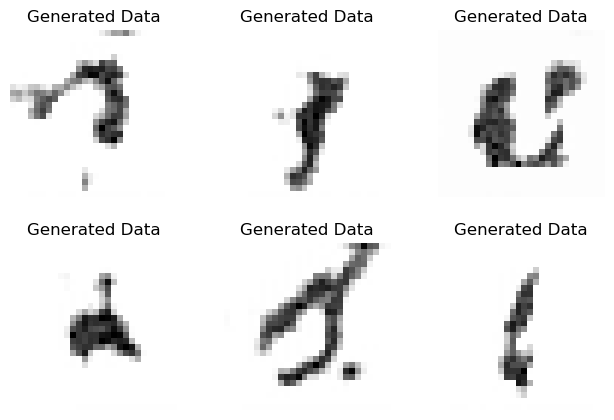

 57%|█████████████████████████████████████████████▊                                  | 172/300 [21:54<16:37,  7.79s/it]

Epoch [173/100] | D Loss: 0.5604 | G Loss: 0.6907


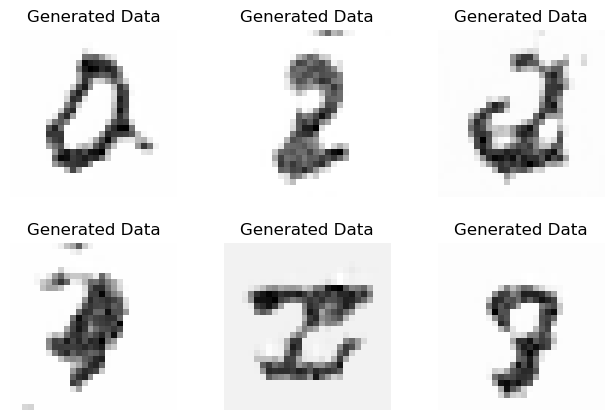

 58%|██████████████████████████████████████████████▏                                 | 173/300 [22:02<16:48,  7.94s/it]

Epoch [174/100] | D Loss: 0.5569 | G Loss: 0.6907


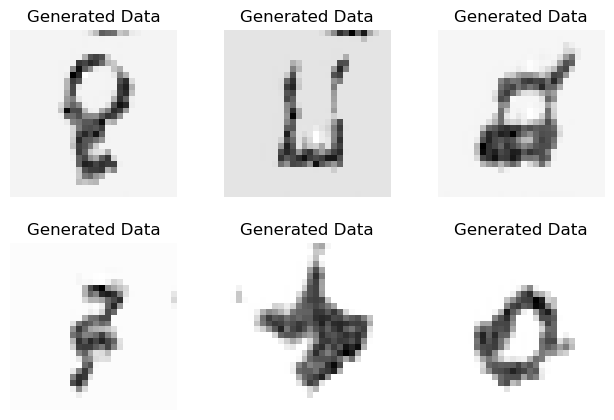

 58%|██████████████████████████████████████████████▍                                 | 174/300 [22:10<16:24,  7.81s/it]

Epoch [175/100] | D Loss: 0.5630 | G Loss: 0.6831


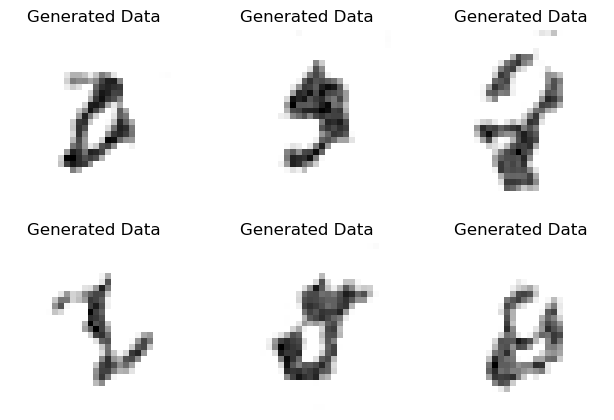

 58%|██████████████████████████████████████████████▋                                 | 175/300 [22:19<17:04,  8.20s/it]

Epoch [176/100] | D Loss: 0.5639 | G Loss: 0.6831


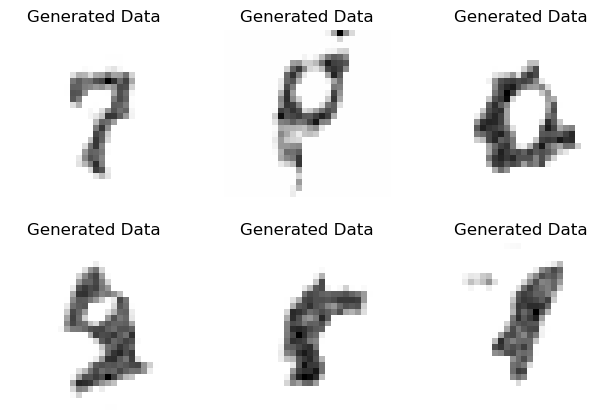

 59%|██████████████████████████████████████████████▉                                 | 176/300 [22:26<16:20,  7.91s/it]

Epoch [177/100] | D Loss: 0.5675 | G Loss: 0.6927


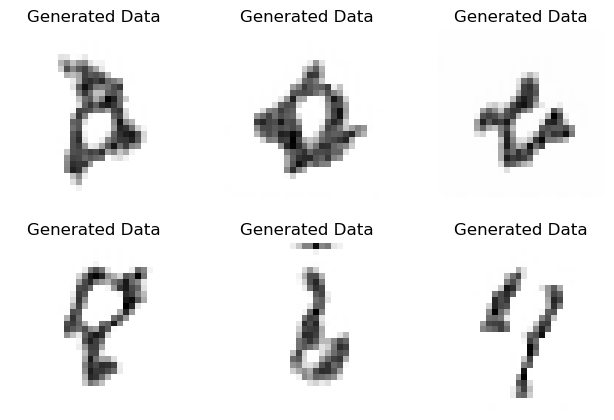

 59%|███████████████████████████████████████████████▏                                | 177/300 [22:34<16:22,  7.99s/it]

Epoch [178/100] | D Loss: 0.5565 | G Loss: 0.6927


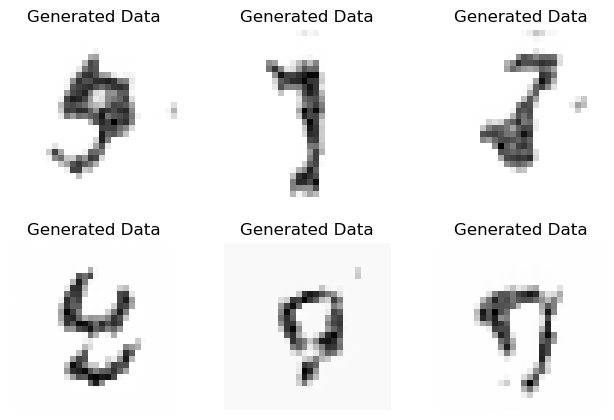

 59%|███████████████████████████████████████████████▍                                | 178/300 [22:42<15:48,  7.77s/it]

Epoch [179/100] | D Loss: 0.5556 | G Loss: 0.6922


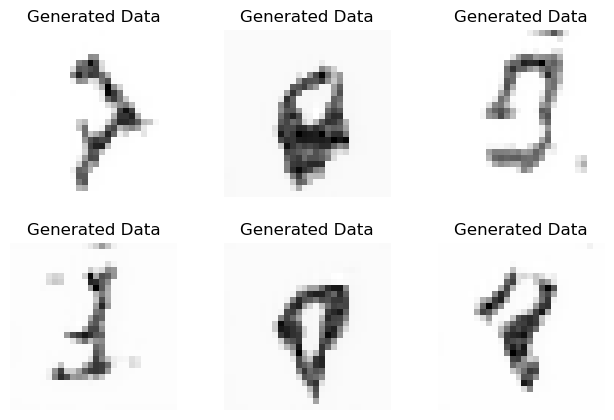

 60%|███████████████████████████████████████████████▋                                | 179/300 [22:50<15:56,  7.90s/it]

Epoch [180/100] | D Loss: 0.5538 | G Loss: 0.6922


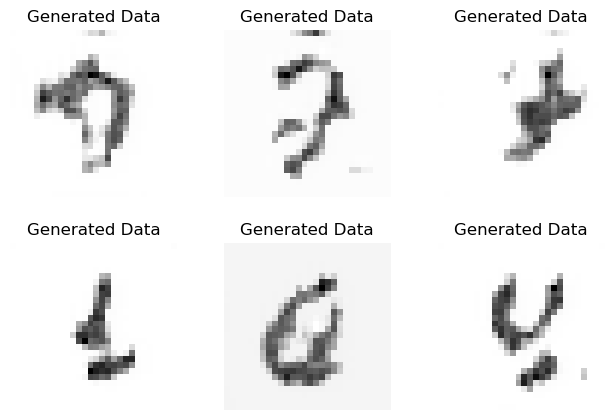

 60%|████████████████████████████████████████████████                                | 180/300 [22:57<15:29,  7.75s/it]

Epoch [181/100] | D Loss: 0.5680 | G Loss: 0.6897


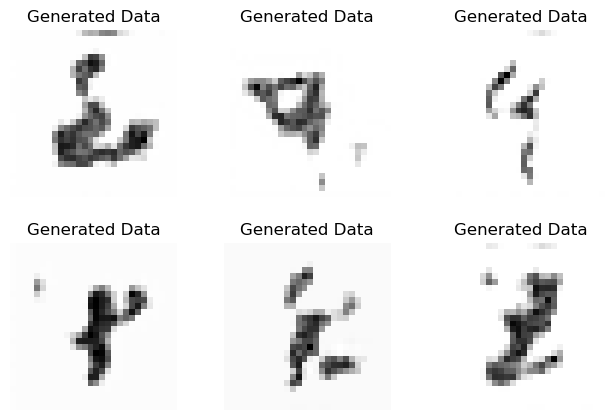

 60%|████████████████████████████████████████████████▎                               | 181/300 [23:05<15:35,  7.86s/it]

Epoch [182/100] | D Loss: 0.5653 | G Loss: 0.6897


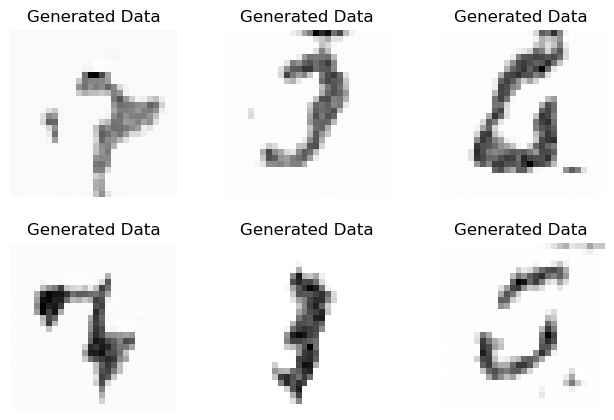

 61%|████████████████████████████████████████████████▌                               | 182/300 [23:12<15:02,  7.64s/it]

Epoch [183/100] | D Loss: 0.5688 | G Loss: 0.6803


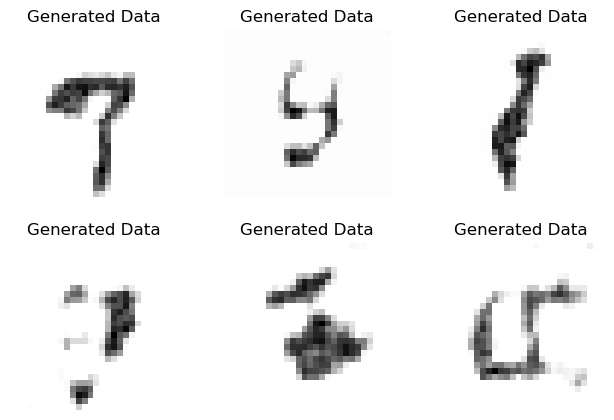

 61%|████████████████████████████████████████████████▊                               | 183/300 [23:21<15:20,  7.87s/it]

Epoch [184/100] | D Loss: 0.5611 | G Loss: 0.6803


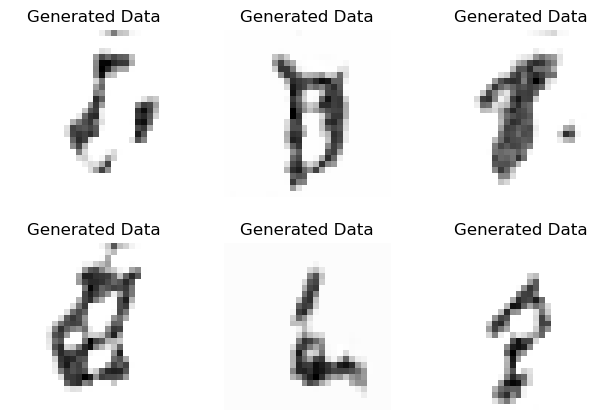

 61%|█████████████████████████████████████████████████                               | 184/300 [23:28<14:46,  7.64s/it]

Epoch [185/100] | D Loss: 0.5666 | G Loss: 0.6873


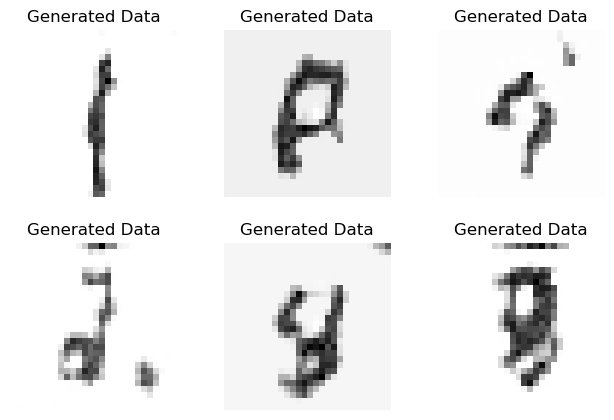

 62%|█████████████████████████████████████████████████▎                              | 185/300 [23:36<15:03,  7.86s/it]

Epoch [186/100] | D Loss: 0.5537 | G Loss: 0.6873


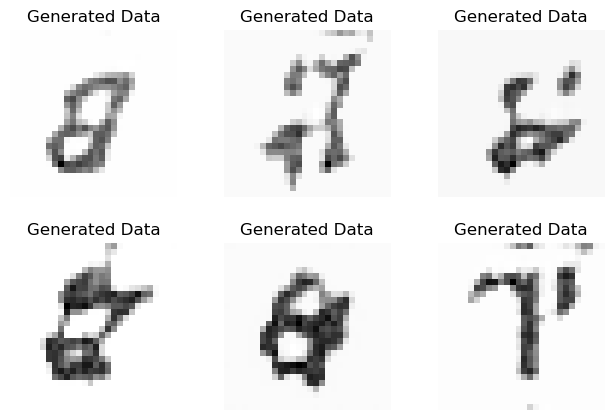

 62%|█████████████████████████████████████████████████▌                              | 186/300 [23:43<14:29,  7.63s/it]

Epoch [187/100] | D Loss: 0.5685 | G Loss: 0.6783


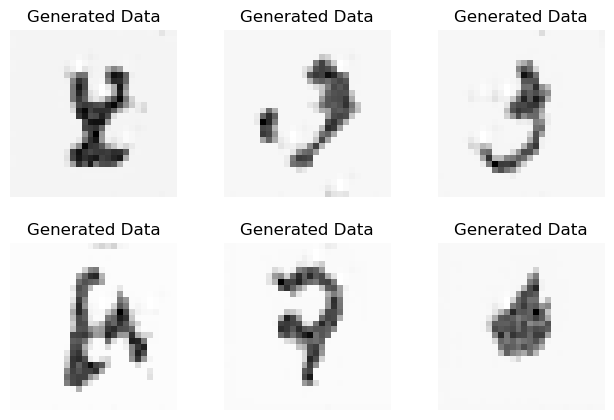

 62%|█████████████████████████████████████████████████▊                              | 187/300 [23:52<14:40,  7.79s/it]

Epoch [188/100] | D Loss: 0.5601 | G Loss: 0.6783


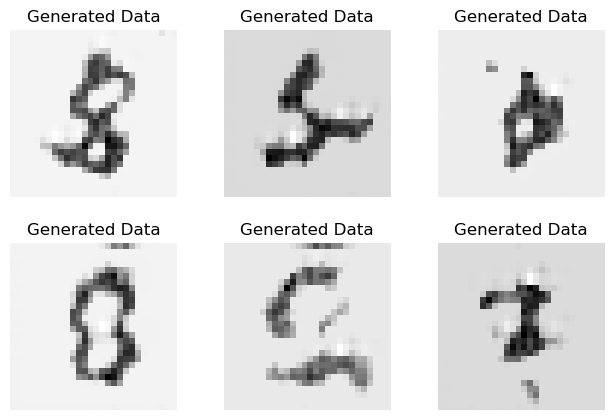

 63%|██████████████████████████████████████████████████▏                             | 188/300 [23:59<14:08,  7.57s/it]

Epoch [189/100] | D Loss: 0.5575 | G Loss: 0.6931


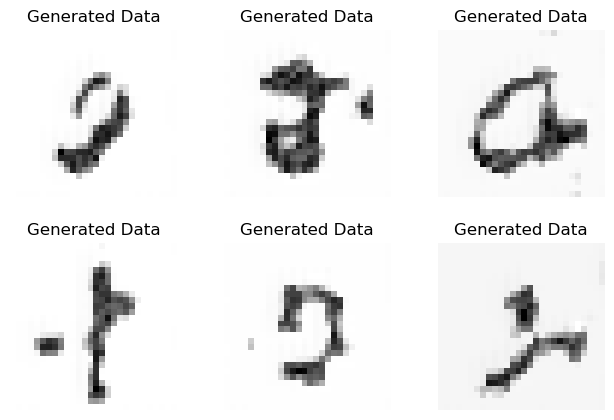

 63%|██████████████████████████████████████████████████▍                             | 189/300 [24:07<14:27,  7.82s/it]

Epoch [190/100] | D Loss: 0.5532 | G Loss: 0.6931


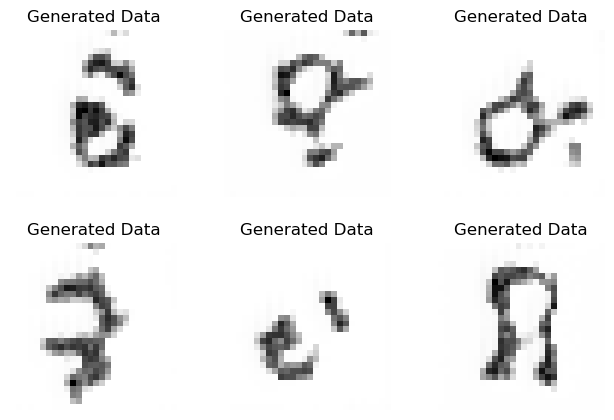

 63%|██████████████████████████████████████████████████▋                             | 190/300 [24:14<13:57,  7.62s/it]

Epoch [191/100] | D Loss: 0.5601 | G Loss: 0.6911


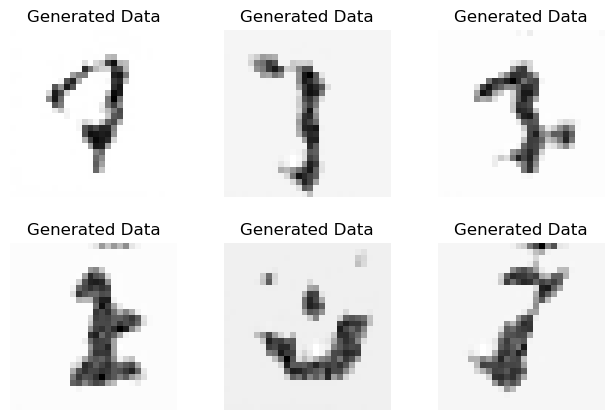

 64%|██████████████████████████████████████████████████▉                             | 191/300 [24:22<14:09,  7.79s/it]

Epoch [192/100] | D Loss: 0.5581 | G Loss: 0.6911


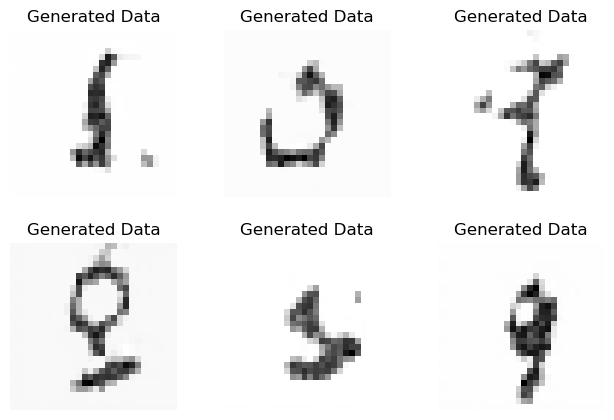

 64%|███████████████████████████████████████████████████▏                            | 192/300 [24:29<13:39,  7.59s/it]

Epoch [193/100] | D Loss: 0.5534 | G Loss: 0.6909


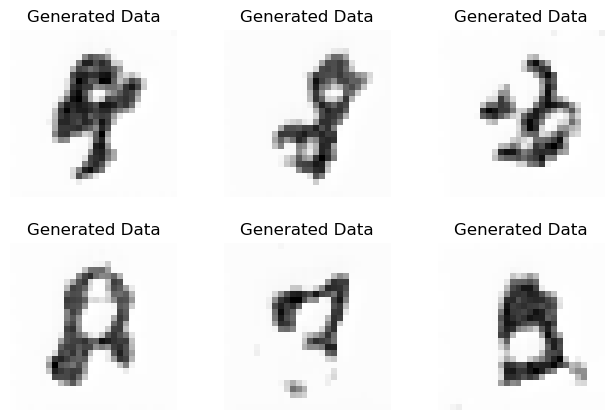

 64%|███████████████████████████████████████████████████▍                            | 193/300 [24:38<13:50,  7.76s/it]

Epoch [194/100] | D Loss: 0.5532 | G Loss: 0.6909


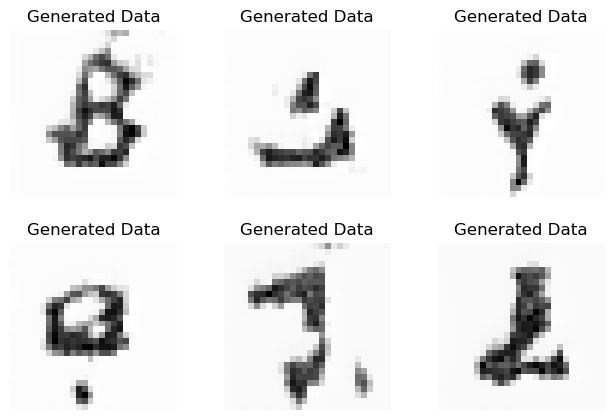

 65%|███████████████████████████████████████████████████▋                            | 194/300 [24:45<13:30,  7.64s/it]

Epoch [195/100] | D Loss: 0.5536 | G Loss: 0.6930


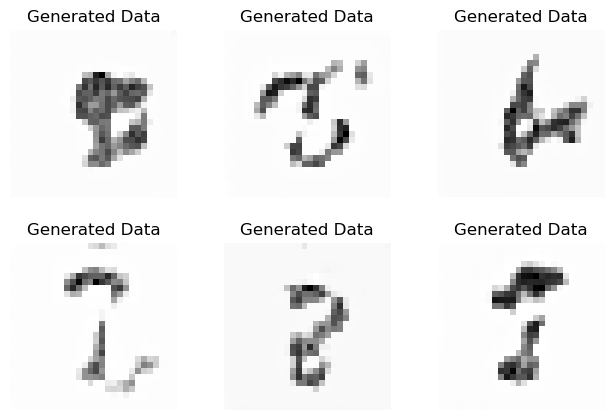

 65%|████████████████████████████████████████████████████                            | 195/300 [24:54<13:49,  7.90s/it]

Epoch [196/100] | D Loss: 0.5536 | G Loss: 0.6930


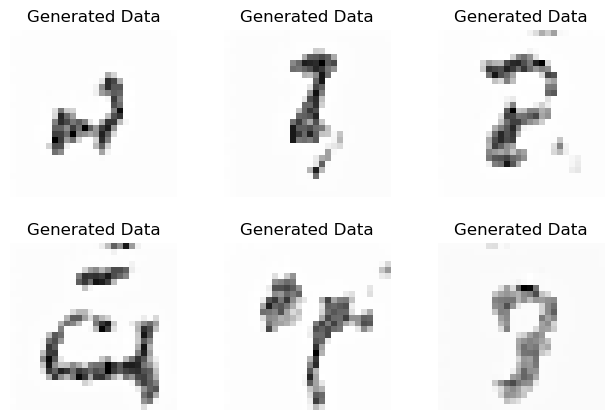

 65%|████████████████████████████████████████████████████▎                           | 196/300 [25:01<13:15,  7.65s/it]

Epoch [197/100] | D Loss: 0.5557 | G Loss: 0.6811


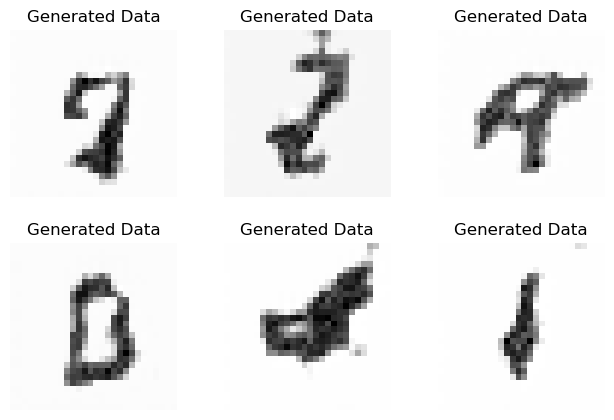

 66%|████████████████████████████████████████████████████▌                           | 197/300 [25:09<13:23,  7.80s/it]

Epoch [198/100] | D Loss: 0.5583 | G Loss: 0.6811


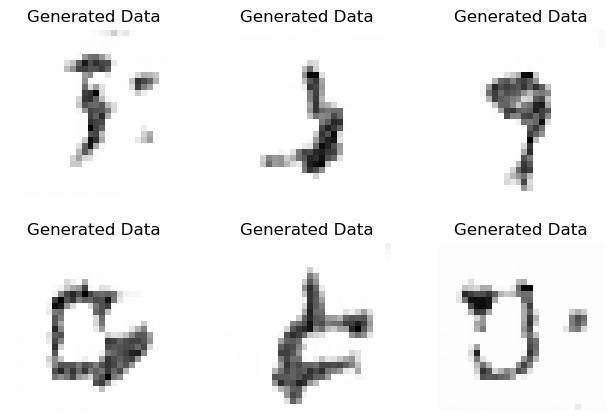

 66%|████████████████████████████████████████████████████▊                           | 198/300 [25:16<12:54,  7.59s/it]

Epoch [199/100] | D Loss: 0.5543 | G Loss: 0.6931


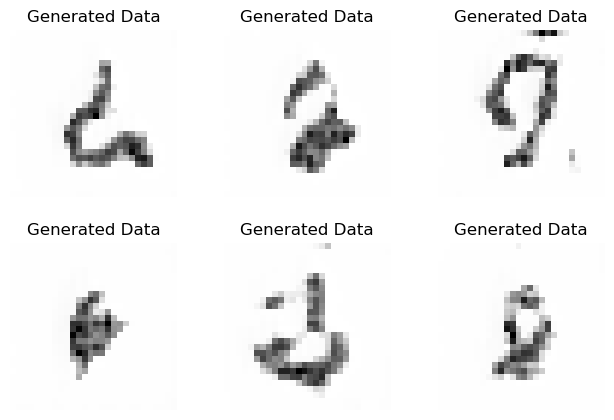

 66%|█████████████████████████████████████████████████████                           | 199/300 [25:24<13:11,  7.84s/it]

Epoch [200/100] | D Loss: 0.5532 | G Loss: 0.6931


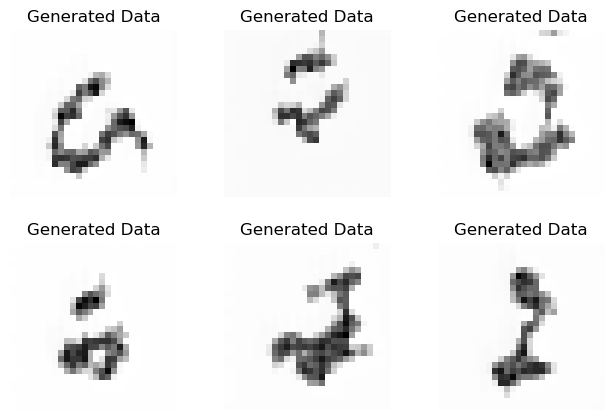

 67%|█████████████████████████████████████████████████████▎                          | 200/300 [25:31<12:40,  7.60s/it]

Epoch [201/100] | D Loss: 0.5566 | G Loss: 0.6931


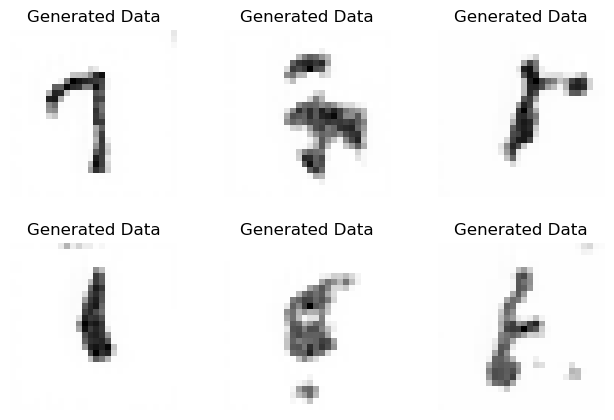

 67%|█████████████████████████████████████████████████████▌                          | 201/300 [25:39<12:49,  7.77s/it]

Epoch [202/100] | D Loss: 0.5541 | G Loss: 0.6931


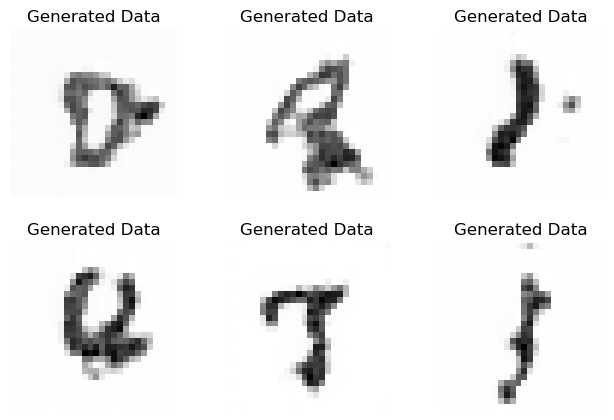

 67%|█████████████████████████████████████████████████████▊                          | 202/300 [25:47<12:21,  7.56s/it]

Epoch [203/100] | D Loss: 0.5532 | G Loss: 0.6931


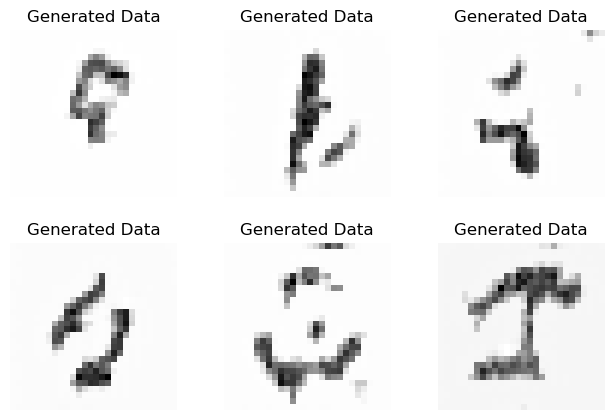

 68%|██████████████████████████████████████████████████████▏                         | 203/300 [25:55<12:38,  7.82s/it]

Epoch [204/100] | D Loss: 0.5532 | G Loss: 0.6931


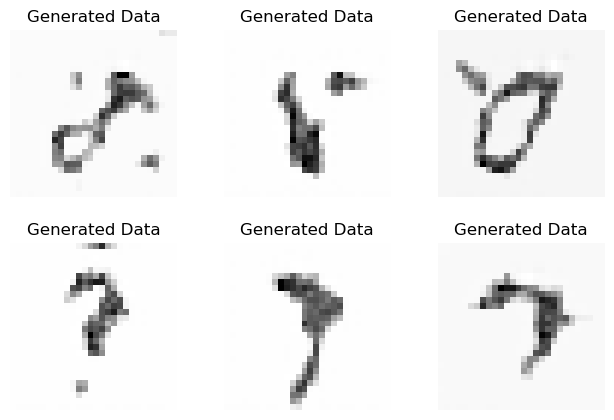

 68%|██████████████████████████████████████████████████████▍                         | 204/300 [26:02<12:10,  7.61s/it]

Epoch [205/100] | D Loss: 0.5556 | G Loss: 0.6927


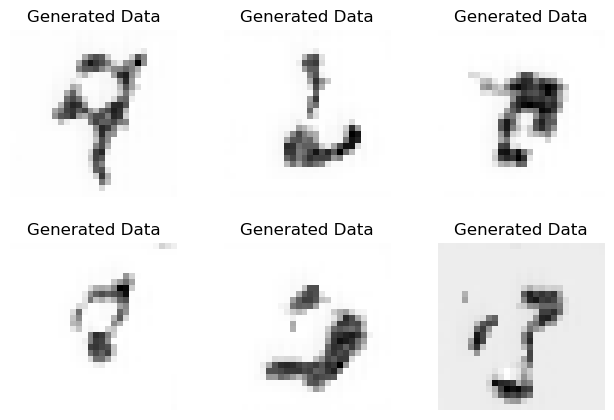

 68%|██████████████████████████████████████████████████████▋                         | 205/300 [26:10<12:18,  7.78s/it]

Epoch [206/100] | D Loss: 0.5532 | G Loss: 0.6927


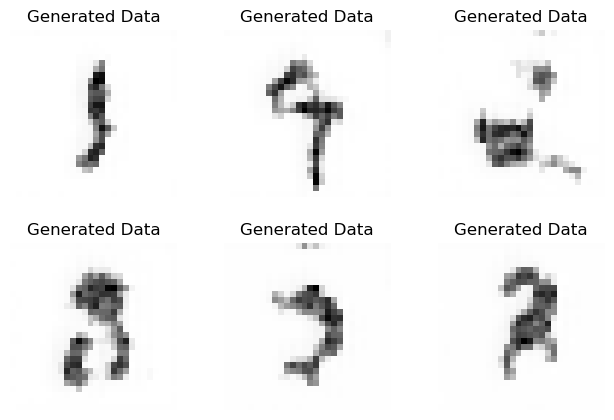

 69%|██████████████████████████████████████████████████████▉                         | 206/300 [26:17<11:52,  7.58s/it]

Epoch [207/100] | D Loss: 0.5532 | G Loss: 0.6920


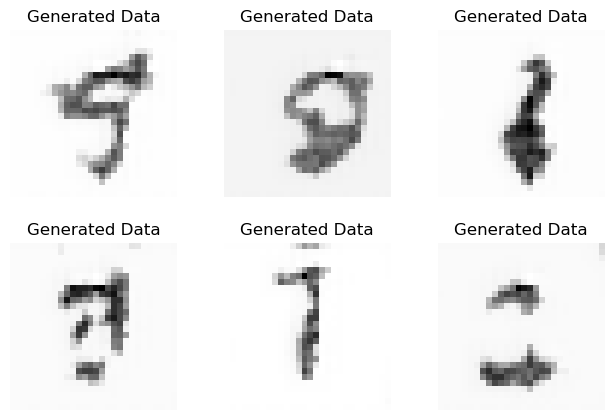

 69%|███████████████████████████████████████████████████████▏                        | 207/300 [26:26<12:06,  7.82s/it]

Epoch [208/100] | D Loss: 0.5533 | G Loss: 0.6920


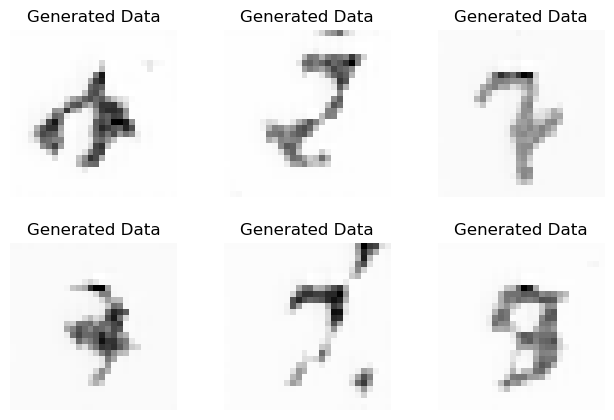

 69%|███████████████████████████████████████████████████████▍                        | 208/300 [26:33<11:48,  7.70s/it]

Epoch [209/100] | D Loss: 0.5532 | G Loss: 0.6931


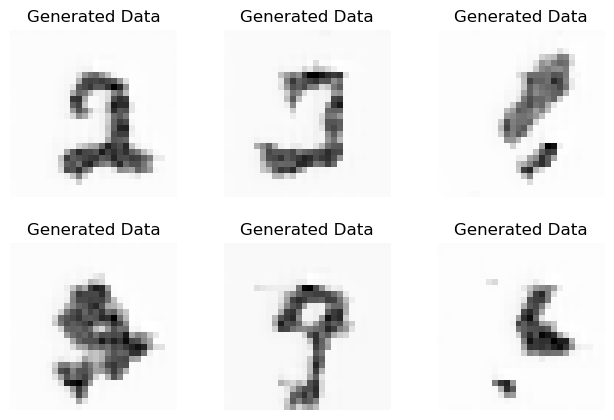

 70%|███████████████████████████████████████████████████████▋                        | 209/300 [26:41<11:55,  7.86s/it]

Epoch [210/100] | D Loss: 0.5535 | G Loss: 0.6931


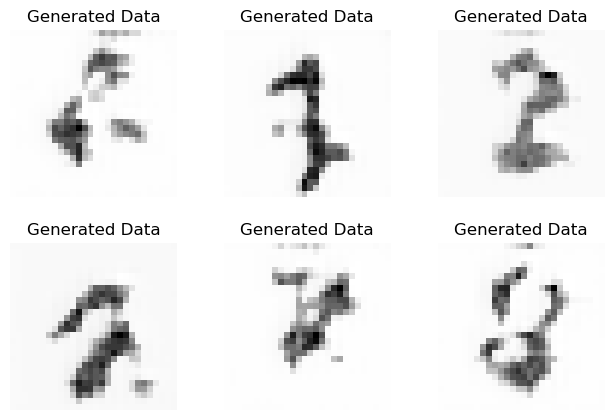

 70%|████████████████████████████████████████████████████████                        | 210/300 [26:49<11:41,  7.79s/it]

Epoch [211/100] | D Loss: 0.5550 | G Loss: 0.6931


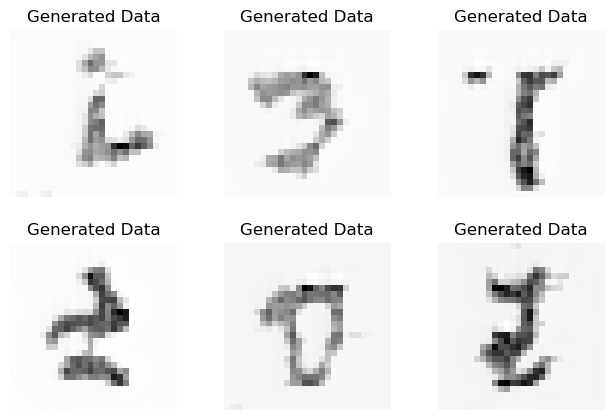

 70%|████████████████████████████████████████████████████████▎                       | 211/300 [26:58<11:58,  8.07s/it]

Epoch [212/100] | D Loss: 0.5543 | G Loss: 0.6931


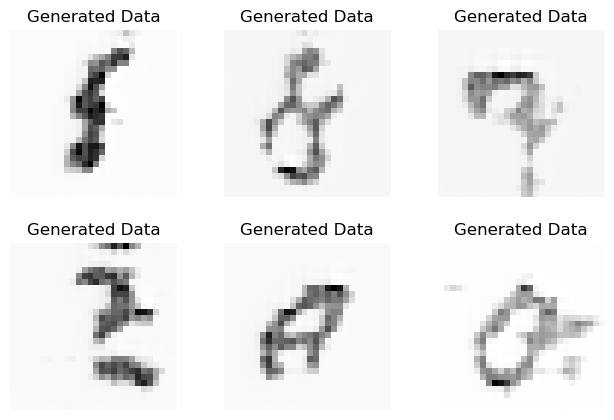

 71%|████████████████████████████████████████████████████████▌                       | 212/300 [27:05<11:32,  7.87s/it]

Epoch [213/100] | D Loss: 0.5553 | G Loss: 0.6931


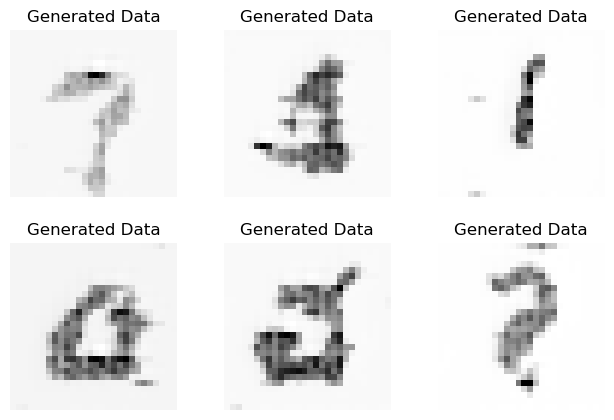

 71%|████████████████████████████████████████████████████████▊                       | 213/300 [27:14<11:47,  8.13s/it]

Epoch [214/100] | D Loss: 0.5543 | G Loss: 0.6931


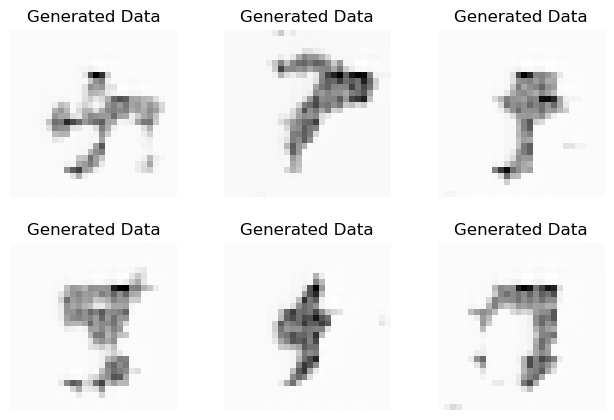

 71%|█████████████████████████████████████████████████████████                       | 214/300 [27:21<11:19,  7.90s/it]

Epoch [215/100] | D Loss: 0.5551 | G Loss: 0.6931


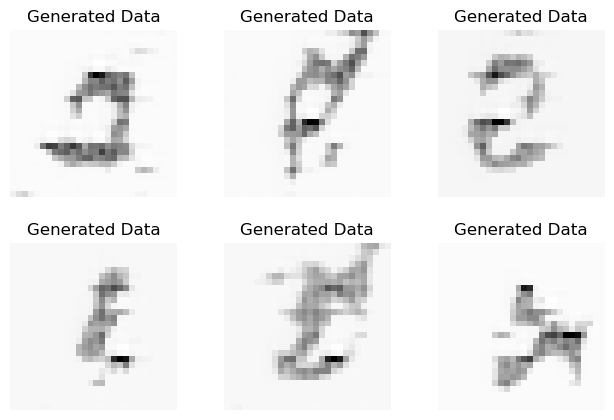

 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [27:30<11:28,  8.10s/it]

Epoch [216/100] | D Loss: 0.5532 | G Loss: 0.6931


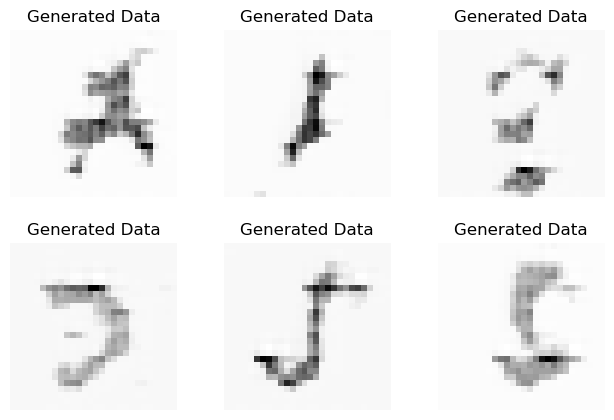

 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [27:37<11:02,  7.89s/it]

Epoch [217/100] | D Loss: 0.5544 | G Loss: 0.6931


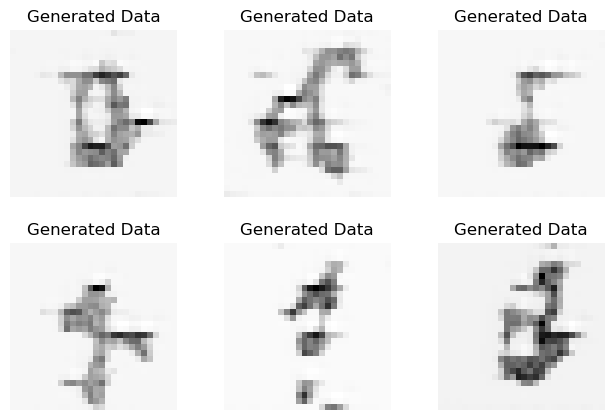

 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [27:46<11:17,  8.16s/it]

Epoch [218/100] | D Loss: 0.5532 | G Loss: 0.6931


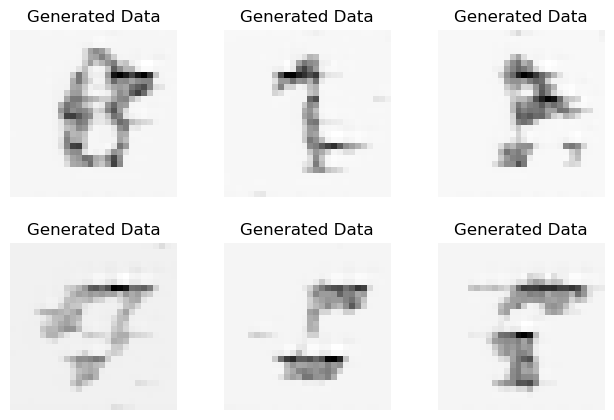

 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [27:53<10:49,  7.92s/it]

Epoch [219/100] | D Loss: 0.5572 | G Loss: 0.6920


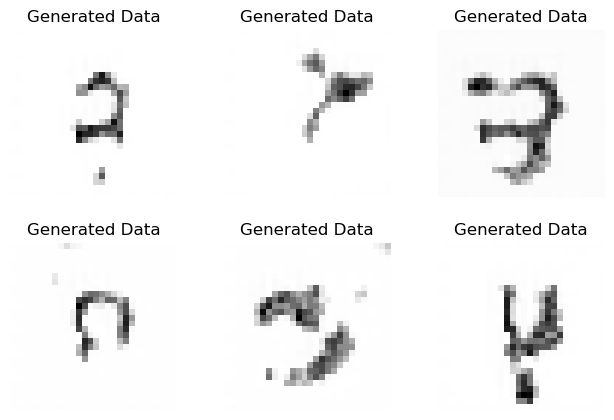

 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [28:02<10:56,  8.10s/it]

Epoch [220/100] | D Loss: 0.5548 | G Loss: 0.6920


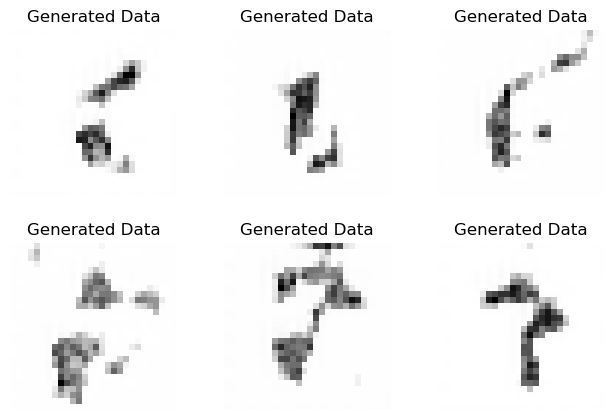

 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [28:09<10:26,  7.83s/it]

Epoch [221/100] | D Loss: 0.5543 | G Loss: 0.6931


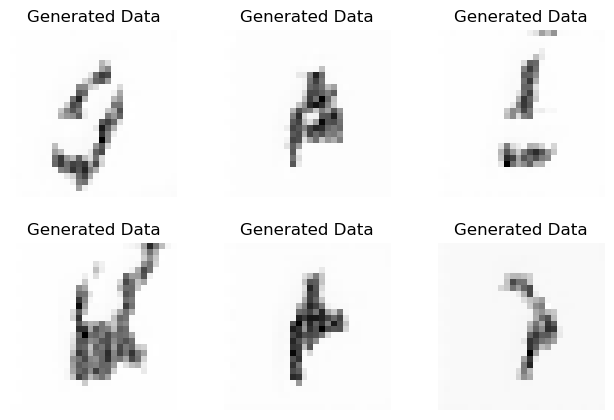

 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [28:17<10:27,  7.94s/it]

Epoch [222/100] | D Loss: 0.5532 | G Loss: 0.6931


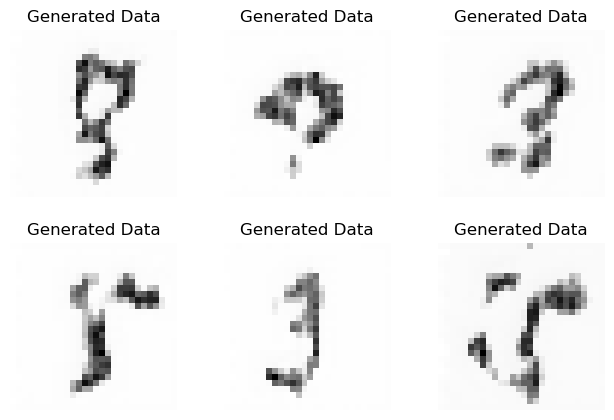

 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [28:25<10:05,  7.77s/it]

Epoch [223/100] | D Loss: 0.5533 | G Loss: 0.6931


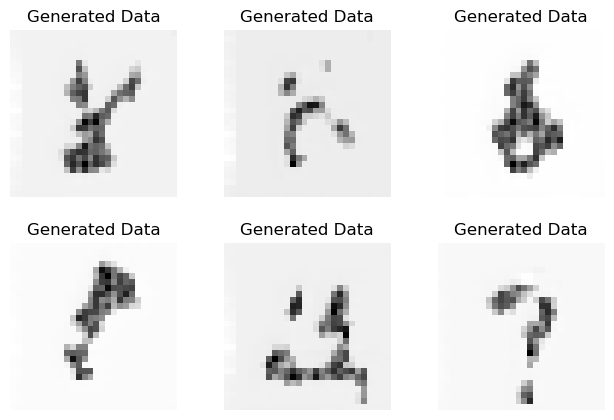

 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [28:33<10:08,  7.90s/it]

Epoch [224/100] | D Loss: 0.5532 | G Loss: 0.6931


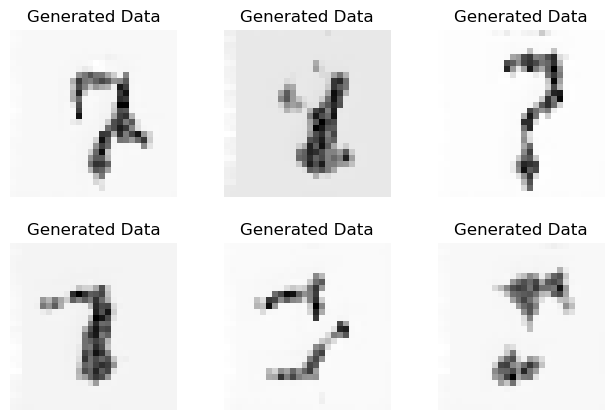

 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [28:40<09:46,  7.71s/it]

Epoch [225/100] | D Loss: 0.5532 | G Loss: 0.6931


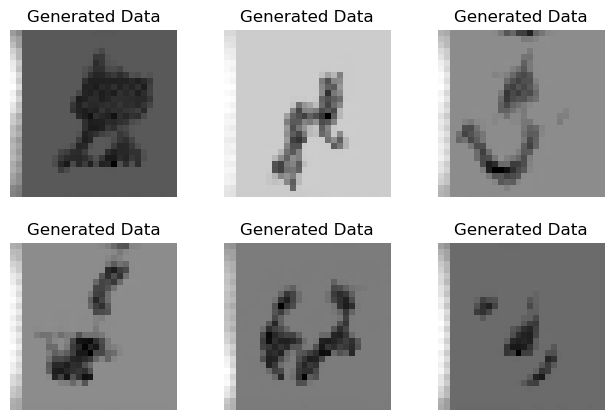

 75%|████████████████████████████████████████████████████████████                    | 225/300 [28:48<09:47,  7.84s/it]

Epoch [226/100] | D Loss: 0.5556 | G Loss: 0.6931


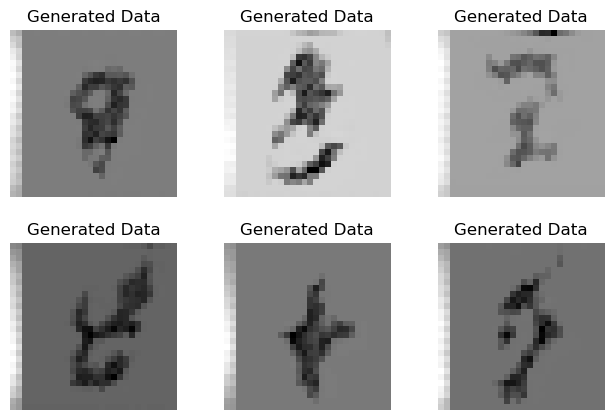

 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [28:55<09:24,  7.62s/it]

Epoch [227/100] | D Loss: 0.5533 | G Loss: 0.6931


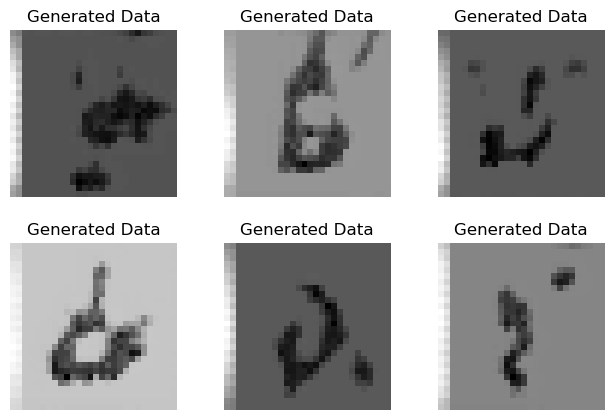

 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [29:04<09:40,  7.95s/it]

Epoch [228/100] | D Loss: 0.5534 | G Loss: 0.6931


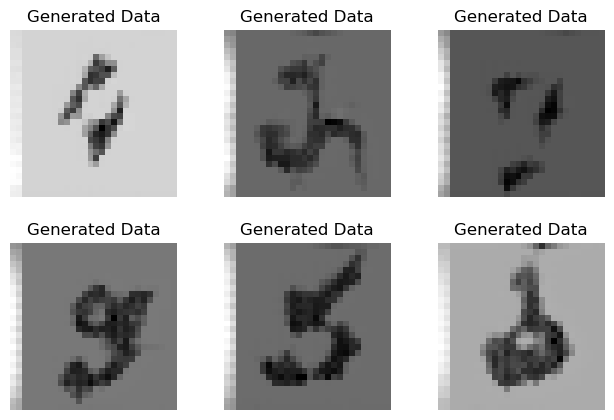

 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [29:12<09:22,  7.82s/it]

Epoch [229/100] | D Loss: 0.5532 | G Loss: 0.6922


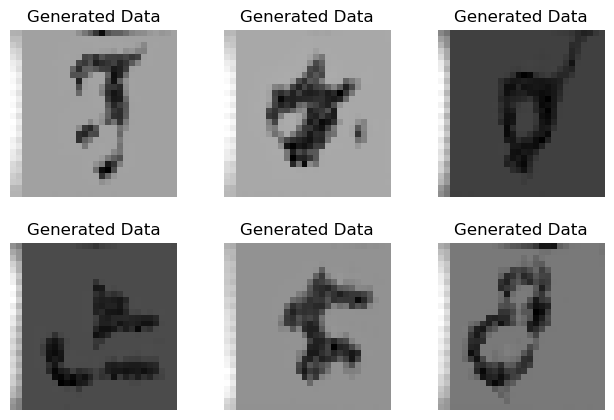

 76%|█████████████████████████████████████████████████████████████                   | 229/300 [29:20<09:33,  8.07s/it]

Epoch [230/100] | D Loss: 0.5532 | G Loss: 0.6922


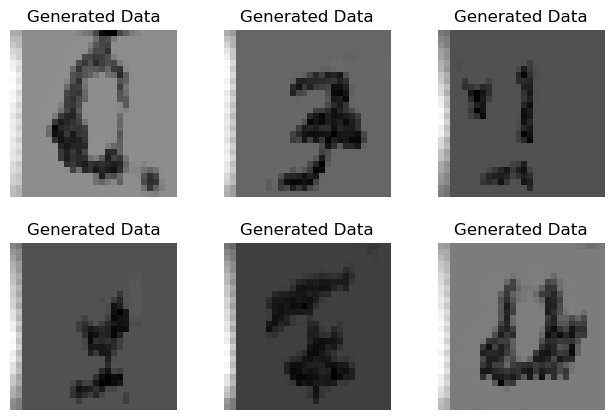

 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [29:28<09:10,  7.86s/it]

Epoch [231/100] | D Loss: 0.5532 | G Loss: 0.6931


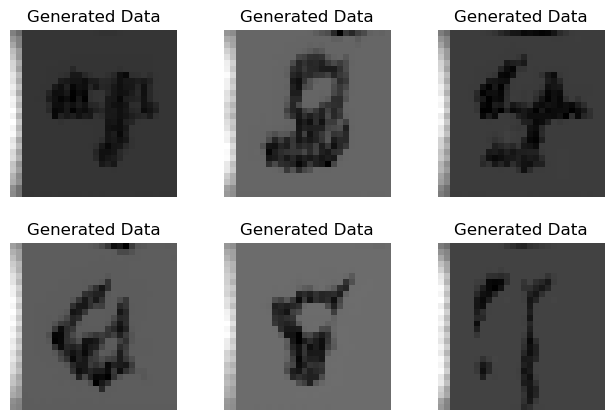

 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [29:41<08:52,  7.71s/it]


KeyboardInterrupt: 

In [110]:
from tqdm import tqdm
LATENT_DIM = 100
LR = 0.0002

generator = Generator(latent_dim=LATENT_DIM)
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

loss = nn.BCEWithLogitsLoss()

opt_g = torch.optim.Adam(generator.parameters(), lr=LR)
opt_d = torch.optim.Adam(discriminator.parameters(), lr=LR)

total_loss_disc = []
loss_gen = []


for epoch in tqdm(range(300)):
    for x,t in train_loader:
        # Test
#         z = torch.randn(x.size(0), LATENT_DIM, device=device)
#         imgs = generator(z)
#         print(imgs.size())
#         plot_imgs(imgs)
#         break
        # Train discriminator
        opt_d.zero_grad()
        # real
        x_real = x.to(device)
        y_real = torch.ones(x_real.size(0), 1, device=device) - 0.1
        prediction_real = discriminator(x_real)
        J_d_real = loss(prediction_real, y_real)
        # fake
        z = torch.randn(x_real.size(0), LATENT_DIM, device=device)
        x_fake = generator(z)
        #plt.imshow(x_fake[0][0].detach().cpu())
        #plt.show()
        y_fake = torch.zeros(x_real.size(0), 1, device=device)
        prediction_fake = discriminator(x_fake.detach()) # We use detach to create a new tensor
        J_d_fake = loss(prediction_fake, y_fake)
        
        total_loss = (J_d_real+J_d_fake)/2
        total_loss.backward()
        opt_d.step()
        
        if epoch%2 == 0:
        # Training generator
            opt_g.zero_grad()
            y_fake = torch.ones(x_real.size(0), 1, device=device) # we want to fool D
            prediction_fake = discriminator(x_fake)
            J_g = loss(prediction_fake, y_fake)
            J_g.backward()
            opt_g.step()
        
        #total_loss_disc.append(total_loss.item())
        #loss_gen.append(J_g.item())
        
    print(f"Epoch [{epoch+1}/100] | D Loss: {total_loss.item():.4f} | G Loss: {J_g.item():.4f}")

    with torch.no_grad():
        z = torch.randn(6, LATENT_DIM, device=device)
        generated_imgs = generator(z)
        plot_imgs(generated_imgs)
        
       

        
        

torch.Size([6, 1, 28, 28])


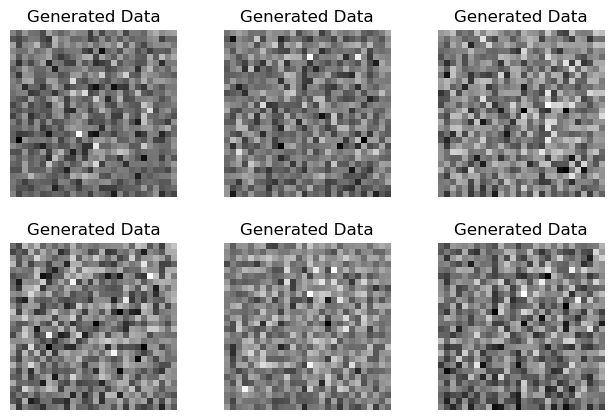

In [101]:
generator = Generator(latent_dim=LATENT_DIM)
generator = generator.to(device)

z = torch.randn(6, LATENT_DIM, device=device)
imgs = generator(z)
print(imgs.size())
plot_imgs(imgs)